<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

# Heart Failure Survival Analysis & Mortality Prediction Modelling 

## Exploratory data analysis, Descriptive statistics and Data visualization

### Import data & dataset overview

In [2]:
import pandas as pd
import numpy as np
import os
import time
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [3]:
url='https://raw.githubusercontent.com/ErezWasserman/Heart-Failure-Prediction/main/heart_failure_clinical_records_dataset.csv'
data = pd.read_csv(url)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [5]:
data.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


__Note: Features explanation and units/measurements can be found [here](https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-020-1023-5/tables/1).__

### Categorical features distribution (grouped by target)

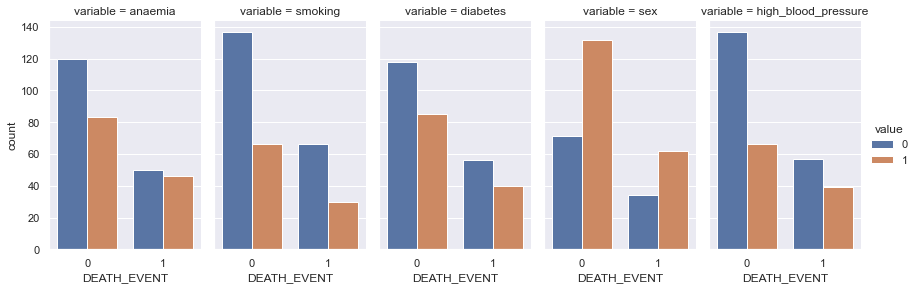

In [6]:
category_features = ['anaemia', 'smoking', 'diabetes', 'sex', 'high_blood_pressure']
binary_df = data[category_features].copy()
binary_df['DEATH_EVENT'] = data['DEATH_EVENT']
binary_df = binary_df.melt(id_vars=['DEATH_EVENT'])

g = sns.catplot(x='DEATH_EVENT', hue='value', col='variable', col_wrap=5,
                data=binary_df, kind="count", height=4, aspect=.6)

### Correlation between categorical features and target

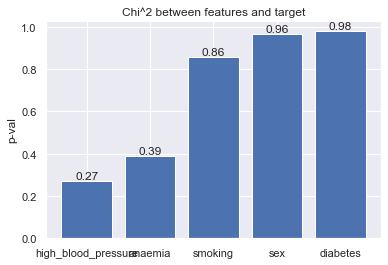

In [7]:
from sklearn.feature_selection import chi2

X = data[category_features] 
y = data['DEATH_EVENT'] 
chi_scores = chi2(X,y)

tups = sorted(zip(chi_scores[1],X.columns))
ordered_y,oredered_x = map(list,zip(*tups))
plot = plt.bar(oredered_x, ordered_y)  # X.columns, chi_scores[1]

# print p-values on top
for value in plot:
    height = value.get_height()
    plt.text(value.get_x() + value.get_width()/2., 1.002*height,'%.2f' % height, ha='center', va='bottom')

plt.title("Chi^2 between features and target")
plt.ylabel("p-val")
plt.show();

### Quantitative features distribution (grouped by target)

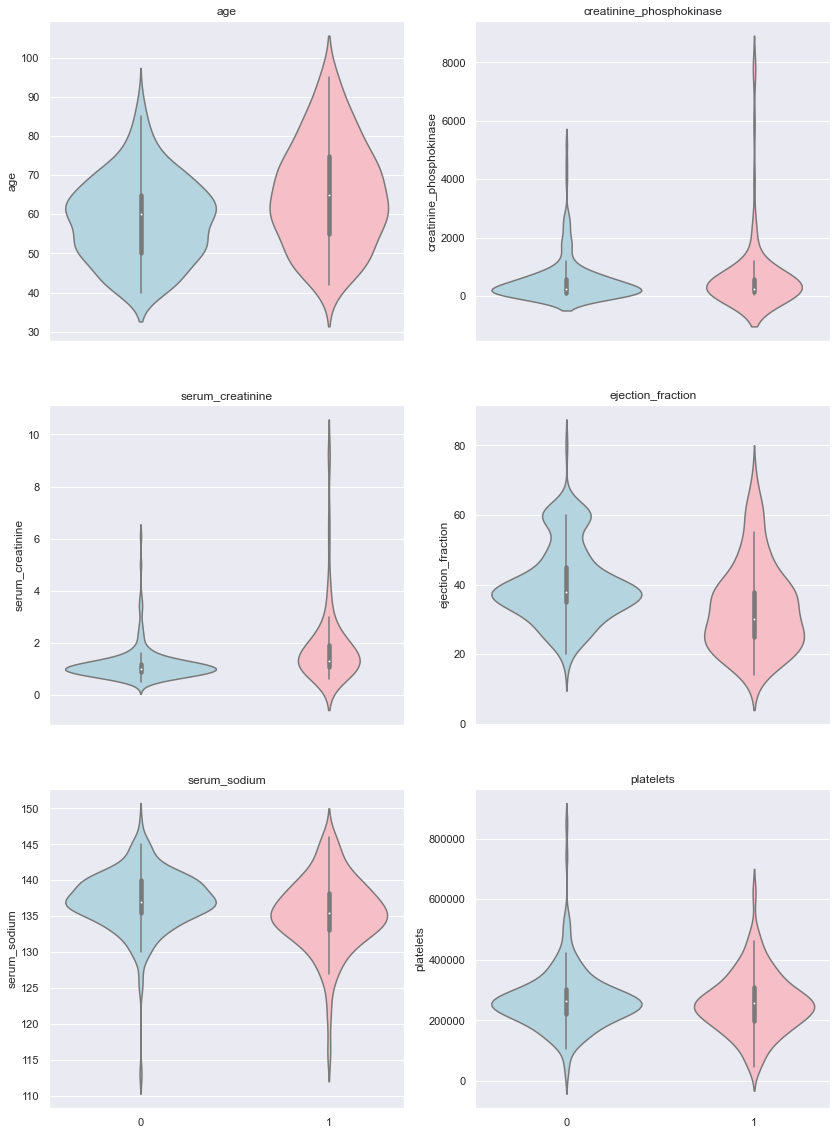

In [8]:
headers = list(data.keys())
target_features = ['time', 'DEATH_EVENT']


def set_approach(a,b):
    return list(set(a)-set(b))

numeric_features = set_approach(headers, target_features + category_features)

fig, axes = plt.subplots(round((len(numeric_features))/2),2, figsize=(14,20), sharex="col")

for i, j in enumerate(numeric_features):
    row = int(i/2)
    col = int(i%2)
    
    sns.violinplot(x="DEATH_EVENT", y=j, data=data, palette=["lightblue", "lightpink"], order=[0, 1], ax=axes[row, col])
    axes[row,col].set_xlabel('')
    axes[row,col].autoscale()
    axes[row,col].set_title(j)
plt.show()

### Correlation between quantitative features and target

Most correlated features:

serum_creatinine     0.294278
ejection_fraction   -0.268603
age                  0.253729
Name: DEATH_EVENT, dtype: float64


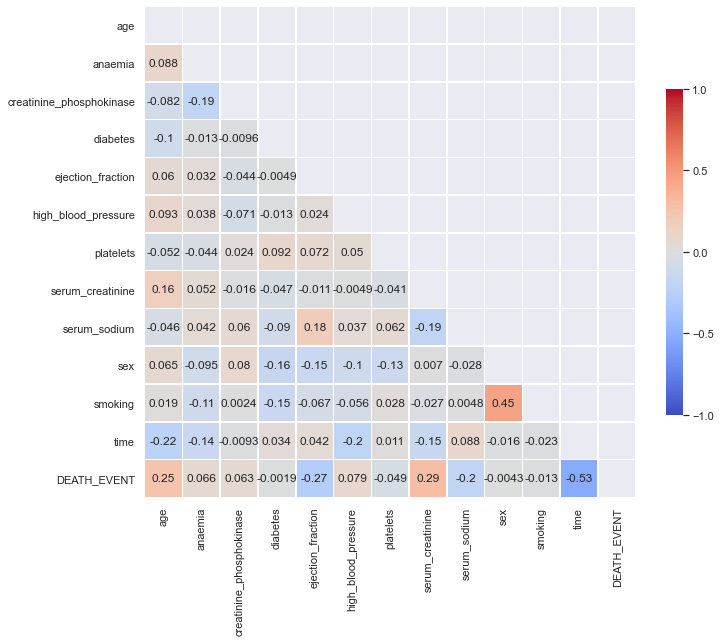

In [9]:
corr_matrix = data.corr()

mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

f, ax = plt.subplots(figsize=(11, 15))

heatmap = sns.heatmap(corr_matrix,
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {"size": 12})

#add the column names as labels
ax.set_yticklabels(corr_matrix.columns, rotation = 0)
ax.set_xticklabels(corr_matrix.columns)

sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

# Finding 3 topmost features correlated with 'DEATH_EVENT' ('time' excluded) 
most_corr = corr_matrix[['DEATH_EVENT']].abs().nlargest(5, 'DEATH_EVENT', keep='all')[-3:].index.tolist()
print('Most correlated features:\n\n{}'.format(corr_matrix['DEATH_EVENT'][most_corr]))

## Survival Analysis

### Events vs. Censored distributions

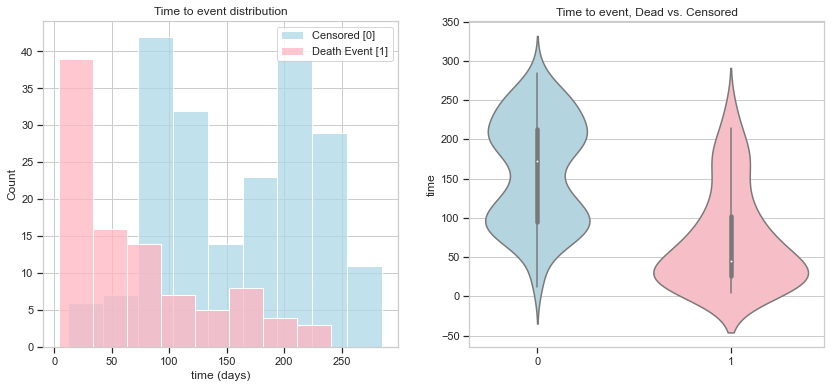

In [10]:
fig, axes = plt.subplots(1,2, figsize=(14,6)) 

sns.histplot(data.query("DEATH_EVENT==0")['time'], color="lightblue", label="Censored [0]",ax=axes[0])
sns.histplot(data.query("DEATH_EVENT==1")['time'], color="lightpink", label="Death Event [1]",ax=axes[0])
axes[0].legend()
axes[0].set_xlabel('time (days)')
axes[0].set_title('Time to event distribution')
axes[0].autoscale()

sns.violinplot(x="DEATH_EVENT", y='time', data=data, palette=["lightblue", "lightpink"], order=[0, 1], ax=axes[1])
axes[1].set_xlabel('')
axes[1].autoscale()
axes[1].set_title('Time to event, Dead vs. Censored')

plt.show()

### Plot life-lines of individuals

C:\Users\Erez\anaconda3\lib\site-packages\lifelines\plotting.py:672: UserWarning: For less visual clutter, you may want to subsample to less than 25 individuals.
  warnings.warn("For less visual clutter, you may want to subsample to less than 25 individuals.")


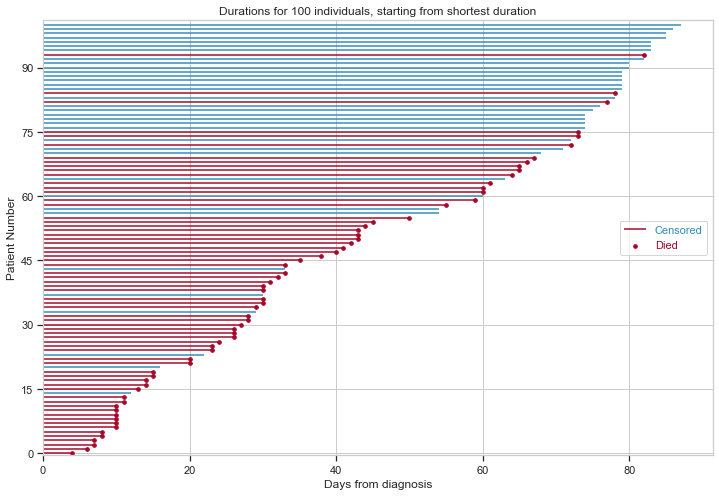

In [11]:
from lifelines.plotting import plot_lifetimes

T = data['time']
E = data['DEATH_EVENT']

plt.figure(figsize=(12,8))
plt.ylabel("Patient Number")
plt.xlabel("Days from diagnosis")
plt.title('Durations for 100 individuals, starting from shortest duration')
ax = plot_lifetimes(T.loc[:100], event_observed=E.loc[:100])
ax.legend(['Censored', 'Died'], loc=7, labelcolor=['#348ABD', '#A60628']);

###  Survival Curve Estimations using Kaplan-Meier Estimate 

__$\hat{S}(t)$ $=$ $\prod_{i: t_i \le t}$ $\frac{n_i - d_i}{n_i}$ 
<br><br> Where: <br> ${n_i}$ - the number of people at risk at time just prior to time ${t_i}$ <bR> ${d_i}$ - the number of events occurred at time ${t_i}$__

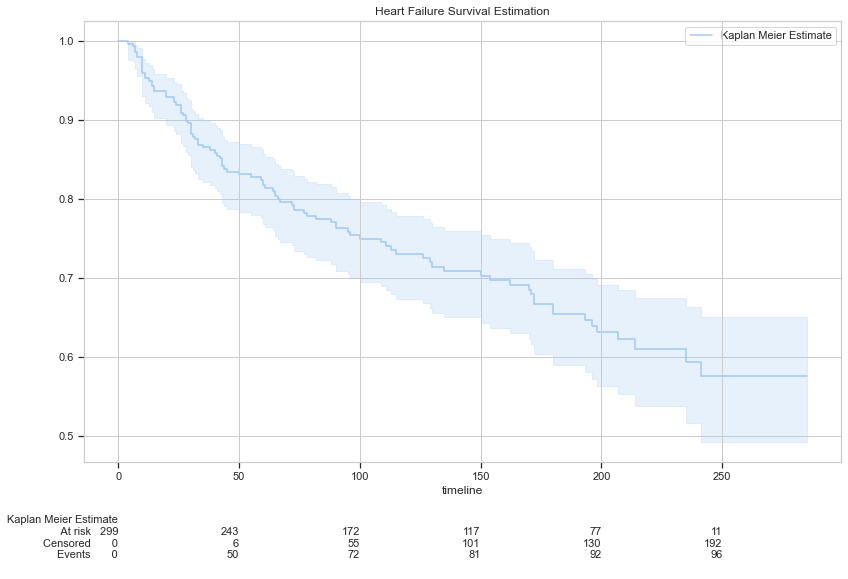

In [12]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E, label='Kaplan Meier Estimate')

plt.figure(figsize=(12,8))
kmf.plot_survival_function(at_risk_counts=True)  
plt.title('Heart Failure Survival Estimation');

In [13]:
kmf.event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,299,299
4.0,1,1,0,0,299
6.0,1,1,0,0,298
7.0,2,2,0,0,297
8.0,2,2,0,0,295
...,...,...,...,...,...
270.0,2,0,2,0,6
271.0,1,0,1,0,4
278.0,1,0,1,0,3


In [14]:
kmf.survival_function_

,Kaplan Meier Estimate
timeline,
0.0,1.000000
4.0,0.996656
6.0,0.993311
7.0,0.986622
8.0,0.979933
...,...
270.0,0.575705
271.0,0.575705
278.0,0.575705


In [15]:
kmf.predict(6)  # fraction of people who survived (x) days or above

0.9933110367892974

### Cumulative Density Curve Estimations using Kaplan-Meier Estimate

__$\hat{F}(t) = 1 - \hat{S}(t)$__

The probability of a person dying within a certain period of time

          Kaplan Meier Estimate
timeline                       
0.0                    0.000000
4.0                    0.003344
6.0                    0.006689
7.0                    0.013378
8.0                    0.020067


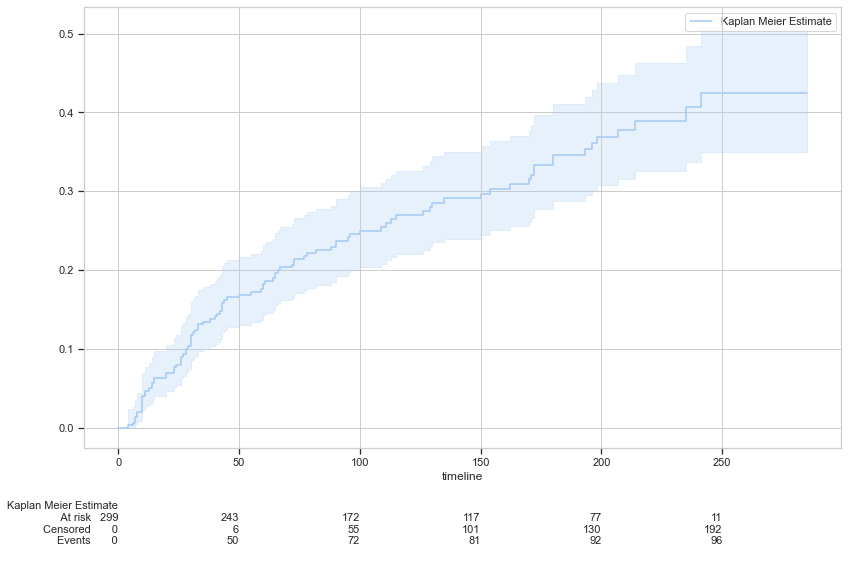

In [16]:
print(kmf.cumulative_density_.head())

plt.figure(figsize=(12,8))
kmf.plot_cumulative_density(at_risk_counts=True);

### Comparing Cohort's Survival Curves Estimations & Log-rank tests

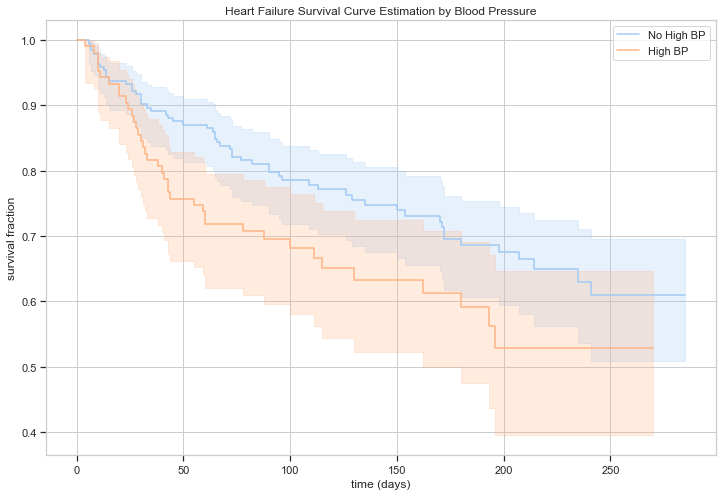

In [17]:
# Example for one binary feature: High Blood Pressure 

kmf1 = KaplanMeierFitter()
feat = (data['high_blood_pressure'] == 0)
plt.figure(figsize=(12,8))

kmf1.fit(T[feat], event_observed=E[feat], label='No High BP')
ax = kmf1.plot()

kmf1.fit(T[~feat], event_observed=E[~feat], label='High BP')
kmf1.plot(ax=ax)

plt.xlabel('time (days)')
plt.ylabel('survival fraction')
plt.title('Heart Failure Survival Curve Estimation by Blood Pressure');

In [18]:
# Log-Rank test to compare survival distributions of the 2 cohorts
from lifelines.statistics import logrank_test

results = logrank_test(T[feat], T[~feat], E[feat], E[~feat], alpha=.99)
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           4.41 0.04      4.80

,feature,statistic,p_value
0,anaemia,2.73,0.10
1,smoking,0.00,0.96
2,diabetes,0.04,0.84
3,sex,0.00,0.95
4,high_blood_pressure,4.41,0.04


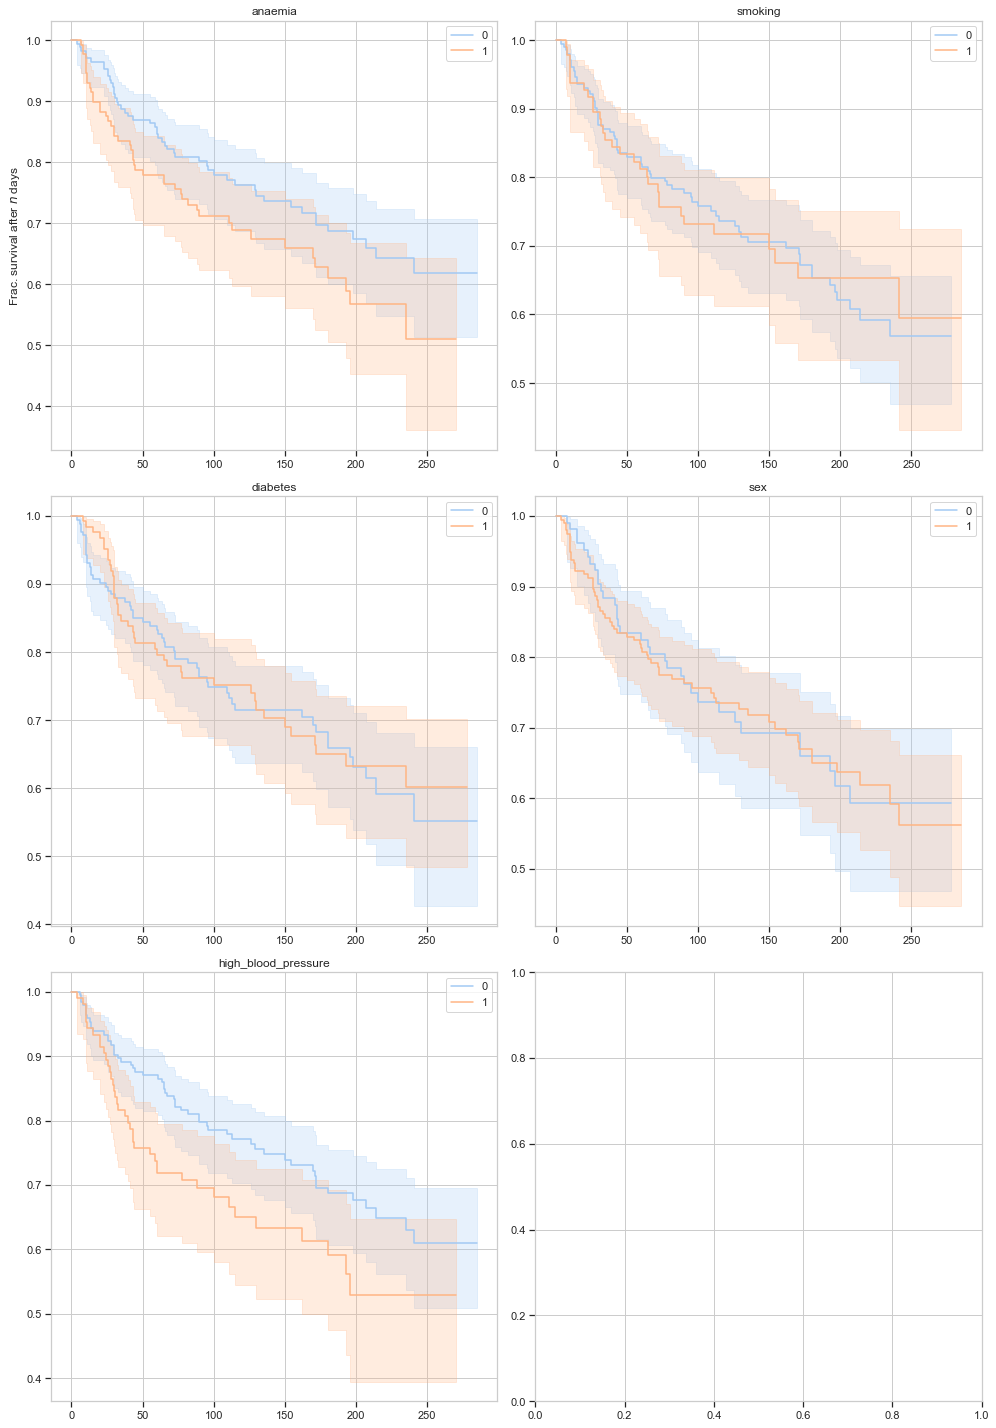

In [19]:
# Comparing every binomial features (0: No, 1: Yes) 

compared_feat = ['anaemia', 'smoking', 'diabetes', 'sex', 'high_blood_pressure']
kmf1 = KaplanMeierFitter()

fig, axes = plt.subplots(3,2, figsize=(14,20), sharex="col")  # sharey="row"

log_rank_list = [] 
for i, feature in enumerate(compared_feat):
    ax = plt.subplot(3, 2, i + 1)

    ix = data[feature] == 0
    kmf1.fit(T[ix], event_observed=E[ix], label='0')
    kmf1.plot_survival_function(ax=ax)  # , legend=False
    
    kmf1.fit(T[~ix], event_observed=E[~ix], label='1')
    kmf1.plot(ax=ax)
 
    plt.title(feature)
    plt.xlabel('')
    plt.autoscale()

    if i==0:
        plt.ylabel('Frac. survival after $n$ days')
        
    results = logrank_test(T[ix], T[~ix], E[ix], E[~ix]) 
    dict1 = {}
    dict1.update(feature = feature, statistic = '%.2f' % results.test_statistic, p_value = '%.2f' % results.p_value)
    log_rank_list.append(dict1)

plt.tight_layout()
df = pd.DataFrame(log_rank_list)
df

### Hazard Rates Estimations using Nelson-Aalen Estimate

__$\hat{H}(t)$ $=$ $\sum_{t_i \le t}$ $\frac{d_i}{n_i}$
<br><br> Where: <br> ${n_i}$ - the number of people at risk at time just prior to time ${t_i}$ <bR> ${d_i}$ - the number of events occurred at time ${t_i}$__

          NA_estimate
timeline             
0.0          0.000000
4.0          0.003344
6.0          0.006700
7.0          0.013446
8.0          0.020237


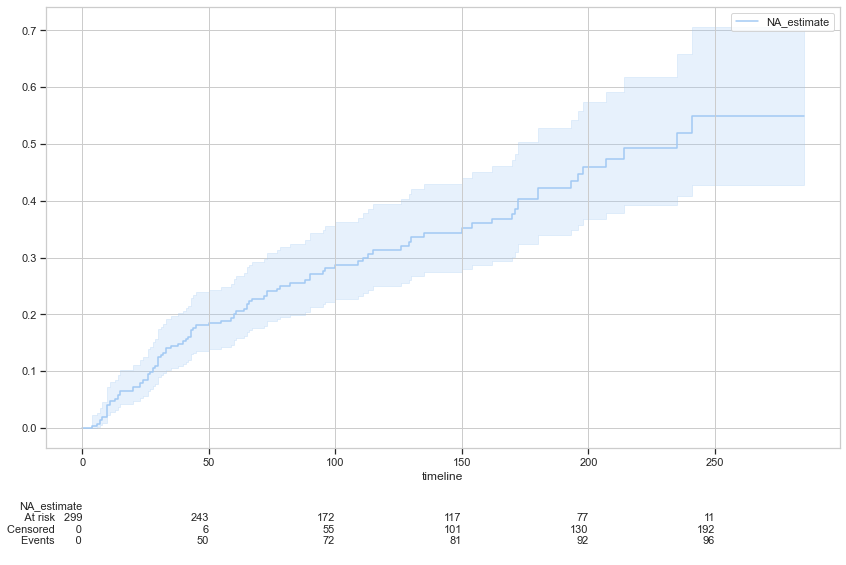

In [20]:
from lifelines import NelsonAalenFitter
naf = NelsonAalenFitter()

naf.fit(T, event_observed=E)

print(naf.cumulative_hazard_.head())
plt.figure(figsize=(12,8))
naf.plot_cumulative_hazard(at_risk_counts=True);

### Cox Proportional Hazard Model (Survival Regression)

__$h(t|X=x) = h_0(t)\exp(x^T\beta)$
<br><br> Where: <br> ${h_0(t)}$ - the baseline hazard function <br> ${x}$ - the covariates' value vector <bR> ${\beta}$ - the covariates' coefficient vector__

The Cox Model is commonly used in cases where we want to take into account and calculate the impact of additional covariates (features) on the survival curve of individuals 

In [21]:
from lifelines import CoxPHFitter
data_r = data.loc[:,['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time', 'DEATH_EVENT']]
data_r.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [22]:
# Fit the Cox Proportional Hazards model
cph = CoxPHFitter()   
cph.fit(data_r, 'time', event_col='DEATH_EVENT')   
cph.print_summary()   

<lifelines.CoxPHFitter: fitted with 299 total observations, 203 right-censored observations>
             duration col = 'time'
                event col = 'DEATH_EVENT'
      baseline estimation = breslow
   number of observations = 299
number of events observed = 96
   partial log-likelihood = -468.23
         time fit was run = 2021-03-17 16:25:54 UTC

---
                           coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                        
age                        0.05       1.05       0.01             0.03             0.06                 1.03                 1.07
anaemia                    0.46       1.58       0.22             0.04             0.89                 1.04                 2.42
creatinine_phosphokinase   0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
diabetes                   0.14       1.15       0.22            -0.30             0.58                 0.74                 1.78
ejection_fraction         -0.05       0.95       0.01            -0.07            -0.03                 0.93                 0.97
high_blood_pressure        0.48       1.61       0.22             0.05             0.90                 1.05                 2.46
platelets                 -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
serum_creatinine           0.32       1.38       0.07             0.18             0.46                 1.20                 1.58
serum_sodium              -0.04       0.96       0.02            -0.09             0.00                 0.91                 1.00
sex                       -0.24       0.79       0.25            -0.73             0.26                 0.48                 1.29
smoking                    0.13       1.14       0.25            -0.36             0.62                 0.70                 1.86

                             z      p   -log2(p)
covariate                                       
age                       4.98 <0.005      20.56
anaemia                   2.12   0.03       4.89
creatinine_phosphokinase  2.23   0.03       5.26
diabetes                  0.63   0.53       0.91
ejection_fraction        -4.67 <0.005      18.35
high_blood_pressure       2.20   0.03       5.17
platelets                -0.41   0.68       0.56
serum_creatinine          4.58 <0.005      17.68
serum_sodium             -1.90   0.06       4.12
sex                      -0.94   0.35       1.53
smoking                   0.51   0.61       0.72
---
Concordance = 0.74
Partial AIC = 958.46
log-likelihood ratio test = 81.95 on 11 df
-log2(p) of ll-ratio test = 40.56

#### Plotting the coefficient value ( $\beta$ $\pm$  95% CI) of each covariate

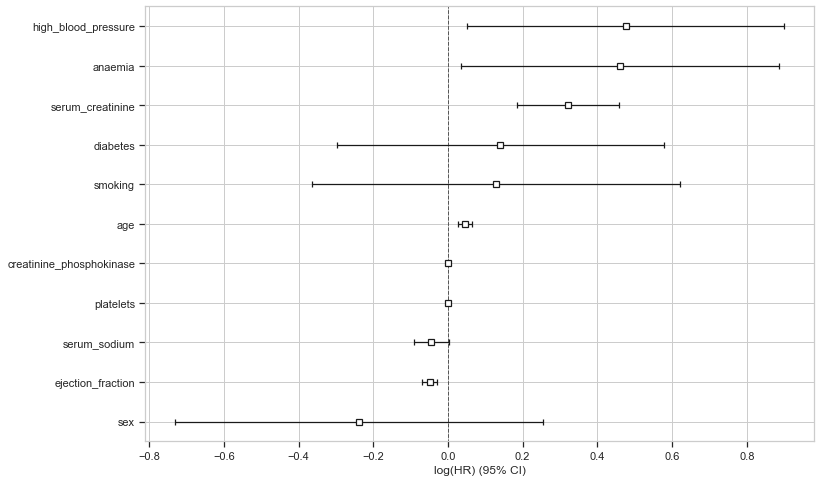

In [23]:
plt.figure(figsize=(12,8))
cph.plot();

#### Predicting Survival of individual patients based on their specific measures

In [24]:
tr_rows = data_r.iloc[5:10, 0:-2]
tr_rows

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking
5,90.0,1,47,0,40,1,204000.00,2.1,132,1,1
6,75.0,1,246,0,15,0,127000.00,1.2,137,1,0
7,60.0,1,315,1,60,0,454000.00,1.1,131,1,1
8,65.0,0,157,0,65,0,263358.03,1.5,138,0,0
9,80.0,1,123,0,35,1,388000.00,9.4,133,1,1


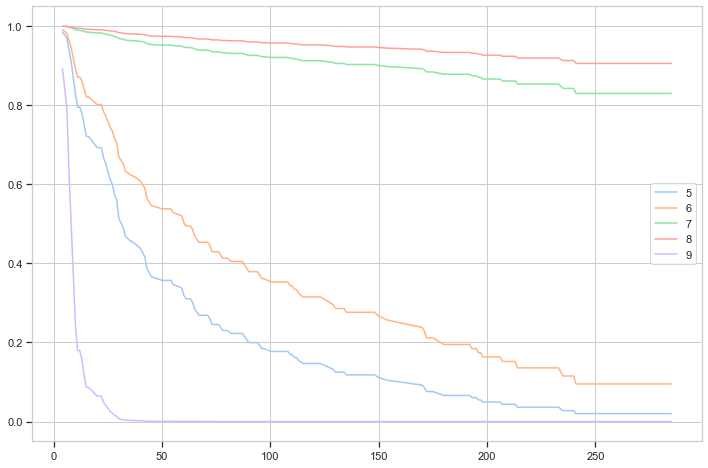

In [25]:
cph.predict_survival_function(tr_rows).plot(figsize=(12,8));

#### Visualizing predicted survival curves for new patients based on the fitted Cox model

In [26]:
# %matplotlib notebook
from ipywidgets import *  # from ipywidgets import widgets, interact
from IPython.display import display
from IPython.html import widgets
# plt.style.use('ggplot')

# features metadata for generating widgets
checkbox_features = ['anemia', 'diabetes', 'high_blood_pressure', 'smoking']
floatslider_features = [['cpk', 'creatinine phosphokinase (mcg/L)',20,8000,0.1], 
                        ['eject_frac', 'ejection fraction (%)',10,90,1], 
                        ['platelets', 'platelets (kiloplatelets/mL)',20,900,0.01], 
                        ['ser_creat', 'serum creatinine (mg/dL)',0.4,20,0.1], 
                        ['ser_sod', 'serum sodium (mEq/L)',110,150,1]]

def count_decimals(num):
    try:
        decimals = len(str(num).split('.')[1])
    except:
        decimals = 0
    readout_format = '.{}f'.format(decimals)
    return readout_format


def create_floatslider(feature_details):
    floatslider_dict[feature_details[0]] = widgets.FloatSlider(
        value=feature_details[2] + ( (feature_details[3] - feature_details[2]) / 2), # 7.5,
        min=feature_details[2],  #100,
        max=feature_details[3],  #1000,
        step=feature_details[4],  #0.1,
        description=feature_details[1],  #'Blood Creatinine:',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format=count_decimals(feature_details[4])  # '.1f',
    )
    display(floatslider_dict[feature_details[0]])

    
def create_checkbox(feature_details):
    checkbox_dict[feature_details] = widgets.Checkbox(
        value=False,
        description=feature_details,
        disabled=False,
        indent=False
    )
    display(checkbox_dict[feature_details])

C:\Users\Erez\anaconda3\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


Text(value='John Doe', description='Patient Identifier:', placeholder='Type here')

Dropdown(description='Sex:', options=(('Male', 1), ('Female', 0)), value=1)

BoundedIntText(value=55, description='Age (yrs):', max=119, min=40)

Checkbox(value=False, description='anemia', indent=False)

Checkbox(value=False, description='diabetes', indent=False)

Checkbox(value=False, description='high_blood_pressure', indent=False)

Checkbox(value=False, description='smoking', indent=False)

FloatSlider(value=4010.0, continuous_update=False, description='creatinine phosphokinase (mcg/L)', max=8000.0,…

FloatSlider(value=50.0, continuous_update=False, description='ejection fraction (%)', max=90.0, min=10.0, read…

FloatSlider(value=460.0, continuous_update=False, description='platelets (kiloplatelets/mL)', max=900.0, min=2…

FloatSlider(value=10.200000000000001, continuous_update=False, description='serum creatinine (mg/dL)', max=20.…

FloatSlider(value=130.0, continuous_update=False, description='serum sodium (mEq/L)', max=150.0, min=110.0, re…

Button(description='Predict Survival Curve', style=ButtonStyle())

Output()

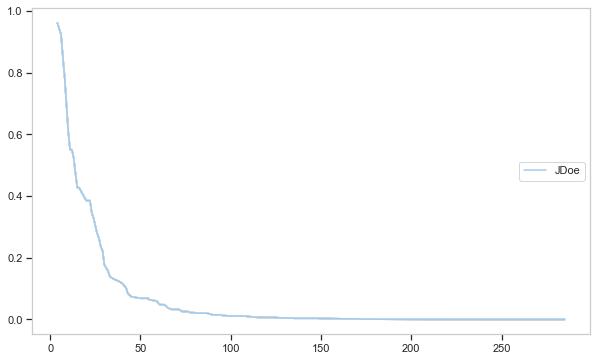

In [27]:
pat_id = widgets.Text(
    value='John Doe',
    placeholder='Type here',
    description='Patient Identifier:',
    disabled=False
)
display(pat_id)

sex = widgets.Dropdown(
    options=[('Male', 1), ('Female', 0)],
    value=1,
    description='Sex:',
)
display(sex)

age = widgets.BoundedIntText(
    value=55,
    min=40,
    max=119,
    step=1,
    description='Age (yrs):',
    disabled=False
)
display(age)

checkbox_dict = {}
for feature_details in checkbox_features:
    create_checkbox(feature_details)

floatslider_dict = {}
for feature_details in floatslider_features:
    create_floatslider(feature_details)
    
button = widgets.Button(description="Predict Survival Curve")
output = widgets.Output()
display(button, output)

def on_button_clicked(b):
    patient_features = np.array([age.value, int(checkbox_dict['anemia'].value), floatslider_dict['cpk'].value, \
int(checkbox_dict['diabetes'].value), floatslider_dict['eject_frac'].value, int(checkbox_dict['high_blood_pressure'].value), \
floatslider_dict['platelets'].value, floatslider_dict['ser_creat'].value, floatslider_dict['ser_sod'].value, sex.value, \
int(checkbox_dict['smoking'].value)])
    ax = cph.predict_survival_function(patient_features).plot(figsize=(10,6)) # , legend=False
    ax.legend([pat_id.value], loc=7); # , labelcolor=['#348ABD'] # , '#A60628'
    with output:
        print("Button clicked.")
    
button.on_click(on_button_clicked)

## XGBoost (eXtreme Gradient Boosting): regression trees for survival analysis

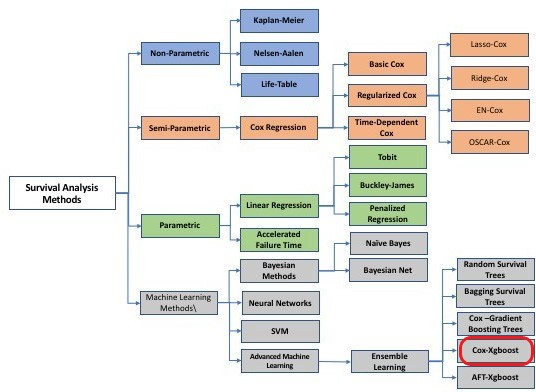

In [28]:
from IPython import display 
from base64 import b64decode 
base64_data="/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCAGIAhgDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9U6KKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiikbpQAtFRc7fX2pG+VWPtQLpckyO9G4dzX5/+D9Q1nVfCmi3t34q8VTXVxZQSyyHxLfjLtGpJIE+Mkk+nUACthjqf/Q0eK//AAptR/8Aj1e9HKKsldSR5rx0btWPunijivhbdqX/AEM/ir/wptR/+PUb9S/6GbxV/wCFNqP/AMep/wBj1v5kL69H+Vn3TxRxXwt5mp/9DR4r/wDCm1H/AOPUm7Uv+ho8V/8AhTaj/wDHqP7HrfzIPr0f5WfdO6jd718LbtS/6GjxX/4U2o//AB6jdqX/AENHiv8A8KbUf/j1H9j1v5kH1+PY+6cjsaMjtXwvu1Pr/wAJP4r/APCm1H/49Umm6lq+meJPC80XibxI5bXdLhdZtfvZo5I5L6BHVkeVlZWViDuHQ1M8oqwi5trQax0W0rH3NRSUteEemFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUjfdNLSUAct448RXfhXQ0urOzj1C6mu7azigmnMCM80yRAs4RiAC+chSeK4fxn4i+LFp/Zf9j+FNBmMl2EuVTV5Jh5O1ixYtBEEAOPmBY5wAjZ46v4qf8gPSv+w9pP8A6XQV2Mn+rb6VvCShyvlT9TmqRc7rma9D4A8Bgf8ACDeHgGLKNNtgpYYP+qXsSfx54rI+MUniCPwBdv4XEx1v7XZfZ/JDscG7iEm7aC2zZu3EdF3Z4rW+H/8AyInhz/sG2v8A6KFb1foMbSgtVqfObSufOF58UPH/AIR0PRki0jVbiWLTJrnWJtY0uVlW5C3JlPnqQgRJYk2rgL5bIVLBsqWnxE+IOpR2eutpupTwWsV55L2WjXMKThre0dS9qz7m2SyTorE5IjYru5B+jJoY7iGSKWNZYpFKvG4BVgRggg9QaWNFjRUUKqqMBVGBjsB2FYeyd/jZt7RW+FHhWhfET4o302jyz6EIrcG1jvIZtKniabffXVu7hy37oLDHBMcoceYDgKap+LtS+KK+PrxrCy1C3sdTtbbRxb2xa4ttOmm8wm9STYoIhEZ3YA5dQR0r6DopuleLXOxc6vflR8wWvjb4rr4Tk0qbRruRoPDuVe4tL4XtzN9k37xNGo2y+d8hQsr+nJXPWf8ACefFC+17VbGHS7bT4P7WWxglm0i6lMEBuWiE5JCxyqYQJMq/BOCAOF9zooVK1vfYcy/lQgzgZ69M9eev59fwPtmiL/kOeFv+xj0f/wBONvS0kX/Ic8Lf9jHo/wD6cbetazXspa9H+RlD416n3RS0lLX5wfWBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRSN900ALRUfGODSZ6DOaWwrktFN5o5pjHUU3mjmgB1FN5o5oAdRTeaOaAHUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRSN900AFFM7GvGf2kfFmveEdB8MnQNXm0S5v9ZFnNcwQwyv5QtLqXYBKjqMtEhyFzxitKVOVWcacd2ZzmoRcn0PaaK+Mv+FkfET/oomsf+AGm/wDyJS/8LI+IZ/5qJq//AIA6b/8AIlez/YuI7r8f8jh+v0+zPsvijivjP/hZPxF/6KJrH/gBpv8A8iUf8LK+In/RRNY/8AdN/wDkShZPiH1X4/5B9fp9mfZuaM18Zf8ACyPiJ/0UPV//AAA03/5Eo/4WR8RP+ih6x/4Aab/8iUf2NiP5l+P+Qvr9Psz7NzRmvjP/AIWT8RP+iiax/wCAGm//ACJR/wALJ+In/RRNY/8ABfpv/wAiUf2NiP5l+P8AkP6/S7M+zKTha+M/+FkfET/ooesf+AGm/wDyJXp37OfjbxP4m8UeLdO8Qa/ca9b2Vpp9xbtdW9tE0TSvdK4BhiQMCIk655Bxwa5sRltbDU/aTtY1p4uFSSik9T0n4qf8gLSv+w9pP/pdBXafwnvxXFfFT/kBaZ/2HdK/9LoK7ORsRtjrivOlrFWOhPWRwC/AP4ZqxB+HXhTnv/Ylt/8AEU//AIUH8Mu/w78Kf+CW2/8AiK+XvDHxY+JOteG9I1Cf4haos91ZwzuItP04KGZFY4BtjjqfoB3Nan/CyfiL/wBFD1f/AMANN/8AkSvcjleKkk1Jfe/8jgeKop2cfwR9Hf8ACgvhn/0Tvwr/AOCW2/8AiKP+FBfDL/onfhX/AMEtt/8AEV85f8LK+In/AEUTV/8AwA03/wCRKT/hZXxF/wCiiav/AOAGm/8AyJVf2Tiv5197/wAhfXKP8v4H0d/woP4Zf9E78K/+CW2/+Io/4UH8Mv8AonfhX/wS23/xFfOP/CyfiJ/0UPV//ADTf/kSl/4WR8Rf+iiav/4L9N/+RKX9lYr+Zfe/8hfXKH8v4H0b/wAKD+Gf/RO/Cv8A4Jbb/wCIo/4UF8Mv+id+Ff8AwS23/wARXzj/AMLJ+In/AEUPWP8AwA03/wCRKP8AhZPxE/6KHrH/AIAab/8AIlP+ycX/ADL73/kP65Q/l/A+jv8AhQXwy/6J54U/8Ett/wDEVJY/BP4e6VfW97Y+A/DNneW0qzQXFvpFukkUikFXVgmQwIBBHIIr5tPxJ+Inf4h6x+Fhpuf/AEkqTTfih8QLPxD4dE3jnUb63uNa06znt5rGwEcsUt3DE6kpbqy5SRgCGHNRPLMVCLk5LTzf+Q44qi2ko/gfZVFJQ3SvBPUFopnSmLwx9P60ATUU3mjmgB1FN5o5pAOopvNHNADqKbzRzTAdRTKbzu4NAD/Smt908ZrnPG3iKbwv4buNRt7Vb6ZHijjgkmMSO0kixjLhWKgF85CnpXJ+LNe+J1r4bv5dM8LaEdRWImBYdalnbf2ARrRA34so9x1q4QlO2yv3ZEpKN7nkvjBb3WPil47SfXfEEENpqUEFvBZa7eWkMaHT7RyBHFKqjLyOxIXktnNUhocvQeIPFX/hU6l/8kVBpV1rV94s8bTeI7S3sNcfU7c3dvaOXiR/7NssbWPXK7foSQC2ATs18FmWJxFHF1IRm0k+j0P0PLMLh62Dp1JQTbW7Wpmf2LL/ANDD4r/8KrUv/kij+xZf+hh8V/8AhVal/wDJFM8XPdr4U1prDzDfCymNv5IJfzPLbbtA5znGMV5pqHxI8U/2loNroul3728lgTd3GqaFeqqS+TcHJO0NkSwxblKgkSDaWaRdvFDFYqe0397O+WFwcN6a+49O/sWX/oYfFf8A4VWpf/JFH9iy/wDQw+K//Cq1L/5Iry2T4k+No7a0li0W5laXTWkZW0i4Zop1mkR5XHG5PLVWREIkk/iRN67dC+8QeMdQ8BzzGwnUC8SJ72zhlgvZLRb1UldLQqzq32YSMCDuLcqv3RVfWMUt6j+9krDYR7Ul9yPQv7Fl/wChh8V/+FVqX/yRR/Ysv/Qw+K//AAqtS/8AkivMNQ8ZeIdJmS08PWmqy6QkCvbtqWjX11cSKxnErvJIVbMexNsb/M/ABPmJjvfh1rWta/4Vt73xDpx0nWXllW4sdhAgKyMFUN/y0G0AiQcNnOAOBMsTiox5vaO3qxwwuDlLl9mr+iNL+xZf+hh8V/8AhVal/wDJFL/Yso5/4SHxWf8AuatS/wDkitKilRxmIdSKc3uurHVwOFUJNU1t2R7V8Fb271b4OeBL2+up729uNB0+ae5uGLySyNboXd2OSWJJJOc570UnwB/5IX8Ov+xb03/0ljor9HPzGW539FFFMQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAjdKbJ/q2+lObpTJv8AUt9KYnsedab8T9R17S7XULDwH4iubK6jWaGXzdOXejAFTta7BGQc4Izj0rwn4y/EjXPGn9h2Gp+DtQ8P22n+KGjhvbqRDHNtsb0BPlJy2DklSy8H5gcA/Rfwd/5JV4R/7Bdt/wCi1rzr9rT/AJAPgj/sY/8A3H31ejgpxp4iMXHro9dDhxEJSpt8ztbY+Zvipr174V+GfirV9OcR39hplxdW7socK6RsVJU8HkDg8V41b/tFeItBk1i012zsE1LTrmPTrhr6b7HZxzpbTTSOJNrEify0MQI6SDuMH6PpMDgEe4r7OonOScZW+R4kHGMWmrnj/hf476nr3iBbWbwpJFaTR3PkRW85kvfMhS1dleNwirkXIH3zzGfYVzg+MHjHR9R8Ta1exwnwzZ6hPpsS6oYoI0m8+FII1eIs+Qry+Y0oVc7MNgmvoSkKg8H61LhJpXnqiuaN78p4BN+05qH/AAi8mvDRNOtbQQWJjF5fyK8lxcWguvL4j2gBdw3FlycdCcFk/wC01rXkve2/hWxfTUguLjMmpOs3l26Wry/KICu4i7UKAcZU5xwK+gto4GPej69KXLO6fP8AgVzQ/l/E8B1T9ojXJPEFxZWWk6TY2dnrsemz3Wo6ioKR/aXgYyRr80W/arKzDbtbHJxuJv2g9YtJItQutOtLS0uomECS34W2hX7fHafaLmTyd8eMuxwSu3aDg5I99KjJJAyetKVBGCOKOWf8/wCAuaP8pW0q8OoaXZ3e6F2mgSXday+dGcqDlHIG9OflbAyMHAzx6D+z/rd/onjzxf8A2foF9r4k0zS9/wBglt0EIWW9xnzpI8hsnGCfunO3jPEDtxgV6l+yyf8AivvHf/YN0n/0bf1y5nJfVXrcvDR/fLl0Ov8AiN4z1ibRdOFz4F1yyiXWtLdppp7B+RewEKAlyzEk4Ucd+cDmpvF3xq1Xw7eaPbp4A8QXf2+ZoWVViMgG3O5FWRg2O+8ouOd3GK6r4rf8i3Y/9h7R/wD05W1djJ/qzn0r4+NSHutxue1KEvetI/P/AMA4XwP4dw24DTbbDKSQf3a8+vX8azPi7rep+HPh7ql9olxHZ6onkxW88kYlSJnmjTJU/e+8a0/h/wD8iJ4c/wCwba/+ihW9X6FFc1JcrtdHzeilqfNtn+0x4gsY7pb7QIpL8au+mPa3F1HZR20kFnaNPCsj4DM00kxTJ5UZ+6Ksx/tHal4as7mLUbKHV5o01S5ikW4VZZPJv7qFUZEUmNEjjjzIwwQGwSykH6IwG4xnuM0bQTkjnGKw9jUtbnNnUpv7J4jpf7QmrahqWkxt4esmtLg2YuJrbVVmP+k3tzaR+SY1ZHGbdXILjAZlOWBpPGHxu1TSfiB4fggsL2w0C2aFddjubLeYvtMrQweZLGWWLYUWT72GSQfQe3gAdBilqnTqcrXOL2kLp8v4nzUv7UWoapHHqtnYRy2dg128ltZS+Yl9GtgbiPlow8W1uG4BAGSOq10el/tC6vqF1pSt4f042s0lqlzcQaqswCXGoGyR4vLVlbko5VmGMMOvNe44A4xRtC8AYqVTq3+P8B88P5fxHcfhTI/+Q54W/wCxi0f/ANONvTqbH/yHPC3/AGMWj/8Apxt62rfwp+j/ACM6Xxo+6aG+6aT3oLYXNfmx9YNb7pOegry34qfFjVPAfiDQ9K0nQbXWbjUre6uma91JrNIlgaBSBtglLEm4HGBgKTzmvUWb5TzjivnH4s+JtL8WeOvA2oaPqNvqdlJo+rgT20gZc+fpxwcdD2wfp1rmxE5UaMqkeiOjC04V8RClLqzZ/wCF++M/+hH0H/wpZ/8A5Ao/4X74z/6EfQf/AApZ/wD5ArkaPr0r5D+28R/KvxPuP7Dwvd/edf8A8L+8Z/8AQjaD/wCFLP8A/IFJ/wAL88Z/9CPoP/hSz/8AyBXiK/G7wz/wnmp+FLh7m1vNP81p7ydEW2HlwRTyfMG3IqxzRkswUZyMkg1buvjL4Oj0m5vrbXbDUTDZXF/9ntbqPzXjhD+Z95lVceU65cqMocn5Tjb+1sXHeC+5mMcnwb+0/vPYx8fPGY/5kfQf/Cln/wDkCj/hfnjP/oR9B/8ACln/APkCvK5PiZ4WWz1+4/tyykXQbdrnVFimDvZxhS5MiqTggA8df0rO0/4weHZbKxuNZkk8JSahN5VnaeIWS1muRhCHRdx+U+ag68MdpweKX9r4u9uRfcyv7HwW/M9fNHsv/C/fGf8A0I+g/wDhSz//ACBTf+F/eM/+hG0H/wAKWf8A+QK880Dxfonirz/7H1az1TycGX7LKsnl5LAbsE4yUYYPI2kdq16j+28QnZxX4miyPCtXTf3nV/8AC/vGe0/8UPoX/hSz/wDyBXcfCT4jXnxE0/Wnv9Hg0e60vUv7PeO2vmu45AbeCcOHaKMjicAgr1U8nNeOV3/7Nv8Ax6+P/T/hIx/6bbCvXy3MKmMlKM0tO1zxM0y6lg6cZU29XY7P4tf8iPP2/wBMs/8A0qirsOdoGMjHWuR+Lf8AyI8//X3Z/wDpVFXX9Vx14r6L7CPll8TPl7xB/wAlV+I//YYt/wD02WVN/Gvcda+EngbxNqkuo6x4M8P6tqU5Xzry90uCaWXChV3OyEnCgAZPAAHpVb/hQvwy/wCid+FP/BJbf/EV81iMojiK0qvPa/kfT4XOpYWlGmoJ203PF6K9p/4UJ8Mv+ieeFP8AwSW3/wARR/woP4Zf9E88Kf8Agktv/iK5/wCwl/z8/D/gnZ/rA/8An1+J4tRXtP8AwoP4Zf8ARO/Cn/gktv8A4ij/AIUH8Mv+id+FP/BJbf8AxFH9hL/n5+H/AARf2+/+ff4ni1Fe0/8ACg/hl/0Tzwp/4JLb/wCIo/4UH8Mv+ieeFP8AwSW3/wARS/sFf8/Pw/4I/wDWB/8APr8Txaivaf8AhQfwy/6J34U/8Elt/wDEUn/ChPhmOR8O/Cmf+wJbf/EVcMjUZKXPt5Gcs/lKLj7PfzHfAP8A5IZ8Of8AsW9N/wDSaOiuu03T7bSbG1sbK2hs7K2iWGC3t41jjijUAKiqOFUAAAAcAUV9QfKGhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAi0x/8AVtT1qOb/AFLULcUtjkPg/wD8kn8I8f8AMKtv/Ra1q+JvB+h+NLOGz1/RdP1yzjlEyW+pWiXEayBSocK4IDbWYZ9CR3rK+Dv/ACSvwj/2Crf/ANFrXZf4VUrqTaJjrFXOB/4UH8Mv+id+Ff8AwS23/wARR/woP4Zf9E78K/8Agltv/iK76jFHtJ/zMOSPZHA/8KD+GX/RO/Cv/gltv/iKP+FB/DL/AKJ34V/8Ett/8RXfYoxR7Sf8zDkj2RwP/Cg/hl/0Tvwr/wCCW2/+Io/4UH8Mv+id+Ff/AAS23/xFd9ijFHtJ/wAzDkj2RwP/AAoP4Zf9E78K/wDgltv/AIij/hQfwy/6J34V/wDBLbf/ABFd9ijFHtJ/zMOSPZHAf8KC+GfP/FvPCv8A4Jbb/wCIra8L/D/w14Haf/hHPD2k6ALnb9o/suyjtvO2527tijdt3NjPTJ9TXTUjdDScpSVmwUIx2RxfxY/5Fuw/7D2j/wDpytq7Jl3KQeQRXGfFj/kWbD/sPaN/6crauyboafRCXxSv5Hj9v+yz8NrWGK3t9K1OKCNQiRxeINRVVUAAAAXGAOmBxx0qwf2W/h3/ANA7Vv8Awo9S/wDkivnXUNQ1jUPEXiaWTxL4mjK6/qcKJb+IL2GJEjvZkRFRJgEVVUABRgDFM3ap/wBDR4q/8KbUf/j1fRwwOLlBSVT8WeVLEUU2uT8EfR3/AAy78O/+gdq//hR6l/8AJFH/AAy78O/+gdq//hR6l/8AJFfOGdR/6GjxT/4U2o//AB6jdqf/AENHiv8A8KbUf/j1V9Rxn/P1/exfWKH8n4I+j/8Ahlz4d/8AQO1f/wAKPUv/AJIo/wCGXPh3/wBA7V//AAo9S/8AkivnDdqX/Q0eK/8AwptR/wDj1G7Uh/zM/iv/AMKbUf8A49T+o429vav72L6xR/k/BH0f/wAMt/Dr/oH6x/4Uepf/ACRR/wAMu/Dr/oH6v/4Uepf/ACRXzjnUv+hn8Vf+FNqP/wAepN2pAf8AI0eKh/3M2o//AB6n9Rxv/P1/ew+s0F9j8EfR5/Zd+Hf/AED9W/8ACj1L/wCSKfYfs1/D/TdSsb6HTdSe5s7mK6g+0a7fzIsscgkRijzlWw6hsEHp0r5szqf/AENHir/wptR/+PVNpuo6vpviTwvLH4n8SOW13S4nSfX72eOSOS+gRlZHlZWVlYg7h0NZzwWMjBylVdvVlxxFFtWgfcv8PPSvOfiJ4f0zxL4y8HWWr6baarZs92xt72BZo8iIYJVgRn3r0VelcZ4q/wCSg+C/ref+iRXzkNz1ZbDW+DHgDaf+KH8O/hpUH/xFeGeOvhj4c+F/jfwXYeHtNSxjk0jVWmkyXmmZZtPAZ3OS2Mn2G7jAOK+pGX5fWvMfip8J9V8feINC1XStdtNFn023u7ZlvNOa8SVZ2gYkbZ4ipBtxzk5DEYGM1z4jnrUZUov4l8jpwkoUMRCtJfCzyuj/ADxXWf8ADP3jT/oeNC/8Jqf/AOT6P+GfvGn/AEPGhf8AhNT/APyfXxn9iYj+Zfifdf25hezPn/WP2ddA1rxhq/iRtV1i0v8AUhO5Nk8MRt5JbNbNpIpFh80Hy1GFaRkVxu25xjJj/ZR8Mw288P8AbWtFLi11C0nMf2WNpVvElWXcyQKxA80sEz5YZUbaSDn6WP7P/jP/AKHjQf8Awmp//k+j/hn7xn/0POg/+E1P/wDJ9df9n43+df18jn/tTA7uLPFtN+Dmk6fofinRHvb++0DxELj7Rpdw0flQG43GcxukayDcXJ+ZjtP3dvSsXUv2e7HXFtRq/izxHqzR27WMsl1JZhrmzZ4n+zSFLcfLugU7lCuSWy+CAPoP/hn3xp/0PGhf+E1P/wDJ9H/DPvjT/oeNC/8ACan/APk+j+zcXdvnWv8AXYX9rYJpJxeh498N/hPpnwvk12TTb7ULo63eNqN59tkVw90xPmTLtRdrPldw+6AowBznta6v/hn/AMZ/9DxoX/hNT/8AyfS/8M/+M/8AoeNB/wDCbn/+T6wlk+JqS5pyVzaOdYWKtFNI5OvQP2a/+PXx/wD9jGP/AE22FZTfs/8AjP8A6HjQv/Can/8Ak+u4+Evw5vfh3p+trf6xBrF1qmpf2g8lrYtaRx/6PBAECNLIScQAklurHgYr1sty+pg5SlNrU8bNMxo4ynGNO90zR+Lf/IkXH/X3Z/8ApVFXXr938BXB/GnUoNK+Hl7dXLMkENzZu7Kpc7RdRE4ABJOOwBPsara18atD0XRL/UPsXiCUWts8/lt4e1CJW2oWwXeAKgOOpIA6nivo+WUopJdT5XnjGTuzgvit4o8VQ/FW60jSPFWoaDp1votleeTY2tnJvllnvEdi08Eh6Qx4AIHBPJJrA/t/x3/0UjXv/AHS/wD5DrN1Hx9p/wASviVe65psF5b2s3h7TUEd5A0Tgi51Ak88MvIwykjOR1BxoV8fmuNxGFxDoxdrJaW2Z93lWBw2Iwsak43u2O/4SHx3/wBFI13/AMAdL/8AkOj/AISLx3/0UjXf/AHS/wD5Dqnqd01jpt3cqqu0MLyBW6EhScH8q8e8K/Hq7utBi1DWbPLtceQkVraNBLMzWsEyDbJLmMlp9oLkhl2v8qnNeZHMcZNXjL8EelPL8FCSi4Htv/CReO/+ika7/wCAOl//ACHR/wAJF47/AOika7/4A6X/APIdeOW/7Q0WnwyJrGjXcd1DLfSXEdsY2+y20FxeIGK7zuwlo24oSASvTcANy7+MSReD9Q1QaHqmn30OY4rXVLWSCNm+TaxlC7VizICWJ7NgEqap4/HR3kvwIWBwD0UUej/8JF47/wCika7/AOAOl/8AyHR/wkXjv/opGu/+AOl//IdcDdfEK48MajHpWsQDVLxXtDc3umwi3ghW7uDb2+Y5JGfmRGB2lsAZO3IFa3w/8eWXxG0OTVLC3nt7dJ2tytzs3eYgHmr8pP3HLJngEpldylWMyzHGxV3L8EXHLsFJ2UDqP+Ei8d/9FI13/wAAdL/+Q6T/AISDx2eP+Fj68fYWOl5/9I6SilSzTFSnGLl1XQKuV4WMG1Doe5/CHXL3xR8K/Bms6lP9q1HUdFsru5nCKgklkhR3bavyjLEnAHGe1FVfgH/yQz4df9i3pv8A6TR0V9+fnMtzv6KKKYgooooAKKKKACiiigAooooAKKKKACiiigBv8NMm/wBS30p/8NMm/wBS30prcmWxx/wd/wCSV+Ef+wVb/wDota7IdvpXG/B3/klfhH/sFW//AKLWuyHb6U5bsI7L0H0UUVJQUUUUAFFFFABRRRQAUjfdNLRQBx/xF0W/1vw7HDpkUU97DqFjeJFcS+WkgguopmUttbblYyOnXFcj408Y/EzSYdMfRPBdjfTy36RTRjUTJ+6KOWJ+RAnIHzEkA8YJNetilYGtadRR+KKf3/5mMqbltJo+ELWSea+8QSXUSwXL69qrTQo+8Rv9vn3KGIG4A5AYAZHOOws0x/8AkPeKP+xi1j/04XFPr9CoTXs42a2X5HzMt3fuzjfizfalpfhW2u9LS/eaHVdPeddNglnmNsLyE3GEjDO6+XvyFGdua8k8Qa18QZPEcuu6LY6tNY2f9rXVpp9xa3yJOStmsBkRnDE7ZZmWLb1jkAXccj6NoqJwU3fmZtGpyq1jxbXNS8c+KPgzrNxLaXFtrEWm3l1ZXmivc2lzLcxtIsEf2Zo0kyVCEg8E9FIINcz4q8UeP7ebWvD2lWWt/wBl6e9q9tqTaZdzXO6PULPed6sftKtFJMxAYMUjf7oyK+j6KmVK9rTYRqJX91HzYvj74p24u9WTRrjzbyKyg8y40q6MEMayaliZbZNzqzhLPeoBKiZd2MAj6I0ma5udJspryNIruWBGnjjDbVkKgsF3YbAOcZAPqAQat0VrSXs23zXInLmWyCmxf8h7wt/2MWj/APpxt6dTYv8AkPeFv+xi0f8A9ONvTrSXsZ69GTT+Jep90L92uM8Vf8lB8F/W8/8ARIrszjbz0xXnHxE8SaV4Z8beDbvV9Ts9Ltd14pnvZ0hQHyhxuYgdce9fnME76H1EmktT0RmwvpXmHxU+LGq+AfEGg6VpWhWmtT6lb3dyzXmpNZpEsDQKQNsEpYk3A4wMBScnOK3W+NHgDaf+K38O/hqsH/xdeF+Ofid4c+KHjjwXf+HdSS+jj0jVVmjwVmhZptPIV0OCM4PsdvGQM1z4jno0Z1or4V8jpwsadfEQoyfxM6//AIaA8Zf9CPoX/hSz/wDyBR/w0B4z/wChH0L/AMKWf/5AryT4qfEGP4ZeDZNekto7pVurW1Ec9yIIwZ544g7OVbaimTcSF6A1xei/tVeBb7TdPn1S6l0W8uNPfUpLWeGSURRLFLKDvVSGDRQySrgZZADgF1B+VjmWMlHnjBNH2UspwUZckpNP1Po//hoHxn/0I+hf+FLP/wDIFL/w0F4z/wChH0L/AMKWf/5Arw7Sfj54Q1gYgu7pHM0MGy4tJY2LSXv2FByBn/SBtOMgYJ6DNY+j/tLeFpdB0y91vz9Gur3TJ9WEDQSSoIoY5ZJAsioAzCOJ2OBztI+9gF/2ljNvZ/gwWVYH+f8AE+iP+GgPGX/QjaF/4Us//wAgUf8ADQHjL/oRtC/8KWf/AOQK8Es/2gvDr3rxXaXlnDJqcOmW0ktjcBzJJaxXCmdWjXyMpJu5yNqFiRghcPW/2tfBFt4L1PW9Fnudfu7W2uJobCK0nVpfKgWfc5EZMcREkeZSMDzBnBDAH9o429uRfcL+y8D/ADP7z6X/AOGgPGX/AEI+hf8AhSz/APyBSf8ADQHjP/oR9B/8KSf/AOQK8e1z4iXVj46tPC2laL/al19iTUr6eW6W3jtrVpTGrDg72JWT5RgYQgspIzh/8NK+AxZLdvf30UEhhWJpNOuE88TJK9u0fyfMswgk8sgfMV2jJIBP7TxvSCY1lOCf2n8z31vj/wCMv+hH0L/wpZ//AJAruPhJ8Rb34iafrTX2kQaNdaVqX9nvHbXzXcb/AOjwThw7RRkHE4BBXqp5Oa8bHOMDHb2Hf/DGOvPStj4L/Evwr4Jm8c2eva/Y6RdTa6txFBdzBGaM6dZKGAPVcowz6g16eWYytjZyhKOqXTc8rNMvoYOlGpB7vq9D0L9ov/kkOtenmWv/AKVRV6HJBHc27xSqssTptdGGQwI5BHcEV4P8cfjJ4H8QfDHVbDTfFOl3l3NLbeXBDcKXOLiNjgfQE59q99jYSRqc5BGeK+inCdOCUk1vv8j5SMoyqOzufOnxSUR/HDUwP+hc0sDoMf6TqNZWfxr2fxh8GvC/jjXP7Y1e1vjqP2eOz8+y1a8s90SM7orLBKgbDSyYJGRuPNZf/DNvgXj9zr3/AIVGqf8AyTXzONyv63UdTntt0PrMDm6wlJUnC9rnlUkKzRsjhXRgVZWGQQeoNZE3g3QbiN45dD02SNovs7RyWcZBjC7BGcj7oU7cdMcdK9t/4Zs8Cf8APDXv/Co1T/5Jo/4Zr8Cf88Ne/wDCo1T/AOSa5Fkdv+Xn4Hd/b8H/AMu/xPnKb4M+FZNesdTg02GzNnGqR2trDHHBhZJJOgQlMvK5YIQH3fPvAAHS2PhnR9L0eXSrTSbK30uRWR7KO3VYXUgAgoAFIYcHPUV7R/wzX4F/599e/wDCo1T/AOSaX/hmvwJ/z769/wCFRqn/AMk0SyWUt6n4f8EmOe047Uzwm3+HfhWze0Nv4a0iFrMlrcrYRIYiTklcL8uTydvcVqaZo+naLE0en2NtYxvt3JbwrGG2osa5CgdEjRR6BVHAAA9h/wCGa/An/Pvr3/hUap/8k0f8M1+Bf+ffXv8AwqNU/wDkmj+w21Z1PwBZ9FO6p/ieVUV6r/wzX4F/599e/wDCo1T/AOSaRv2bfAu0/wCj690/6GjVP/kmnTyRQkpOe3kEs+jKLjyb+Zq/AP8A5IZ8Of8AsW9N/wDSaOiul0HQrLwvoem6PpsBt9O0+3jtLaHeWEcUahEGSSThQOTknHJor6o+Q3NqiiigQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQA3+GmTf6lvpT/wCGmTf6lvpTW5Mtjj/g7/ySvwj/ANgq3/8ARa12Q7fSuO+Dv/JK/Cf/AGC7f/0WtdgKct2Edl6ElFN5o5qCh1FN5o5pgOopvNHNIB1FN5pGzg0wH0VE3oOtC43DjigVyWkb7ppaRulAzgb34KfD7U764vL3wH4ZvL26kaee5n0i3eSSRjl3dimWYk5JJySSaaPgH8Mv+ieeFf8AwS23/wARXeevrQoxjtTVSS0uZ8sXrZHCf8KD+GX/AETvwr/4Jbb/AOIo/wCFB/DL/onfhX/wS23/AMRXe0ZqvaS7/iPlj2OC/wCFB/DL/onfhX/wS23/AMRR/wAKD+GX/RO/Cv8A4Jbb/wCIrvc0ZNHtJd/xDlj2OC/4UH8Mv+id+Ff/AAS23/xFH/Cg/hl/0Tvwr/4Jbb/4iu95o5pe0l/N+IuWP8pwX/Cg/hl/0Tzwp/4Jbb/4ipLD4J/D3Sr63vrHwJ4as7y2lWaC4t9It0kikUgq6sEyGBAII5BFdsV6cZ70q/e4o9pLa4+SKeyH5rzHx9/yWT4Zf72pf+k4r05a8x8e/wDJZPhj/val/wCk4qqW7+ZNXY9KZflPGeK+cvix4Z0vwn468Dafo+n2+mWUej6uRBbRALnz9OGSB1PfJ69TzX0d61558RPhLa/EXVNHv5Nc1TRLzTYbi3ik0v7P88cxhLhhNFIOsMeMYI5BJBrjxEJVqM6UXrJfI7MLUjh68Ksl8LPDtc8O6f4mtYLXUrf7RBDdW95GvmMNs0MiyxNkEdHRGxnnGDuHFeeat+zb4NutF1ex0u3vNBk1Kynsnls76fywsyyA7omfY2BM4Xcvy5ULgKu36T/4ZqT/AKKB4q/796b/APIdL/wzXH/0UDxV/wB+9N/+Q6+XjlGKgvdqJfN/5H1086wlR+9Tf3I+avDX7OnhrSrXRzqUl9rt/pcqy21xLe3EaIqXAuYY/LEp3xxSKColLkHucmrX/DN3w8aQsdAkINnJYlDqF1saJ4ZbdwR5oBYxTSJuxuweoKgj6L/4ZpT/AKKB4q/796b/APIdL/wzWn/RQPFX/fvTf/kOr/svGt3dRfeyY5xg4rSm/uR4Rf8Awa8I6l4gj1qfTp/7TjuftXmx31zEryeRFAS0aSKjqYoEQoylSu4EfO+7KuP2cvAV5odvo0+m30mnwpLBFG2r3paOKSMI8Ibzt3llUUeXnZ8gOM819Ff8M1x/9FB8Vf8AfvTf/kOj/hmuP/ooPir/AL96b/8AIdT/AGXjP+fq+9lf2zgv+fb+5HjXiH4caD4m16y1q7trlNVs4/JjuLO9ntmaLcH8qTynXzY9yg7GDDJJxgkHmm/Zv+HjaebKTQZJrVShjSbUblxGqJIkSxkykxiJZJBGFIEZYlNpJJ+jP+Ga0/6H/wAVf9+9N/8AkOk/4Zpj7/EDxV/3703/AOQ6n+ysYl/EX3sP7awj3pv7l/mef7dvyklscZY/j1/T0/U11nwB8P6Xq3/CeTX2nWt7KviFUD3EKuwX+zbAhckEjkk49zWk37NcY5/4WB4qP/ANNH/tnXY/DX4bWvwzsdStoNT1DV5NRvvt09zqXk72k8qKIACKONQAsKDAXrk969PLcDVwc5TlK910PLzLMqWOpRpwi1Z9bHL/AB68K6LZ/B/xVPb6PYwTJZkrJHbRhlORyCBxXrSqDGOO1efftARvN8GfFkcaM7GzbasYyx5HQVLefFrSbTT5pzp/iBxDE0m0+H79QSBnBJgwB7njvX03LKpBddf8j5W8adR9NDjvib8TvGGh/Eibw/oFzolrZ22k2t+76lp01zK7zTXUZAKXEQCgW69jksenFYP/AAtT4m/9Bbwr6/8AIv3P/wAnVyL/ABFsvin8RL3X9Ps7yyt5dA02Ly72La24XN+SVOcMp3YDDrg9wQNn9K+LzTHYnCYl0Yu1ktLI+6yvLsLisNGtON233Zq/8LY+Jn/QX8Kf+CC5/wDk6j/hbHxM/wCgv4U/8EFz/wDJ1ZNcf8R/FWpeGYdBTSo0a51LUPse5rV7oootp5SVjWSMscwAfeAAYntivMjm2Mk+VS/BHqSyfBxV3F/ez0b/AIWx8TP+gv4U/wDBBc//ACdR/wALY+Jn/QX8Kf8Agguf/k6vD4fjNe2Xj5vDmpWMMUcmpyW1rdQI7G4gis3mmwmSTKkgjJHOVmXAJDEarfEq6+0+JNVVYY/D3h91gmtzbSfbbljaRXCsm90EeTOiBXXnDEleK1eZY5faX3IyWWYB/Zf3s9b/AOFsfEz/AKC/hT/wQXP/AMnUn/C2PiX/ANBbwp/4ILn/AOTq8psvjHYzeKNL8Oz6ZfWerX1xPaJDIYmUSQIHly6uRgRujj1yFxuUqPQazlmmNg7Sl+CNI5Tgpq8Yv72a3/C2PiZ/0F/Cn/gguf8A5OoPxX+JhB/4m3hT/wAEFz/8nVk0VKzfF3+L8EX/AGLg7fC/vf8Amey/BrxdqfjjwHbarrH2b+0ftt9aStZQvDE3kXc0CsEZ3K5WIEgseT16UVnfs1/8kpi/7C+sf+nO6or76D5oqTPz2VqcpR7NnqlFFFUZBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFADf4aZN/qW+lP/hpsv+pb6GmtyZbHHfB7/klPhI/9Qq3/APRa1Q+LXxFvfhxp+hzafpMOsXmqal/Z6Q3N61pGn+jzzFy6xSE8QYxt/izkYrn/AIWfFrwVpvw38LWt54w0G2uYNNt45IZdThVo2EagqwLDBHfPeuH+Lnxa8KfEK+8I6boesQX99p/iSTzoIzyUXTr5fMQ5w6ZYfMpI5AOCcU6qlFSmlsVQ5JzhTb3sjov+F/eM/wDoR9B/8KWf/wCQKP8AhfnjP/oRtB/8KWf/AOQK8s+IHj7TfhvoUeqamk80c1zDZQw26rulmkbaiAu6IueTlmA7dcCobr4reENPluYL/wAQ6dpt3awrcXdte3UcUlsjeX/rBu+Q5mjznH31z94Z+LWbYprmUF9zPvHk+Di7OTXzPWf+F++M/wDoR9C/8KWf/wCQKP8AhfvjP/oR9B/8KWf/AOQK8Zs/jV4N1aSBdH17T9bllube2aOwvIWeJpm2ozhnBAyrDAG7PAU1W8Q/G7w34V8aHw3qhurSSMQiXUZEVbOJpI5ZI1eTOVytvI2cbRt5IJFH9q4x7QX4ieUYKKu5P7z2/wD4X74z/wChH0H/AMKWf/5Ao/4X94z/AOhH0H/wpZ//AJAryH/hcXgdVtH/AOEr0nF0sz26/a1DOIiwkwM9V2tn0we/FQ3Xxs8Aaetm1z4z0W2F5CJ7dpL6NPMQs67l5GfmikXp95Sv3uKP7Xxf8i+5j/sfA787+/8A4B7J/wAL98Z/9CPoP/hSz/8AyBSf8L+8af8AQj6D/wCFLP8A/IFeNaz8bfAmg6XNez+J9OMcOnHVQkNwsjyWwQOHRVOWBXBGOTkYz1px+M3g6W+tLa016xvpJpEjbybqEfZ1a3kuEeQMykKY4mYYycc42hiKWa4x/wDLtfcxf2Rgv5n96PYP+F/eMlz/AMUPoX/hSz//ACBXU/Cn4rap488Qa7pWraBa6Ncabb2l0Gs9Re7WVZ3uEwd0MRUqbc9jkMOmMV434f8AEWleLNLh1TRtQt9T06YsEurZw8bYOCQQTnnjium+D/ijSPDPxM8Xtq+qWelLNpGlCM31ykQfbNf7gNxAJG4Zx6j1rsy/Ma2LrOlNLZnm5lltDB0Pa0291+J9I596bI21ScZrk2+LPglRhvGOgj/uJQj/ANmrE1T4+/D/AE3ULGyl8W6a018HEctvcpLEjLjh3UssZO7gtgHB54r6ZQk3ZK58k6kLbnneg/tI+Lde0TTNUtvA+jpbXltHcxrL4kmDqrqGCt/oJ+bB55/E1pf8NAeNP+hH0H/wpZ//AJAry/4Y/wDJN/CQxn/iU2hx0/5Yr1z05/DJBrJ1j4nPZ+OL7QbPShdWmkWcF/rWpz3SwR2UMpkCkIQTIwWF2YcAADBJIWvjZZrifaypxivdb+4+6p5ThfZRqTb1S+89p/4X54z/AOhH0H/wpZ//AJApf+F/eM/+hH0H/wAKWf8A+QK8Dt/2jPBM/wBkU3l/by3tzHaW8Nxps8Usk0qxvCgV0BzIkgZM8kK5z8rYzte/aM0zw38WLrwdf2SwwWsfm3GoC6BaGP7I9y8zQhciFFjwz54Zl45zTWZ4yTsoL7mVLKsDFXcn96Poz/hfvjP/AKEfQf8AwpZ//kCj/hfvjP8A6EfQf/Cln/8AkCvn3T/2mvAGqHS0tNRup5tQu/sUcMVhNvSUvEoDqF+Xm4iHPZxjgHBaftMfD+6fQ0Op3EDa0iSWX2nT54vMR2KRvhkHyuwKq2PmIOCRzS/tPG9af4Mf9lYBrST+8+gv+F++M/8AoR9B/wDCln/+QKT/AIX940/6EfQf/Cln/wDkCvnm+/aY8H/2DJqGm3L3rnSJtbgiuIJoY5LZN43s4jYqpKN0ViD1UZAOleftA+DLGfUIpb28LWUhjLDTp2W4ZbpLNxCQn70rcSxxsE3YLDFV/aeNtf2a+5h/ZOB/mf3o9y/4X94z2n/ih9C/8KWf/wCQKt+F/jn4g1Txp4c0TVfCmnWFvq91LbLdWetyXDxsltNMGMbWsYKkQlfvDBYcGvMvCvirTvGvh+11nSZJZLG53qhlhaKQFHZHVo2wVZWUggjjaauW+r2Hh/4h/D/UNTvYNPsINXnM11dSrHFHu068C7nJCrklRz3OBzVYXM8RXxEaMoqzevc58blOGw+HlWg3dLufWC15j49/5LJ8Mf8Ae1L/ANJxWz/wun4fjr438O/+DSD/AOKrz/xZ8TPCGpfFn4d3Fp4p0W5t7U6h58kF/C6xboAF3ENhQSCB619lThK707nw06kbbo9yOQpHQV5h8VPivqfgHX9C0rStBtdan1KC7uma81JrNIVgaBSBtglLEm4HGBgKTk5rp5vij4Pjidj4p0chQThb+Ik/hu5rwv4ifEDw/wDETxx4J1Hw9qtvqduuj6sH8vh4yZtOwHQ4ZTx0I9e1ceJ56NCdaK2XyO7CRp18RCjJ/E+5c1X9q7U9D1CCw1HRfCGn39wqtFa3XjB4pZNzFQVRrIMwJBAI6kEdq0NN/aM8UatY217YeE/Dt7aXCLLFcW/imWSORCOGVhYkMD2I4OcivKfGHgN/EnjnwPriJZtBod1cy3Hng+Y6vbSRoE4IJDODyRwCeTxXjtr+zf44m0+xj1HxZM9xDaw2sjW+u30SMqaW8J4XAybsQyk4yQhz1Kn5unm05wu7J+jPrpZPSjOyTa9T7Cb4/wDjLn/ih9C/8KWf/wCQKy9N/ai1zWbu7s9O8OeFr+6s3MdzDb+LnkkgYEgh1WxJU5BHI6186+CfhH8QdK8WatqOr+NboC5tvLiurW989Qf9HwptJYCilPKkAkD5+cnbl2Iwb39n3xrdJfrZX+j6BeW51v7Bqmn3M32u8F9em4WOZvJUwoiZX5TKQ2GGNuDUczlreUf6+ZLymlZNQf3n15/w0B4z/wChH0L/AMKWf/5Apf8AhoDxkeD4H0LH/Yyz/wDyBXxta/B/4kN400e0h1e+tLSwtLKd9Un165uEhYaheyyxRoIkS5LQNFERIq7FZQC4UElr+zv8RpPCn2K78YXS6ktress48R3jIb17aJLecFYY2VfOjaQo27lifmJxTlmMo2vKOoo5XRk7KD+8+vG/aO8UQ6lDYt4S8OrfTRPPHbN4omErxoVDuF+w5IBeME4wN6+oq237QHjLaf8Aih9B/HxLPj/0gr5C8Q/AP4g6p4s8Qavba7bQy3S3cVvdf2xdLLJDLqFlcLbmMxslqogtngLRbt25SVIzi/p/wD8YG6sJb3xPdywRLDbyxza5dTE2ptbqKdDtjRXYtLbsHKq2I+oI+YlmTi0uda+Qf2TTs3yPTzPqqP8AaA8XzIsieCtBeNwGR18SzEMCOCP9B716T8K/HU/xE8G22tXWnppVzJc3VtJaw3P2iNGguZICVk2JuBMWQSoPzYxxXy/8IfCd74D+GPhnw5qKQJfaXZR2c32W6kuImZBguruFba2NwUj5c7RwBX0H+zX/AMkqh/7DGsf+nO5rry/HVMXOcJJWWzR52Z4Cng6dOUN5bnRfF7/kmviH/r1b+ldX5ayQ7HUMrLgqwyCPQ1yXxg/5Jr4h/wCvVv6V2C/6sfSve+yrdz5tfEz5x+KahPjhqgUBQPDml4Ax/wA/Wo9qyq9o8XfBnwr4414axqttqB1E28dmZ7LVry03RI7uissEqA4aWTkjPzHmsv8A4Zt8C/8APvrv/hUap/8AJNfPY3LFi6vtOa17dD6nA5tHB0VScL28zyvjv0rP1vw9pfiS2S31jTLPVYI5BMsN7Akqq+0ruCsCN2GIyMHBIHFey/8ADNngT/n317/wqNU/+SaT/hmvwL/zw17/AMKjVP8A5JriWRcruqn4Hc8/jJWdP8TxpPDukxzW8q6bZrNbTGeCRbdQ0cpj8supx8rGMlcjkr8ucVX1DwZ4e1jUG1G/0LTby+eEwNdXFrG8hiZWUx7iM7SrMME4wzDoTXt3/DNngT/n317/AMKjVP8A5JpP+GbfAn/Pvr3/AIVGqf8AyTVf2I+tT8Bf29DpT/E8Ts/BmgacsItdD0y3EJUx+TaRoEYO8gK4HGGdmGOhLHua2MZr1T/hmvwL/wA8Ne/8KjVP/kml/wCGbPAn/Pvr3/hUap/8k0nkV/8Al5+ALPoLan+J5VRXqv8AwzZ4E/599e/8KjVP/kmk/wCGbPAn/Pvrv4+J9UP/ALc0lkS/n/Af+sEf+ff4ifs2f8kqi/7C+sf+nO5ortPB/hLTPAuhwaNokEltp8DySLHNPJO5aSRpJGaSRmdmZ3ZiWJPNFfWRXLFI+NqLnk5dzoaKKKBBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFACL0qOb/UtUi9KY/8Aq2prcT2OB+A//JF/BZA5/sm3/wDQBXBfHrw1pOht4OnsdPtrS5vvFDzXU8MYVpnOnX5LO3U8n3x0rv8A4Df8kW8Gf9gm3/8ARYpnxc+HV78RtO0OLT9Wg0i70vUvt6TXNm13G/8Ao88JQossZHE+c7v4cYOamsnLngupeHkoShN9LHzx488Gx+PvDNxolxf3Gn21zxObeK3lMkZBBjZZ4pEZT7rnIBBGK85tP2U/CFg1z9nudQFvNHbxiJhA7RmHyAGWZoTN8wto9wL7TluB/D9Lf8KC8Z/9DxoP/hNT/wDyfR/woPxn/wBDzoP/AITU/wD8n18gsrxcVyxmrH3Es2wU3eUW/kfP7fs6+GZtSs717nUpXtbmS6ETSxbZC9/LelWBjzjzJWXGfuYGc81ab9n/AMIR32tX9rZNYX+o6cNMhvLIRpPp0YSVS1pJsLQuwmYscnJVeB0r3b/hQXjP/oeNB/8ACan/APk+j/hQXjP/AKHjQf8Awmp//k+j+zMZe/Ov6+Qv7WwK+y/u/wCCfOmk/s06Boun39taa3rcU15aXFq95DLBFIFmuFndk2xBQdygYwQVJyDkGpdB/Zu8NeHfsRhvtVla0ltZkaWSEHdDe3N6hIWIAAy3UikDHyhQMck/Q3/CgvGf/Q8aD/4TU/8A8n0f8KC8Z/8AQ8aD/wCE1P8A/J9V/ZuN/nX9fIX9qYH+V/cfM9j+yb4P0+G7hjutSeG60ttLmWVbV32tataGRZGgMkb+UdpKMFOB8vJzt337PmgazpFzp+pajqmord6g2pXU80kSPPM2m/2c+fLjVQpiYt8qj5zkHb8te+f8KD8af9DxoP8A4TU//wAn0n/CgvGv/Q76D/4TU/8A8n1X9nY3+df18g/tTA/ys898K6HJ4b0G10yTVb3VzbrtF1qCxLMVzwCIUROAMfdHHJyea7v4EWsNz8TPGolhWTbpGk7fMQHH77UPWpv+FA+Mj/zPGhf+E1P/APJ9dR8J/hTqngPX9d1XVtftdZuNSt7S1VbPTntFiWB7h8ndNKWLG4PcYCjrnNdOAy+thq7q1GtnsefmWZUMTh/Y0k91uelLp8C/dt4h/uoBWTqXhXSdW1Kxv7vTbe7utPLm0mmiBaEtjcVz0b5R8w57etb/ANaRwGRh0yK+kjJp3TPlWk1Y+NPhhn/hWfhPA5/sm0wP+2CVHr3wx8N+JteGsX9pM18YRbStBezwR3MKlisc0aOqTKC7ELIGADEDqa9D0H9m/wAW6Domm6Vb+ONHe2s7aO2jaXw3MXZUUKGb/Th82AM8fgK0v+FAeMx/zPGhf+E1P/8AJ9fGyynE+1lUpySu39x91TzjCezjTqJuyXTqeGR/s7+AI4rZG0aac2syXMMlxqV1LLFKgiEbh2lZgUWGNUOcooYAgMwOvr3wh8JeJ9Qur3VdGW7uruVZp5GmlG9xA9v0DAbTFLIhXG1gxLAkA16//wAKC8Z/9DxoP/hNT/8AyfR/woLxn/0PGg/+E1P/APJ9T/ZOLvf2mvqyv7XwNrcjt6I+ctS/Zx0l/FHhrV9K1vWNJXRGzFGL2a5cr5iOQskshO1hGEIfcpUthVJLV1Fv8GfCWnzaLJZ6dc2Mmi2UenWbWeoXMJFvGcpE+2UeYASSN+4jJ/vc+y/8KC8Z/wDQ86D/AOE1P/8AJ9H/AAoLxn/0PGg/+E1P/wDJ9aPK8a1b2i+9/wCQo5tgY/Zf3Hg837OPgC4tktrjSLm7gVboeXNqd06s1wrpNIcynLskrgv97BAyMDGgvwR8GLqF3eHSZGmuZ1uWVry4KJJ9qS8JjQvtiVriJJWWMKGZQWzXs/8AwoPxp/0PGg/+E1P/APJ9H/CgvGn/AEO+g/8AhNT/APyfU/2XjbW9p+I/7XwX8n4HA+H/AA5p3hXSk03S7f7LZrJJMIt7N88kjSucsSeWkY9eM4GAABa0+xt9S+Jfw8tryCO6t5NXnDwzIrq+NNvDll6HkZ9jXYn9n/xltP8AxXGhf+E1P/8AJ9XPC/wM1/S/GnhzW9V8V6df2+kXUtytrZ6JJbvIz200IUyNdSAKBMW+6clRyK1wuV4ijiI1pSVk9e5zY3NsNiMPKjBO7XY9R/4QTw1/0L2l/wDgFH/8TTrfwboFnMstvoumwSqMCSK0jVgD1AOOlb2aMivreaXc+M5Y9jNk0PT543jaytyrAqf3S9D+FfPnxU8KaR4N8ceBtP0XTrfS7JNI1YiG3jCgkzacMkjqT6k5PfNfSLY/SvLfir8KdU8feIND1TStetdFuNNt7q2ZbzTmvElWd4GJG2eIqQbcc5OQxGBiubERnWoTpJ7r5XOrC1IUMRCtJbM8uorrP+Gf/Gf/AEPOh/8AhNT/APyfR/wz/wCM/wDoedD/APCan/8Ak+vj/wCxMR/MvxPuP7ew3Z/ccn+GfavKvjP46vPCes+EtPbxFb+DdG1R7r7Z4guo42WF4olaKHdL+7UyFmPzZJCEDBINfQP/AAz/AOM/+h50L/wmp/8A5PpD+z/4z6HxxoR5z/yLM3/yfWlPJq8ZXk4tfP8AyM553h5K0br5HyRqP7WF1pdxq6roNrqo0+WRBbWN4WvmMd+lnseHy8JLMHM0KbiGRG5AGR7p4N17/hKPCGi6z/o5OoWcN1m1lMsXzxhjsdgCy/NwSASO3avQ/wDhn/xjn/kd9CB/7Fmb/wCTqX/hn/xl/wBDxoX/AITU/wD8n1vVyecl7iSfq/8AIypZzRhdTk2vQ5Oius/4Z/8AGf8A0PGh/wDhNT//ACfR/wAKB8Z/9Dzof/hNT/8AyfXJ/YmI/mX4/wCR0/27hez+45OvVP2a+PhVD/2GNY/9Od1XLH4B+MsZ/wCE50P/AMJqf/5Pr0X4VeB5/h34Ng0S61BNUuY7m6uZLqG2+zo7T3Mk5Cx732gGUgAsTxnPNezluBqYNydRrW2x4Oa5hSx0YKmndN7knxg/5Jr4h/69m/pXXL9wfSuU+Kllcaj8O9etrSCS6uZLVgkMK7nc8HAHc1l6t8WINL0m9vf7A19zbQyS7ZNMmjQ7VJwW2kAcdcHFfRxi5xSR8w5KMrs89+K3ijxVD8VbrSNK8Uah4f0620WyvPJsbazk3yyz3iOWaeCQ9IUwAQOCeSTWAviDx32+JGu4/wCvHS//AJDrIuvHsXxM+I17r0OmX+kxzeHtNUW+pQmN+Li/O5ecMhzww4OD0INatfH5rjcRhcS6MHayWllofdZTgcNicNGrON7tjv8AhIPHX/RSNe/8AdL/APkOl/4SHx1/0UjXv/AHS/8A5DrmvHHiG68P2NgtgsH23Ub+GwhkuQxghaQ5LsAQSAFOFyAzFV3LnI4O5+Lms6M/n6taW8elWNzc2N3qFnayyx3FxHJtjjjAfMBfIALeYu8tHuBALedHMMZNXjP8EejPL8DB2cPzPYf+Eh8df9FI17/wB0v/AOQ6P+Eh8df9FI17/wAAdL/+Q68e8VfF7VfA/g/R9Y1R9GubjUyt4Le33oIrRYjNcKCznzXC7Y0YBdzyISoFW9D+L91e/ETWNJuII20W1jnkiuLa0lZ2EYtcMpBbztxuTkIo2bV3E7hT/tDG2vzfkT9QwN7cn5nqv/CQeOv+ika9/wCAOl//ACHR/wAJD46/6KRr3/gDpf8A8h15zb/Ee+a11DXZIYG0aPVG0e102OIi9e4+1C1Rnd3VFVnP3SowpVsn7tT+FPjBp3irxQPD0On3tpqYt5rmSO42bY44p2t5ckOfmE6MmBnON2drA0nmGNSvzfkUsvwDduT8z0D/AISHx1/0UjXf/AHS/wD5DpP+Eg8c/wDRSNe/Cx0v/wCQ6bRU080xUpxTl17IdTKsIoSah08z3P4Q65e+KPhb4M1rUp/tOpahotld3U20IJJZIEd22r8oySTgDjPaiq3wD/5IZ8Of+xb03/0mjor75bH5y9zvqKKKYgooooAKKKKACiiigAooooAKKKKACiiigApkn+rb6U+o5v8AUt9KFuJ7HB/AX/kjPgz/ALBVv/6LFd//AA1wHwE/5Iv4M/7BVv8A+gCu+/wqp/ExQ+FBzRzTqKgobzRzTqKYDeaOadRQA3mkbODT6KAIm9R1oXG4c8VLRQAUjdKWigCHjk96VT071LRSsA3mjmnUUAN5o5p1FADeaTNPopgQlunOO1Kv3uKlpG6UrAG2lqP1rn/FnihfCtjbzmwutTmuLmO0htbMxeY8j5xgyOigcHqRTSbdkJu25vt3rxn9pS4uo9L8HWttqGoadHd695M7abezWkkkYsbxwpeFlbbvRGxnBKjNdmfHWu8gfDvxFn3udM/+TK8G+InxH1vxtceHrXVPB+o+HobDxZPDDd3TxmOcLY36hflY/PgZJTcmQfn5AKcJKEpppW8zkr1EqbWv3Mz/AOyJv+hi8V/+FRqX/wAkUv8AZM3/AEMXiv8A8KjUv/kitCivhHi8Rf439543tJdyh/Y83/QweK//AAqdS/8Akij+x5v+hh8V/wDhU6l/8kVf/wA814X8WviJ4j+HfxEe4g1eS40KPRjqR0qSGKKNXFzbW3zz+W0iRKLgzO2SVCHHHFVTxGJqOym/vKjKc3oz2P8Asib/AKGLxX/4VGpf/JFH9kTf9DF4r/8ACo1L/wCSK+edF/aa1i9+JWl2b2mmSabqaWdlHZQX24zO2p3to95ZHyt08RSFJDkqFRMjOST1nwA+LGu/EK8ltdYaxEQ0PS9TtszD7bN9oh3SO6qiIwDgruRQoIAxziumcsVTjzOb+8txnFXuetf2RN/0MXiv/wAKjUv/AJIo/sib/oYvFf8A4VGpf/JFaNFcf1vEfzv7zL2ku5nHR5W/5mLxUPf/AISjUv8A5Ir1b9mu6u5NL8Y21zqOoaglnr3lQNqV9NdyRRmws5CgeV2bbud2wW4LGvOm/pXo37M//Hp4+/7GIf8AptsK9zK61StKSqSbVludmFlJ1LXPaP4qa6hlIIBBGDT6G+6a+hPZPm34qjHxy1QdMeHNM9h/x86jWVXtHi34N+FvHWuDWNWtb86j9njszPY6veWm6FGd0VhBKgbBlfkjPzHnGKzP+GbPA3/PDXv/AAqNU/8AkmvAxmV/Wqvtee3yPpMFm6wlFUnC9vM8f1bSbHXbCWx1Gzg1CykI329zGsqPg5GVbIwGAPPQgEVnw+BvDdtNYTQeH9Kgl09dtm8dnGptxkkhPlygyzH5epJ9TXuH/DNfgX/nhrv/AIVGqf8AyTR/wzX4F/54a7/4VGqf/JNcayN/8/Pw/wCCdv8Ab8P+fZ4fo/gnw94fmaXS9A0vTpWR0aSzs44iVYrvUlQOG2JkDIJVT2FWLHwzpGl+R9j0uytPIyYfJt0jMRKKhK4GFO1VU4/hAHSvaP8AhmvwL/zw17/wqNU/+SaP+Ga/Av8Azw13/wAKjVP/AJJo/sSW3tPw/wCCH9vQ/wCfZ4beeBPDWoX13eXfh7Sbm7vFEdzPNZRNJMo24VyVy33FPJ/hHoKsaf4U0PSXhex0fT7N4RiJre1SMxjbs+UgDB2gLxxt+UcYr2r/AIZr8C/88Nd/8KjVP/kmj/hmvwL/AM8Nd/8ACo1T/wCSaHkb/wCfn4CWfQ/59nlVFeqf8M1+BP8Anjrv/hUap/8AJNL/AMM1+Bf+eGu/+FRqn/yTVQyTlkpc+3l/wQln8ZRceTfzNX4B/wDJDPhz/wBi3pv/AKTR0V0+g6FZ+GdD03RtNgNtp2n28dpbRbi3lxxqERckknCgcnOcc0V9SfIGvRTPftQGHTNIQ+ikyKMimAtFJkUZFAC0UmRRkUALRSZFGRQAtFJkUZFAC0UmRRkUAFMm/wBS30pciklb9230oW4nscH8BP8AkjHgz/sFW/8A6AK77/CuB+An/JGPBn/YKt//AEAV33+FVP4n6ih8KHUUUVJQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAM/h/GuM+JDZ/wCEZ/7Dlr/Nq7P+KuO+JH3fDP8A2HbX+bVdP4kRP4Tr+OBmvGf2mM/ZPAR/6mI/+m2+r2f3rzP44az4Y0fQdITxT4U/4TO2vdSFta6b9ktrjE4hml8zFw6IuI4pBuznnA61m1e+pnWipU5Jnj9FWf7c+Fn/AEb3/wCUjRP/AJJo/tz4Wf8ARvf/AJSNE/8AkmvmP7Pof8/l+H+Z4/so/wAy/ErUY3cHpVn+3PhX/wBG+f8AlI0T/wCSaP7b+Fvb9nvj/sEaJ/8AJNH9n0N/bL8P8w9jD+ZfiVdqnHTil4zkCrP9ufCz/o3v/wAo+if/ACTR/bnws/6N7/8AKRon/wAk0f2fR/5/L8B+yj1n+ZWoqx/bnws/6N7/APKRon/yTR/bnws/6N7/APKRon/yTS/s6h/z+X4f5i9lH+ZfiV2/pXov7M//AB6ePf8AsYV/9NthXBNrnwsI/wCTe/8Ayj6J/wDJNesfBDW/DOs6Hq8fhXwn/wAIZb2WpG3utN+yW1vmcwQyeZi3dkbMckY3bs8YPQV6WBw9Og5OE+a/Y6sPCMZ3Ukz1CiiivXPVCkyKWigBlFPooFYZRT6KAsMop9FAWGUU+igLBRRRQMib7p+leJ/DP4R+B/FGi6vqes+DPD+q6lN4j1zzry90yCaWTGqXSrl2Qk/KFAyeAAO1e3Y+U1wXwT/5FHU/+xk17/07XdVFtJ2Il8SD/hQPwz/6J14V/wDBNbf/ABFH/Cgfhln/AJJ14Vz/ANgW2/8AiK78mvhD49aB4v8AD/7Q/jPxT8N/DuoeJfF99ot1HFdah4Wm36FNFpEq28+m6m6+RJHLIUja1+YtK7HHUgu+4+Rdj6w/4UD8M/8AonXhX/wTW3/xFRSfAf4Xw7fM+HvhJNzbVLaNajJPQfc6186aX46+MnxV+JmnWlhP428HeCtR1+2ia/l8NLazwWS6I8sx/wBJtjsV72LZvcZBcBcbkFYOm3/x18Xa5oen+KdM1aW08KeKtJ0Wa7utAhkXVHXULkzazCWgIRFtVtMSphVaWTkYou+4uRdj6tPwB+GfP/FuvCp/7g1t/wDEVVt/gh8K7i4nt4/AfhKWe3KiWNdHtS0ZIDDcNmRkEHn1r5Lu/iV+0TL4avE1aw8Z2F7pdzF4WFzpOlpEL68gS9abVW22F1I1vPixRDDEIzJwXjUsT3HwX174ieGfCPxg+IGteEtbufGN/wCHtA1KHT/7Kljkv9SGhwCWKOLbnIuco6qPkIbOCDRd9x8i7H0P/wAKB+Gf/ROvCv8A4Jrb/wCIoPwB+GeD/wAW68K/+CW2/wDiK+MPhP4N+NfwTtZPhvZaX4g8PRazrug6lJ4g0pF1hI0nX7NrEhmeFoo2aSFbjaykJ55bp13NK+J3x8j8S/DfTrqy8bS3EGtW9jq13daMos7/AE9tcurWSd0j04hHFkkEjyNcQAK8bxxsGdiXfcXIux9U2XwQ+FeoWsVza+AvCN1BINyTQ6RaujD2YJgjPpxxUh+BPwwWZIm+HvhNZHBZU/sa1BIGMkDZ2yPzr40+HviD4x/DHRfg/wDDiwk1LQovFmlC5T7TpQa40NtOuJp9RQwMgdhPDJbIobJ3MQu0sK1dF8SfGTWtP0jUrpNetNe0/RfElmPGGpeFJLtjN/xKjBPBENOiuIYpGNziExFiYX4lSNKLvuOy7H15/wAKB+Gf/ROvCv8A4Jrb/wCIpf8AhQPwz/6J34V/8Ett/wDEVT/Z913XPEnwh8Naj4lstX03W5klE9vrmPtfyzOqs+IIDtZVVl3RI21k3jdmvSsii77hyrseS+AvCGh+C/jR4wsvD+iafoVlJoOjTPb6bax28TObnUwWKooBbCqM9cAegr1WQ/um+lcJo5x8dvFvP/Mt6N/6VapXczMPLbnsaHuiObRnEfAT/ki/gz/sFW//AKAK73/CuB+A/wDyRnwV/wBgq3/9AFd9/FSnuyofCh1FFFIsKKKKACiiigAooooAKKKKACiiigAoplKtK4DqKTn0o59KYC0UnPpRz6UALRSc+lH4UALRTD6UoHelcBP4q474kfd8Nf8AYctf5tXY9zXlnx2h+3W3gy1aW4hhuPEtnDK1rPJBIUKyZAdGVl5HUGtqPvTSMqjtFs9ROMH0rxP9o64iurHwC0bLKv8AwkjAsrZAI06/BGfYgiu5/wCFU6Hz/pXiID/sZ9S/+SK8N+I/wb0j4Xnwxdafe6leT6l4qlml+2Xckka7tPv2wFJwSOm9tzHnLcms5xg6c3d3tpoc+Ic/ZvRWt3If89M1zHhf4meGvGd7eWmj6tHdXVm2JYijREfvHj3LvA3DfG67kyNwxk4rpx16A+xGRXz3pP7Kt7oN9cajZ+LoUvheRXlsZNMkaLcl5LdDz0Nz+8YCZ0BjMQAO4gmvz+nGnJtTlY8eHI/iPbNf8XaR4X0ttR1G9ihtF8v5lBc4eRY0IVQxK73UZAIGeSKLXxdpF5q2pabDeqbvTfJ+0qwKKvmhvLG84BJ2twCSMYIzXicP7Jph0d9KbxFazRzadYWMl5JpJ+2xm2ZTmCZZgYkfBygGQ2W3dqral+yCL/R7axm8S29xHbpbReTJpjpBLHFbz2+ZEinQ+YUuM71ZRuDcDfgaqnRtZzL5YPqfRS3MMjARvG5bdtVWHOGAOPoeD6His7RvFWkeILNLrT76K5gkaaNGztLGJ2jkG04PysjAnGMj6V5V4P8AgPPofjvxbqr391Z2T3ELaHHDcyKIdy+ddFwrhmjluWLNGzc7Bnkg1it+yveXF5oc0/iy3b+z1neTy9ICu8s0l7JIUcTZVD9tICMXwE4PzMalU6N/j0Dlhe1z3tNQtpmKx3MUj4J2rIp4B578YyAfeljvrWUxCO4jkMy74gJFJdR1YAHkcjpXz1J+xrpS2NzDZ6vb6ZNPCYHuLLS1jco2mLZMhZX+6XXzyvRi5UnOXrpfAv7O58E+LPDmt2+p2MX9mxXEdzDa2Mw+1ea077QZriXy1DTbsquc7huCttClClZ2mLlh3PZ69G/Zn/49PHvf/iol/wDTbYV5zXov7M//AB7ePR/1MSn/AMpthXrZTpOfojbCfxT2qloor6c90KKKKACiiigAooooAKKKKACiiigAooooAafu1wPwT/5FHU/+xk17/wBO13Xe/wAJrgvgq3/FI6j/ANjJr3/p3u6a2ZEviR6BRSZFLSLCvCfGn7Ttn4E/aQ8P/C7U9E8rTdU0uK+PiZrwLDbTyG88q3eIp0cWE2H3/eKjHevdPxrxH40/soeDfjtd6/deIrrWLebWNLsNLeTTrhInt0tLua6ikhJjZkkLTyKxJIKnAUHJIBxHw5/b28H+KvCuq674l02+8KQQanPb2NvHFPqM93YR2dteG/aOGHdDGILqJ3DAhdwG4lgKS7/bo0CaSym0vQNcuNNXxofCd1cHSbuR5l+xXNwk1okcZM5ZoFXYgJUSKxADITteKv2H/APibWn1SO41DS9Q/tCW/iaO2sLuGASWdpaPAkF1azRGPZY27DcjMrAkMAdtb+h/ss+G9D8UR6vba1rnk2/iVPFVtpbNbC0t737DLZybQsIcJIk25kLcNGmzYNwYAk039rj4WaxfaFBYa/cXkesLZGG8t9Lu2tYXvG22kdxMItlvJKRhY5SrdAQMjPFQft2eBbj4gDTbd72bwu+kpd2uqDSbwSX9094ttDHaxmIefG5J2yR5UlTyMGrvhf8AYd8FeEW06Cw1/wATf2LbS6bdXmjS3Fs1tqdxYPvtZrg+RvDIQuVieNW8tNynHNO3/YP8J22jTaavi7xVPYHR/wDhHra1vhpt5FaaaJxMttGk1mysqsPleQO4GPn+VSAD6Bs9P0vWbzTfEa6bGdR+ylLe8urMxXcMEpV2j/eKJIwxVCyEKcoNwyuK3q5/wb4ZtPBXhTQ/D1jJPJY6TZQWFvJdyGSZ44Y1jUu/8TELye/Wt/IoAWmtnaccnFLkUZFAHiHiL4X+GviZ8btdj8S2El+LHw7pTW+25mg2GS61EMf3bqTnYvDZxj3OY/FX7Mfw403wvrF3b6DLHcQWc0sb/wBp3Z2sqEg4MvqK7LR/+S6eLiP+hc0X/wBKtUro/HX/ACJev/8AXhcf+i2rrhWqxajGTS00voc0qUJJuST3MH4JxCL4Q+DlRdoGk2pxnJyYxnv/AFru1rivgr/ySPwd/wBgi1/9FLXaVjW/iS9Wa0/gQ+im7qN1ZGg6im7qN1ADqKbuo3UAOopu6jdQA6imUH7p4/WgB1MkbbGx9q5/xb4lj8I6P9ueyutQ3TQ20dva7BLJJLKkSAeYyr95xksw49a4Txp8XPEvh9tKW2+Gmv3Qu7sQSK81ozBSrHcvlTyYII/j2rjPzDitIU5Tsl1MqlRQTPG/B3jr4ga/4S0PVrj4h6ws97YwXMix2GmhFZ4wx2g2mQNxx16eprZ/4Sbx3/0UfXP/AAB0z/5EryXVfEV94N/Zhm1vSpUj1LTPCgu7aYpuAkS0BVtrDkAjuB71yniL9oy4s/EOox+FRp3iqxkEf2S4GooLMbLK8uZmSSGJ2J/0RkILMNx/hGRXykq+Lc5KMtm10PFTnPWMn959Cf8ACUePP+ija5/4A6Z/8iUf8JR48/6KNrn/AIA6Z/8AIlfOC/tZSXFxrudCstOs7GGNopb3VEWUO8lsieZEAXWNvtXyycJ8g3MofK9d8J/jVqfxU+1Tpolrpmn2+j219JIL1pJfPnViI1URgGNfLf5ic8rhcZxn9Zxkd3+Q/wB73f3nsH/CUePP+ija5/4A6Z/8iUv/AAlHjz/oo2uf+AOmf/IlfH/hH9qXxloPhCK91+yttY1K+XT5raPUZ7fT1RJ7B7kyNKo8sRyvGUiBIYYkD8rtbtLf9p7WNY8RarpeleHtKlltdVh0eKO61jEomkuXgDTKiOQo2b9y7gQwAJOat1satpfkH72/xfiz6L/4Sjx5/wBFG1z/AMAdM/8AkSnf8JR48/6KNrn/AIA6Z/8AIlfNVv8AtZXstrd3U3h7T7Ozt9Vh093m1mIzxK7XCkSW6gy+YDAn7tQT+8JAYRnKal+1FeW+pX0g0yNxpcmpRTWdpexyQusIhMLyzLG20bZd7eW2UXdvBIAqVicZ3/IP3v8AN+J9L/8ACUeO/wDoo2uf+AOmf/IlV18a+OdJ1bQZH8earfwzazptpNa3Vpp+yWOa9gikQ+XaowGx25Vhg14BpH7TGq6nqljBH4f025sBd21tdaha6m7xSpNqZ09JrXEREsZba+SV6MoJ4J9l8VXn9m2uk3S2010bfW9JnFvaoGkl2ahbt5aAkZdsYAyOSK3w+JxPt4wm9G+yJ56lNrmk/vPsgferzT42f6zwD/2NVj/6DJVL/hfVxyf+FZ+POn/QLi/+PVyfjT4kXXjLV/BNp/whfinRkh8R2cz3Wq2UccIUFlxlZG5JcHp0B+lfWUqcufY9SpUi42ufQR6fWvMfjd4G13x1pvhz+wF0+S90vVftzRalcvbxun2W4hIDpFIQwM4ONuCAeRXprD5a8l+P/iTXPDemeFodB1m40SfUta+yz3VvDDLJ5Qs7qbaBMjqMvCnO3OAQMVyPl6mtW3I+bbqcT/wqX4mf9Avwr/4P7n/5Bo/4VJ8TP+gX4V/8H1z/APINZf8Awk3jv/oo+uf+AOl//IlL/wAJN48/6KPrv4WOl/8AyJXh/wDCau34nlc1Ds/wNP8A4VJ8Tf8AoF+Ff/B9c/8AyDR/wqX4mf8AQL8K/wDg/uf/AJBryzUv2jtY0XxxL4a1D4j+J7WWJljk1CXT9JFmkhtnuQjSfZcqfKikfJG0bcE5wKvx/tBSTSadGvxzdpNQkEVogGkhp5N4j2qPsnJ34GOuSB1IFX7PAb8v5lL2Vvhf4Hon/Co/iZ/0C/Cv/g+uf/kGj/hUfxM/6BfhX/wfXP8A8g15Nr37TV9o8Ectt8VtY1hN9zHJ/Z8GjEQtDaS3TB2e3VVykDgMflOQSQMsNO4/aGe0kukufjhPayWcqw3Mc66QrQuwYhW/0Xg4Rz9FY9ATT9nl9r2/MP3XZno3/Co/iZ/0CvCv/g+uf/kGj/hUfxM/6BfhX/wfXP8A8g153pnx41fWviBP4P034q6xqGr2lrNc3X2a10l0t/LkjjaN8WuVfc4+XHGGBIINdh/wk3jv/oo+uf8AgDpn/wAiVnJZdB2aX4ibox3T/A1P+FR/Ez/oFeFf/B/c/wDyDXofwP8AAuu+B9O8Qr4gXT4b7VNX+3JDpty9xHHGLW2hwXeOMliYGP3RwR15ryf/AISXx23H/Cx9c/8AAHTP/kSvS/2ffEWt+INN8Ux67rM+tzabrf2SC6uIYY5PKNnay7SIY0UjfK5B2g4IB6V2YT6teXsN/n+pvh5UnNcidz2CiiivSPUCiiigAooooAKKKKACiiigAooooAKKKKAIxnn9K8+b4KeGWurqWGTxBZi5uZbySKx8T6nbQ+bLI0kjLHHcKihnZmwoAyxOK9FpKSvHYVl1PP8A/hSPh3/n+8V/+Fjq/wD8lUf8KR8O/wDP94r/APCx1f8A+Sq9AyKMiq5n3Fyx7Hn/APwpHw7/AM/3iv8A8LHV/wD5Ko/4Uj4d/wCf7xX/AOFjq/8A8lV6BkUZFHM+4csex5//AMKR8O/8/wB4r/8ACx1f/wCSqP8AhSPh3/n+8V/+Fjq//wAlV6BkUZFHM+4csex5/wD8KR8O/wDP94r/APCx1f8A+SqP+FI+Hf8An+8V/wDhY6v/APJVegZFGRRzPuHLHsef/wDCkfDv/P8AeK//AAsdX/8Akqj/AIUj4d/5/vFf/hY6v/8AJVegZFGRRzPuHLHsef8A/CkfDv8Az/eK/wDwsdX/APkql/4Uj4d/5/8AxX/4WOr/APyVXf5FGRRzPuLlj2OS8J/D3R/BuoX97pw1GS9vo4ori41LVbq/kZIy5RAbiVyqqZZDhcDLmr/jr/kSfEH/AGD7j/0W1btYXjv/AJEnX/8ArwuP/RbVUbua9RTsoP0Mf4Mf8kg8G/8AYItf/RS1a8a/ELQ/h1Y2d7rtzcW8F5ci1g+z2c108kpR5NoSFHY/JG5zjACnmqfwX/5JH4O/7BNt/wCilrjf2lv+PPwF/wBjGef+4bfU675Zzb6NmTk4UlJdEa//AA0t4D/5+dc/8JnU/wD5Go/4aW8B/wDPzrn/AITOp/8AyNXkdH44r5n+11/J+J531yr2R63/AMNK+BP+fnXP/CZ1P/5Gpf8AhpXwJ/z9a5/4TOp//I1fPPhH4peFPHUM0uh61b3axNGHDBoiPMBMZAcKSrBW2kcMVO3ODjozqVqJgn2qFZGfy1VnXO7n5cE8twfyNU81cd6f4/8AAH9bq9kex/8ADSvgP/n61z/wmdT/APkal/4aV8B/8/Wt/wDhM6n/API1eNrqFrJIES4iaTdtEfmqTuxnGAeuOfcc1TuPEukWl5aWk2p2sVxdtIlvG8qhpTGMuFGeSo5IHQVP9qv/AJ9/iP63V7L8T2//AIaW8Cf8/Ot/+Ezqf/yNR/w0t4E/5+db/wDCZ1P/AORq8Tg8Q6fcXl3bJcYe2MYkLqyoC+QoVyNrnKkYUkgkA4PFX/TB/EUPNrfY/EX1yp2R65/w0p4E5/0nXD/3LOp//I1bvgf4p+G/iHdX1tod1dzXFisUtxDeadc2bokpcRsFmjQsCY35GfunOK8Hrrf2fOPiX43z/wBAjSf/AEdqFdeFx6xNTk5bO3c1pYmU5qLS1PTvip/yAdL/AOw7pP8A6XwV1chO0jHXvXI/FJh/YWl46f27pWf/AAOgrs5OUIPcYr2ZaJXO+13JHxh8M1/4tv4U/wCwTaf+iUrpOvFeqWv7Mfw/sreG3t7LWILeJBHFDF4k1JURAAqqqi4wFAAwO3bFTf8ADNXgT/n21wf9zNqf/wAk189PK1KblzvV9v8AgnmPCVejR5LtVsnAy3FHbkYFet/8M0+BP+ffXP8AwptT/wDkml/4Zp8Cf8++uf8AhTan/wDJNR/ZP/Tz8CfqdTyPIioZcEZ5zWBofgHw/wCHdXvdU07S4bTULsuZpl3Z/eSGWQKGJChpDvYLgFucE8173/wzT4F/599c/wDCm1P/AOSaP+GafAv/AD765/4U2p//ACTVLKrKyqfgV9Uq90eR7E/hUEk56UYUZAH1r1z/AIZp8C/8++uf+FNqf/yTR/wzT4F/599c/wDCm1P/AOSan+yP+nn4E/U6vdHkYXb8oGMcflzWfq3/AB9eHP8AsYtF/wDTlbV7Z/wzX4E5/wBH1z/wptT/APkmnWf7O/gez1GyvEsdUmms7mG7hFzr+oTxiWORZEYo85RtrqrDIPI6V0UMujRqRqOe3kUsLVum2j1CuL+J0Ny2k6ZPa2dxeta6paXLw2qb5DGkgLED6V29I3SvbjLlfMerKPMrHE/8LIG0/wDFNeIv/Bcf8a8H+Jfxc/4WFqfh/TB4e1TSv7L8UyxfaruHEE22wvl2huMSc5K84weTX1X6+leMftLLiz8BYH/Mxt/6bb6ico+zmuXW2jvscuIjL2bd9LHnVFFHXj+QJr875JOVjxInAa58DfCXiTVfFepajYrc3/iSy+w3N26Ria3hMBhZYH2lk3KeckgnnA6VjWn7Nvhu1t9rX1+0hRFeVI7W2L7LuG5BKxQIpbfAgJx93I54I8V8J/Cn40fD3w+lro4uLO4vobF7yXTXs5XiZYLhXQRTTBHkWZomklDgSqYwBhHB3PDviT4m+NfFnizSodY1m1uINUhtlMNtaxwwWa6l5c8yMwbY/wBnUlUcZYZdd2QT6caNVL3Z6HVyu2kju4/2UfDP2XUYbnXPEN498syTXN1PA0p8yzuLNiW8kF28u6k+ZtzbghJwCDPq/wCy/wCH9e1C+vr3XNYuZ7q8e8/0qOymSLfGIWiAe2O6PyxGoEm7aI12kZYNyNxY/HOCz12T7Vqd1dpqIa0tIYtPSKaESz7Qkxm3Ro0f2fcWi3AqPlbdJUuqaJ8Y7qW9ntLV57+zvNTfTLy+NiJBHJasIAibnCYchFJY7iAzhQWFK1a3xIPe/mPT/B3wb0vwT4suNcs9S1KfzI7uKGxuGhNvapc3IupRGFjV+ZgT8zNgNjsuO+r54tdL+NMl1HcR3upw2FvOJba1vJdOaeaL7bbgpdMgZSfs5uD8jDjYMlxg/Q+evp/9ft1/SuOtGaleTuYz0erQV6J+zP8A8evj3/sYl/8ATbYV53Xov7NH/Ht4+HT/AIqJf/TbYV6+UR96b9Dowv8AEV2e10UlLX0x7gUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFYPjr/kSfEH/XhP8A+i2rerB8df8AIk+IP+vC4/8ARbU4/EiZbM4vwf8ADNbbwnpEdv4k8QW0C2cISGO7QIg2L8o+QnAryD4mfCd/AOqeHtUfxJqmrrqnimWQWd04MMO6wvm3bcZMnGC3HBPAr6X8J8eFdH/68of/AEAV53+0D4b1vxFpfhWXQ9IuNbuNN1v7VPa200MUgiNndQ7gZnRTh5k43ZwSRnFXVqTkpwvvc46tGMqW3Q8to/z0zUv/AAi/jz/onOuf+B2mf/JdH/CL+PP+ic65/wCB2mf/ACXXw6y/ErXl/FHk+zn/ACv7mfOGp/se2U3w80zw5puvrZ3kdssN/q15ZyXct1tjZIim6YNAIyzMsaNt+Y/Ka0fEH7LaatNbyWmtWVg/9uXut3Ux0hWnlea+S6jAlEisDGE8rJYhgwbapVQPfv8AhF/Hn/ROdc/8DtM/+S6P+EX8ef8AROdc/wDA7TP/AJLrpWHxy6fka2rdvwPnuz/ZH0myv4L2HU4YNQhe1k+2W+nLHcbor64uHcSb8h5EnEW7qFiBO4EIM/S/2PbfTPD9jYprGmm8txcRtenSZH8xJbNbXfta5YJMNqNvQqpK42dDX0p/wi/jz/onOuf+B2mf/JdH/CL+PP8AonOuf+B2mf8AyXR9Xx3b8g/e9n9x4TcfsxW0Opafd6ZfaXBb2Zs9mmXmjiewbybaaFmMKyJliZy6nPysCTu3E17ltx2Ppj/63apP+EX8ef8AROdc/wDA7TP/AJLo/wCEX8ef9E51z/wO0z/5LrKeBxVT4o/kRKNSW6f3MiHQ5zj2JH8q1PhL4RtPFnxI8XLe3GpW/wBn0jSyv9l6lcWW/dNf53eS67h8oxknHOMZOaP/AAjPjzHPw51zH/X9pn/yXXa/Anwv4j0nxh4q1XW/D13oFveWGnWtut5cW8jyPFJdtJjyJZAAPOTkkZJIHArty7CVsNV55K2j7G2HpS9ouZP7jS8afDfTNDj0S6gvtcllTXNNwl5rl5cxH/S4usckrKfbI4PIr15/lUkcgCuI+K1zFaaJpc9xKkMMetaczSSMAqgXUeST2FLrHxZ8IaFLaQ3niTTbdrxzFCzXClS+M/M4yq8d2wPTNfVPmqKNtT1Fy03K1keU6D+0x4s8Q6Jp2qweBtGjt762iuo1k8STBlV1DgN/oPBww6d+K0v+GgvGR/5kfQyf+xkm/wDkGvKvhnkfDnwpx/zCLTPGMfuV6jsc9R2zxXSV8lUzSrTnKCitGeU8TVvozpIv2lPE02oTWMfhXw7JfwqsstsviiUyIjZ2sV+w5AODgkYJBxV3/hoLxlz/AMURoY/7mSb/AOQa+SPEHwF8f3Xi7xR4n0rxLpen6pr0eo2L7FmikhtnjRbQicZYsv2eEnCJs86dlLHrJqnwb8fXkOrpY3sOkG6sYILHy/E99J/Z+yUtLAC0WJBKuQZyCybsKpCrW6zGT2a/r5l+2n/MfU0P7SXiebULiwTwj4dkv7aOOSa2TxRKZI1ctsYj7DkBjG+CQM7T6Grv/DQXjL/oSNE/8KSb/wCQa+Nr79nvx89i32TxG8cksVjDOp1uZbmaOE6jmM3S22QFN5blB5Z/1O04IDVb8VfAn4h3mg6jHpXiUNrF5fPKt9d65eK8ESwKLfZtQoGEnmM4VBu35BHQU8wkraxH7app7x9cx/tDeL5FJTwXoUgBK5j8TTEZBIIz9h6ggg+9Qw/tJeJptQmsY/CXh2S+t40mlt18USl443LBHK/YcgMUcAkDO1vQ4+Trb4BeNNN8QWZsNZ+xaNDr2oai0NlrlxDJIk96lxHIwaF1ZljDQtEeGyW3/vGx1fwL+FfiXwBrmv6j4jvbe/n1CxsbX7VHqNxdyXMsMl00kziVV8nf56kRplVIbHqVLMZJOzj+IOrUSupH0gf2gvGX/QkaHn/sZJv/AJBotv2iPE1vqWkw6h4N0uG0vdRs9Pkmttflllj8+4jgDhGs0DbTICQWUkDiuPXvWfq3/Hx4c/7GPRf/AE5W1ZYXMqlatGEoqz0IjiKt1dn2BRTKPWvoz3BG7/SuV8bfD3QviJY2llrttcTw2dyLuD7PeTWskcoR49weF1YfJI4xnGGPFdXnFeU/tLW0F/8ACe5trqGO4tZtW0eOWGZQyOp1O1BVgeCCMgg046ySIla2qJf+GbPAf/Pvrf8A4U2p/wDyTR/wzZ4D/wCfbXP/AAptT/8AkmvG/wDhVfgn/oT9A/8ABZD/APE0f8Kr8E/9CfoH/gsh/wDia0tDv+H/AATH2Mf5V/XyPZP+Ga/Af/Ptrn/hTan/APJNJ/wzX4D/AOffW/8AwptT/wDkmvHP+FV+Cf8AoT9A/wDBZD/8TR/wqvwT/wBCfoH/AILIf/iaOWHd/d/wR+yj/Kv6+R7H/wAM1+A/+ffW/wDwptT/APkmj/hmvwH/AM++t/8AhTan/wDJNeOf8Kr8E/8AQn6B/wCCyH/4mj/hVfgn/oT9A/8ABZD/APE0csO7+7/gh7GP8q/r5Hsf/DNPgP8A59ta/wDCm1P/AOSaT/hm3wH/AM++t/8AhTan/wDJNeO/8Kr8E/8AQn6B/wCCyH/4mj/hVfgn/oT9A/8ABZD/APE0csO7+7/gi9lH+Vf18j2Fv2a/AnJ+z64OO3ibU8/+lNdV4I+HuifDuxu7TQYJ7aG7uPtU/wBovJrqSSXYkeS8zu2AkaKBnAC9K+dP+FV+Cv8AoT9A/wDBZD/8TXZ/s8+H9L8N/ErxtbaRptppcD6TpErQ2cCQoXM2oAsVUAFsKBu9AB2pcsUm4v8AAcYqDTUUrn0LRRRWZ0BRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVg+Ov+RJ8Qf9eFx/6Lat6sHx5/yJHiD/AK8Lj/0W1EfiRMtibwj/AMiro/8A16Q/+gCtXq1ZPhH/AJFfSP8Aryh/9AFa605fEwWyF59aOfWlopFCc+tHPrS0UAJz60c+tLRQAnPrRz60tFADfxpKfRSsBSvrK31CEw3EUc8ZIzHIu5SRz0rmNa+F/hTXJLOa+8PafcNZuZYQ9uu0NjGSvAbj1Bx2xXZdabIu5WHtVqTj8LsRKCkmmj4v+GRz8OPCnUn+yrXk9/3Knn39fpxXSdfX8OtdBoP7M/ivw/ounaXB440Z4LG2jto2k8NzFmVFCAt/p3JwO3fmtH/hnzxj28b6Hj/sW5v/AJOr5WpllWc3O61Z4rwtS9+U+LNM/aQ8R+DfAeja74jhGp3Os3c32eG8kgtleCOVUb7OY1I6OPlmIfI4BGdtrQf2ktR0fVJ7rXJln0aX7Lb7r2WKIWzsdXJcssaA72sreIKRwWX+Lg/ZH/DPXjDv430M/wDctzf/ACdSf8M9eMeM+N9D9f8AkW5v/k6uqOXy+0ka+xn1gfImpftS61aaGdVi8L6e1o01haJLcat9nRZrjTI78l3kQKiDeIlJb5mKnGTiu28W+IPEd140+Gi6frc2iWHiF3F5p8cNvcBdlrLcHEhVuSVEZIY8DK9c19DN+zz4wZcHxvoZH/Ytzf8AydR/wz34xxx430MDp/yLc3/ydUSy2d04pE+wmtonxlov7Tvii48P6Q9v4dsdTaaxgZ7rUNUaGV5m0ptQYssVttwFideAu5mXCr1HefD3493HxA+JF14dTQobGyitVuPOl1CP7VloIJQTb8N5beeQGAxlB/ewv0j/AMM9+Mv+h40P/wAJqb/5OpP+GefGO7d/wm+h/wDhNTf/ACdTnlrknZJfMfsZ2tyHIL3rP1b/AI+PDn/Yx6L/AOnK2r0E/s++Me/jfQwP+xam/wDk6mW/7O/iWfUtJm1DxnpU9pZahZ6g8NtoEsUsnkXEc4QO144XcYwCSrEA8VGFy2rRqxqSasmRHD1U07Hv3Y45Ncp8QNc1DQ9Bim0qS2jvbi+s7OOS8haaJPPuI4ixRXQnAckDcOa6yuM+Kn/ID0r/ALDulf8ApdDX0sNZK57E3aN0J/ZHxA6f8JR4c/8ACdn/APk6vGfihofxHsNH1248SeINLvvD0uuaMbW1t7JkfP8AaNmCVy7eWu7Pys8nOT8ua+mG715j+0Fa3dz8LrhLWyutRki1PS7gwWVs9xMY49Rt3kYRxqWbCKzYVeimtKdRxurLXyREqel7vTzZwWP84zXCfHDwjqHjj4X61oOnRyy3V95Eey3uBC5j8+MyhZCVC4QMc5BPYGui/wCEoH/QA8V/+Etqf/yPR/wlA/6AHiv/AMJbU/8A5HrPlfY15o9z5ot/CXx28M6XqltZxXV7qU2vF11KG8syt3aQWVjbwzTRynOJhDMWUEFX3ZRt6kaOm+Dvjf4c006V4fistLtW0+7vIiBZrHb3qC9jgtdi9UkMljJuwQPJcEjdivob/hKB/wBADxX/AOEtqf8A8j0f8JQP+gB4r/8ACW1P/wCR6OV9g549zw3xV4L+Iviv4G2unapBqGt64uvW13Ja3kNilwbNZldkZRdGCXaueso3DAPIyeasfD/x20HRtC02CW70ez0vQpIbm+mvLS7h8xLSdoWkVmMofzkt1cLvUhm2vtr6X/4Sgf8AQA8V/wDhLan/API9H/CUD/oAeK//AAltT/8AkejlfYOddz5/8PzfG/xJc+G9ca7vdP0jVLD+02tLW0spvsjzSXL/AGaYTSRPlIXs1VsNl0ctj5s+y/BxfFMfw+05PGcU8fiCNpkna6eNpJFErhHYRFlQsoVtgd9udpYkHO5/wlA/6AHiv/wltT/+R6P+Eo/6gPiv/wAJbU//AJHo5X2Dnj3Nitv4If8AJVPGnr/Y2kf+j9Rri/8AhJhyDoPir/wltT/+R66/4Dm5vPiB4w1H+y9WsbKXTdLgik1TS7ix3ukt8zhVmRC2BImcA43CqSaTbREpKXKlbc96opKWszUKKZ7dqOd1K4D6KTijimAtFJxRxQAtFJxRxQAtFJxSNjBoAdRTB06UUgH0UUUwCiiigAooooAKKKKACiiigAooooAKKKKACsHx5/yJOv8A/YPuP/RbVvVg+PP+RJ1//sH3H/otqcfiRMvhZL4R/wCRW0f/AK84f/QBWutZHhH/AJFbR/8Arzh/9AFa60S3YR+FDqKKKRQUUUUAFFFFABRRRQAUUUjfdNACfhTZOIyfaue8SeMdM8J/ZRqD3Rku3ZIIrOynupHIXccLEjHAAJ6YrhvEP7Q/h7w/q+jafLp2vu2qSPEjnRbuEoy4x8ksas4weQgYjjjnNaRpzm0oq5lOpCC1ZwPhP4ufE3xN4X0fWf7T8K239oWcN2IToNy2zegfbn7cM4z6c47Vr/8ACxvibu/5DXhT/wAJ65/+T64z4VZHwv8ACAIGRo9mP/IK5/H6dRn6V1FErxdrDUVZDda+LfxA8P6PfapqPiHwna6fYwSXNzcN4duiI4kUs7HF/nAAJ49KyvCv7QXizxlp/wBv0nxd4QuYPPNqyt4eu4pFlChvLZHvVYPtYNgqMgg9CDUHj7wv/wAJx4F8R+HDc/YhrGm3On/adm/yvNiaPftyM43ZxnnFeEt+x/etZ2FsfGNssdvqh1WSKPRmKLJmzKmAvcvLH/x55bMjKzTMdo2KArj5T6V/4Wl8Q4/L/wCKj8HYfaEJ0O4+bcDtwTf8g44Peq1x8YvHsF9b2j+IvCpmnd412eG7t1VkUuwkZb0hMKCfmIHbk8V8vaf+xnJqcMp1HU44Vt9WvYrGyukkniTSgUSzhzFNEytGiMUbccec4IycjqJv2W7tv7Ta38U2lkLm81C9t4U0cSRQtd27xvkSzMZPmcudzYydqhR0m4+Rf0z6Cj+KnxBm8kR+JPB7+YA0e3Q7ht4IOCv+n8g4P4AmrX/CxPiZ/wBBrwp/4T1z/wDJ9fNnhP8AZBtvDmpadqM2u213fafc2txbzJpmzyfL1O6v5I4i0rMquLsxHDHiPJ3ZIH0RVcwuUt/8LE+Jv/Qa8K/+E9c//J9QN8WPiHpN9o0l7qHhu8srnVtPsZ4bfRriGQxz3UMDFXN44UgSlgSpBx0qPOOa5/xvfQ6Xp2k3l0zJbWuuaPPMyozkImo2zMQqgk8A8AEmrp/vJctiZWjG9z6srjPip/yA9K/7Dml/+l0NZH/DRHgPtqt59P7IvP8A4zXN+NvjR4U8RWGm2em3eoXlyurafP5MOkXZYpHdxO2B5XJCqTgZJxwDWkKNW93F/czOdSEotKSPbTXlXx28Q65otj4Ut9E1i40KTUtb+yT3NtDDLJ5Is7qbaBMkijLxIc7c4BHFdF/wtrQ9pxaeI/8AwmNS/wDkevFPiN8ZdI+Ifijw5odjZalbXek+JH8172ykhRl/s29AwWAKsdwOxgrEZIBAJqaVKUpXa0W5UpxtuXf7S8bf9FJ1/wD8AtL/APkOj+0vG3/RSdf/APALS/8A5DqavFv2iPjfrfwfutEGk6Zb6jBcWN/qN4biGWQpDbG33cocRrtmZjIwYLtGBzmp9q/L7l/kX7Nd3957H/aXjb/opOv/APgFpf8A8h0f2l42/wCik6//AOAWl/8AyHXjesftV+F/D/iLU9Ov7O9hsbCVEn1eOSKS1jQzeQZGcOSoWXZGQRuG8ZAIIFSx/aw03UbHU7uDwV4rMWn26zTSLYqyRvugWWNyrMFMRuASSfuxTFc7RuPavy+5f5B7Nd3957f/AGl42/6KTr//AIBaX/8AIdH9peNv+ik6/wD+AWl//IdeJ2/7UGlW95bx3FrJew3mtLpsMlj5J8iORrSKORgJmMib7pP3qgKQeBkANq+G/wBoS18YeGPFeo2OiX2nXGj6KutQR6iYtt1C4uVjYeW7EfPayqQ2GHBP3uD2r8vuX+QezXd/eer/ANpeNv8AopOv/wDgFpf/AMh0f2l41/6KRr//AIBaX/8AIdfNXh39sh3kms9b8L3UmuQW1jDLpGixmWY30ov5ZFXcwBiNvZJNH3ImUE5yR698K/ibdfEi68VCbQbjRrfSNSWxgkuZF33Cm3hmBaMEtGwEgyrdNwGcghT2j8vuQezXd/edt/aPjT/opGv/APgFpf8A8h11fwT8QeIb7xt4p0nWvEV3r9va6fp11btewW0bxvLJdq4BgijBBEKcHOCCRwa5utv4H/8AJUvGv/YF0j/0fqNLm5oicbNep7pQ1M6qT7Vw9x8QLqPWtV03TvCes6ydNmSCe4s5LNIjI0SSbR5twjHCyJyVA6gZxWaVy5SUdztmB2t24r5ks/EnjXWr7XJ18eavp0UWs6lZw21rZ6e0cUUN7NDGqmS2ZjhEXO5iScnNeheIPi74n0fxFodlD8NNeuItQaUS7prUuirt+cGOZ1AG7B8xkHIweorzXwu26PX2ZdpPiHWiQ3b/AImdyOT07+vUcGt4xdOLk7O+2z6mV1Ukt/xPPPCv7UyeJIdSmm+KviXQobKOKd5dXsdJiR4pHmRHRhakctBL8pw2FLYC1003xyS3vr6zk+O0sd1Y27XlzCzaOGihCI5dv9E4ULIjZ7hgelcN/wAMk+E7fR59M07V9e0i1u1iF5HZzQKt4yNOfMmUwkO5Fwykkc+XFxmMNVm6/ZV8J3WlGwbUdZRPMaZZVmi3pIbS2tVcfuiMqtnE2CpG7dkEEIJ9pLsvuL9mvP72bvh39opPEVrazr8aNRslvNQudOshdx6OhvHhnMJeIC1O5GfaFPBJdRwWxV3R/j5ba9rFvpWnfHuS+1K4kMUNpA+jPLI+C21VFpknAb8iByDjmU/Zh0DzIpZde165kknkm1EySW3/ABM994L0rLthG1fO+b915ZwSpJGMXtD/AGcfDXh+402W2vdUd7AacIjJLGc/YnupIi2Ixksb2Td67VxtwST2j7L7kHs15/ezUsPjjqt94u1rw/8A8LM8SW82j3MNhc3txaaOtu11L5XlwL/ou8uxmTb8oDc4J2kC4vxs8zUrPTV+OVyb68WN7eALpHmSB5fJQhfsnIMnyDHVsAHPFc54w/Z30nxp4vm8TXuu6xBq6iIWM1slopsfLuILldhFuWlAlt4yFnMoUF9oG40yz/Zn8NWHhnWNFj1HWDHqVjaWDXhniFxD9muJ7iCaNxGAJFknL7iCMqhwMEsvaPsvuD2a8/vZt2fx5kurjU0Pxmv4YLCN7hrqUaKYpIkjWSSRCtsTsQMNxYA9T93BKv8AHO9k1jStMsPi3rOr3V9qv9jlbG20l/s032eecNKDaAqpW3kAIzk4AHBI5i5/ZT8F3Vnp9qJtThtrO5sZ0jimjUOltbC28h/k5ikjUeYvVjyCKteF/wBm3QfDXiqPxANZ1zUtRXUItSD300L5eOO8jVWYRBmAW/lzuYn5Y8NgEF+0fZfcHIvP72elXHifxrod7oVx/wAJ5q9/FLrWmWs1rdWenCOWKe9hhkRvLtlYfJI2CrDBI60VD4k+/oP/AGMei/8ApztaKqUuZJtEPR2Pqeiiiuc3CiiigAooooAKKKKACiiigAooooAKKKKACsHx1/yJHiD/AK8Lj/0W1b1YXjr/AJEnxB/14XH/AKLanHdEy2JPCH/Iq6R/15Q/+gCtdayPCf8AyK+j/wDXnB/6AK1qJfEwjsh9FJtFG0UihaKTaKNooAWikwKMCgBaKTaKQ9DQA6kb7pptFAHGeLP+R88E/wDXa76f9e7V1E1vHJIspRGkjVlVsfMAcZAPUA4H5CuX8Wf8j94I/wCu93/6TtXZN901b0sZKN7o+S/hT/yS/wAH/wDYGs//AEQldQf1roNI/Zlt9F0uy06x8feKobKzhjt7eLbpzbY0UKo3Gz3HjHJPPfNXv+GdWH/NQvFX/frTP/kOiVm73KTdrWPHfjVNrNv8H/Gsvhv7Z/by6PdHTv7PQvc+f5TeX5YXktnGAOc4r56m8TfG7RdW+1x6ZrOoL4etL3Q47eS3keHVZYMlNRcIAzmSN4ioGCWjlVQSSB90/wDDPD/9FC8Vf9+tM/8AkKj/AIZ4f/ooXir/AL9aZ/8AIVLlXcOZ9j4f17xN8Y/EUduPPu7VryDTpbZdL0C9WFZU11EkeQsI3TFqEMkb7Q6F9mFy9dHD8Vvi7HqGiWsnhhpZiYY5IRotysd9/p1zBPI024pa7LeKCdRJnf52FLDFfXv/AAzw/wD0ULxV/wB+tM/+QqP+GeH/AOiheKv+/Wmf/IVHKu4+Z9j4h8I/Er4rRTSaxe6dqd4dR1HS4riyk8OX8Jiia3P2hLaOQlV2TMA0jsiMqswY5G76u/8AHuvOevofQj+oxXYf8M8N/wBFC8Vf9+tM/wDkKj/hnhv+iheKv+/Wmf8AyFT07hzPscfWT4n/AOZf/wCxi0T/ANOVtXov/DO7f9FB8V/9+9M/+Q6ZB+ztC2oadPeeNfE2ow2V7bXwtbgWAjkkgmSaMMUtVbG+NSdrAkcGqhaLvcmV5RtY9g2j0H5UbR6fpUlJtFZF2Q314rxn9oC3jhbwAY4lj3+JHd9oCksdMv8AJPqa9mbhSevFcv418AaL8QbKztNct7ieGzuftcDWt5NaSxShHj3CSF0YfJI64zghjmrhLlldkyV1Y8a/DPsaxPEngfw34wks5Nf0DS9dksmL2r6pYxXLQscbmUsG2klRnaOcA9hXrX/DOfgf/nlr/wD4VOqf/JNH/DOfgf8A55a//wCFTqn/AMk1X7vu/u/4Ic0vL7zwrxJ8F/BfijT9btbnw7YQHWsJqVzaW0cVxdKJEkZZJcZYMyDOTzzznkX9Q+F/g7V7y/u77wpol7d6gipezz6dE73KgqyiQspLAGOM4OeUU9VGPZv+Gc/A/wDzy1//AMKnVP8A5Jo/4Zz8D/8APLX/APwqdU/+SaLU+7+7/ghzS8vvPGZPhf4OmuLS5fwnoT3FpL59tM2nRF4pMxkOrbeG/dRncMfcT0FX7TwboGnwTw2uiabbQT2q2UscdnGiyW6mTbEwAGYwZZMLyB5j4HzGvV/+Gc/A/wDzy1//AMKnVP8A5Jo/4Zz8D/8APLX/APwqdU/+SaLU+7+7/ghzS8vvPG9S+GfhDWFuBf8AhXRb0XCwib7Vp8MglEIZYQ2V5CB2C9duTjGSK0tL8M6Pod5e3em6VZ2F1eiMXNxb26RvcCNQkfmFQMlVwoznAGBxXqX/AAzn4H/55a//AOFTqn/yTR/wzn4H/wCeWv8A/hU6p/8AJNH7vu/u/wCCHNLy+84Ctv4H/wDJUvGv/YF0j/0fqNdJ/wAM5+CV58vxB/4VOqf/ACTW34L+Fvh74f3d9c6Lb3kdzfLDHPNealc3jukRcxqGnkcqAZZOFx949aV4JaNitKT1Oz7GuL8D/wDI1fED/sMxf+m+zrtW71xXgX/kaviD/wBhmL/032lTH4WEviR2Q5GTxjtXy74aOV1//sY9a/8ATnc19RN90/SvkvTda0zxxp9r4kl+Bnw/uJNYiXUGlvL5WncygSEyN/ZxJc5yTk5OeTV01dNCm7NNHU0VgfY9I/6IL8Nf/AxP/lbR9j0j/ogvw1/8DE/+VtV7F/01/mLnfb8/8jnfj54Jn+IXwd8W6NYWC6jrM2m3H9mQs6oftnlMISrMQFYMwwxIAPJIrzPxN4L+Kug6frFv4OvL3TtMXXI7ew06wSybyNLFiG8yFJGT5zdsdweTO1MAYPze3fY9I/6IL8Nf/AxP/lbR9j0j/ogvw1/8DE/+VtHsf6uv8w532/P/ACPCdQ0/48NdeKmOoaj/AKhBp0dlZ6d5MzCW2ICs1wGiZkW6V8ggb2KsdkQP0L4fa9k0DTG1KIwaibaP7REZBKUk2KWXcAA2Dn5gMHGRxxVD7HpH/RBfhr/4GJ/8raPsekf9EF+Gv/gYn/yto9i+/wCK/wAw532/P/I36KwPsekf9EF+Gv8A4GJ/8rab9l0dm2/8KF+Gu4/w/bE5/wDKbR7F9/xX+Yc77fn/AJFrxL9/Qf8AsY9F/wDTna0VFp99ovh7XNAvJfgl4D0zfqthbpfafco1zbSTXMcKTIpsE+ZGcN99TxwaKck7JEat3Pqyiiiuc6QooooAKKKKACiiigAooooAKKKKACiiigArB8df8iT4g/68Lj/0W1b1YPjhS3gvX1AJJsLgAAc/6tqcfiRMtmSeE/8AkV9I/wCvOH/0AV538XPHnibwz4o8N6N4em0m1/tCxvryebVLGW7x5D2qKqhJ4sZ+0MSTnOBwOTWn4f8Ai14Ns/DOmpL4k05JIbSNXj89dwIQZH1ryfxP8UPDnxU8eeDdR8PX32qOPR9WSaJ0KSQsZ9OO11PQ8cHkHBwTXR7Kabk07a9DFVItRin2GXHx88W2d/rlpN4t8HxXOh2y3moxv4eugbeFlZg7H7byMKx4zjHPJFaGm/F/x7rGn299Z+JfCM9rcW6XUcg0C5BMTjcr4+35ClehxXnniD4Mx6940OvnVGgEt1HJc2og3C4t0jiP2dmLHgzW8EhO3JVXTGHJrll/ZruGmti/iS3njtdNttOgR9LP7wQiy4mxN+8jc2eSp5KSlN+FU1jzPsjXkXn957HH8bfHVx/a4j8SeFZX0t9l2kXhq8kZT5Mc2FVb0l/kmjOUDZ3YHIIGg3xN+IqiUt4i8IhY/v7tCnGzr1Jv8f0+mK8g1D4AW2pRarN9t0+x1DUjJ5lzY6YIVWKTTUsxCo37hGGTzQu7GeOvzGLVP2crS8Fz5GowW0lxdvdXA+xlEuHN5PcqJgkqM+0TlR8wIKq3T5aOZ9kHIvP7z2CT4sfEGPVLbTn8Q+E1vbmCS5ii/wCEeusvGjRh2H+nfwmaMe5bipf+FnfEXCk+IfCGGfyxjQbjlxn5R/p/UYPHtXAv8Nrqzbwr/ZOqW+mRaJpE2jPHJayzGSCQ22fLZpw0br9mG1nMhIbJ3YOeHt/2ZmsfD9hpNtrdpapb3CzzSJYykyuiwLHJlrkmN1EAHykIdwyvyg0+Z9kHKvP7z3b/AIWh8Rd23/hIvB+7dsA/sK4+9gHb/wAf/XkfnUdr8VPiJeIrRa94XBbcVjk8OXUUmAcZ2tfA/mOmDzkV5VJ+z7pjW+mok1rFPYpcss6aeofz5buC484HdlXH2fbknJ3ZzxisbXf2dW/sPUpbC9t7nXGt5xbSPa+USzWd3AsXmBiyqTdBsgcbenOQcz7IORef3nu0PxM+JF0nmQ6/4RmjztLJoNwRkdsi/r0v4O+LNU8beCLXVNZFqdRF7fWcrWULwxN5F3NArBGdyuViBILHk9elfOnwd8LX3hLwhJYahaQWtw15Pcbo0SJpjIwdpHRHdFYsW4RyuAv3SSo9L+CnxM0Tw14Fk0+9XVftUWs6uz/ZdGvLiP5tRuWGJI4mQ8EZw3ByDgggVGLnF8sW/kRKUYPV2PSfFmf+E/8ABH/Xe7/9J2rsm+6a8Y8R/FrQLnxl4PmX+1ljjubhGabQ76PJa3faqhoQWPBPGeAScAZrW8XftB+FvBmmR392urSW7XCQkrps8ZTdn5iZVUEAjGM59Aat0KsuW0X9xCqRTepy3iL4meOf+E88V6Zo974fstO0m8itIVvdJnuZX3WltOWLrdRjrOwACjAXvyag/wCFifE3vrXhT/wnrn/5PrAtdUg1rx74/v7YyGC41W3lj86F43KnS7HGY2AYfQivIpv2sPDum+LNW0PWLCXSF07Vbiyku55Q0bWsNrd3D3a4GWVTZSxlB8wLIf4gKyleEuVmkbSVz3z/AIWN8Tf+gz4U/wDCeuf/AJPo/wCFjfE3/oM+FP8Awnrn/wCT68o0n9o3wLrdr9otdVlcKVDq1rIrRs1zFbAEFcgmWaPPswPTmom/aO8GrBZTCW/WK/vH0+znuNNuIYLi4VxGFV2QAqZGEYYZG4dcDNRcrlR65/wsb4m/9Bnwp/4T1z/8n0f8LG+Jv/QZ8Kf+E9c//J9eJ337Rllovh34XaxqWjzQWfjS1guppoZlKaWsscRDSHALIHnRCcLtGWIABAyk/bH8Cr4QTVpTdPqg0WHWptGtYGmkTfbxXBh3jarOscyMcEAKSeArAFw5UfQP/Cxvib/0GfCn/hPXP/yfR/wsb4m/9Bnwp/4T1z/8n15R/wANGeBY9SGmzanPb6nuKtY3FnKk6uJooBGUK5Dl7mMAdSGJGQCRHD+0j4HuYkMN3qE7SyW8dvHHpVwWuxOZhDJCoj/eI5t5QHGR8mSQNpJcOVHrn/CxPiZ/0GfCv/hPXP8A8n1k+K/jB8TPDHhfWNY/tTwrc/2fZzXfkf2Bcr5nloX25+3HGcYzg9a8q8BftNeFvGek6BLKZbTU9Wu109LOGOSaNbrYHaLzQgViisrN2UnHUNjtvip/yS/xfjvo15/6IeqTvoDilqfWUf8ADgkjgdKnqKP/AFa/Snr1NR1KWwvFHFLRQMbg+v6UYPr+lOooAbg+v6UYPr+lOooAbg+v6UYPr+lOooAbg+v6Uc+v6U6igBnP1pfwp1FADWzg1xXgU/8AFUfEH/sMxf8ApvtK7Q/dNeTaD4A8M+KvGnxCuda8O6Vq9ymsxRLNfWMUzhBp9mdoLKSBkk49ST3q42szKV+ZWR32peJNK0rULHTru/t7W91Df9lt5pArz7cbggP3iNw4HrXzJ8KSP+FX+Dz/ANQez/8ARCV7XqHwA+H19qljfP4Q0pJLEOY47a1SKJ2bbzIihVkI28BsgZPAzXinwrJb4X+D88/8SezGf+2Cdffp+WBTlZRXJffUUebn95Hzp4Z+HHxV8G61461DT9Fv1fUJboRyRXtnHJL5mstLHLEfNcSYtJHJ89YmGxY0I5Zeak+KHxg0O+16x1y912HWtJ0Fljt7OxtJopLr7HA4kk2g7cPJKwlAaPdhdw2MB9s0VHzNdD5V8C6b8UPGX9m6xZahq1ta3yWtnfa1JDYRXixRXmqeciEhg8arJaBHAKsDvTlmxf8Agf42+I2qfGJdE8b3OrQyWWkRJPYx29t9ka6FjYtKzunzJiZrrawzHIXwrYjGfYPjh4w1v4f/AA01jxJoK2El3pkZuXh1GJ3SVADlRtdSG6HdnpkEZ5HE6z+0sPCE17pmp+GNW1nU7G+/sl5NDgQxXlytot5IIIzKZMLEyjLDJZlXONxBcLo4rRPCfxW8C/203hrw7qBsZ9TmkU3EtguqXQltbzDzP55jkjhuWtSHJWUrkFWCgHYutC+O0Hhu4v7PU7ifXrm/Nkun3D2QgtrN7PYt0hCjLxXL+aVZiWWMqBgjPR3H7U2lRt4he38J+J7q00eR4pb1bArAWSdYZssT+78tm3Nux8qOcYU17JY3cWoWNvdQsHimjWRGjZXUqRlSpUkEHswJB5wcYo+YXR89WPhn4x+H9bS101Nmh3mpapdXTJJZxvAsd9dXFuR8vzNdpJbozFWK7CzAEnNn4J+F/ia3xFtde8d2VzFBbadqVlbzXlxavNHHM+mSxxt5Ltu+eG6AbHAjAO3Kg/QdFUMyPEn3dA/7GPRP/TlbUUeI/vaD/wBjHov/AKc7Wir+yjBp3Z9T0UUVibhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABSN900tFAEDqrKVZcrjnivAvipoth4f+IXgWw06zg06zi0XVxHbW0Sxoo8/TuwGB+Hc19BN0461598RPhRb/EDVtI1Ftd1bQ73TYLi3jk0sW53xzNCzhhNDKODBHgqARzkkGqi902TLukeZUfpXWf8M8n/AKKF4q/79aZ/8hUf8M8n/ooXir/v1pn/AMhU+Vdwu+zPkuxvPiR51npMqa0LePxBb6s+otExZ7F9RSFrJjjJAUyynsIkTPymtbRfGHxI1q48P3Gq266TbPq0cd9a2Ok3TyRI9rdb4pGdANizLAomjLLubJIXAP09/wAM8n/ooXir/v1pn/yFR/wzyf8AooXir/v1pn/yFRyruF32Z8qaT4x+JXh3wTpdneWc1zexafC329tDurmR5vsSSLbyRq5YsZfMDSsRgjBwxBEup+NPiB/wkVzerY3Fq1lZ30X9nf2RevbxkX1mkZEqbluJJIFmdCg+RnYNgbsfU3/DPB/6KH4q/wC/Wmf/ACFR/wAM8H/oofir/v1pn/yFS5V3Fd9meNfD3UrmLVNZ0m8E6O/k6xax3KlZEhuVLSIw3NhluEnyoYhFeMZI69zXV/8ADOvzbv8AhYXist/e8rTM/wDpFTv+Gdz/ANFD8Vf9+tM/+Qqdl3HzPsclXffs6Ln4Yrzn/idaz/6dLqs9v2dzjn4heK8e0em5/wDSOu3+H/gm2+H3hi30O0vbq+iinuLhrm98syySTTyTyE+WiIPnkbAVQAMDFPRR0FrJ3sZ3xC/5Gb4d/wDYek/9N17XW3FhBfeV58EcvlSCWPzFDbXHRh6EZNcl8Q/+Rl+Hf/Yef/033ldu33ST0xSk2oxaEtZST8j5s1D5fid8SV/6jMHbP/MLsa4jXfgL4B8SXiXOqeHIb6dJb+ZXlllJ3XsbR3X8Q3LIjEYwVB5UAgGvc9b+BFvrnijWtbt/FviDRpNVnjuLi1sls2iDrBFCCPNtnYfJCmQWPOTxnFQ/8M8H/ooXir/v3pn/AMhU3buKL5Vax4Zcfs/+Cb5tMa7sdQvH085gefWb12YebHMFkJmzKqyRIyq5IBXIGc5W7/Z/8B31xpM0uiyM+ltvtQl9coqt9p+0jcBIA4835xuyAcgYHFe4f8M8f9VD8Vf9+9M/+Q6P+GeP+qh+Kv8Av3pn/wAh0uVdx8z7Hkdz8I/CV9oOlaLcaPHcaXpemSaRZ20kshRLSSJYnjJLEtlFVdzFjxnOeaxrT9njwDp+n3mn2ui3EGm3mnppdxZR6ldCGWBbdYFDRiXaZBFGieb9/CD5sgEe6/8ADPH/AFUPxV/370z/AOQ6P+GeP+qh+Kv+/emf/IdHKu4cz7Hh5/Z+8BN4lTxBJof2jXEu7S++3zXc8krz2sRigkYs/wAzKpOc/eIDNuYA1NofwJ8EeG7uC4sNGMc1tcRXFuZby4lEBh83ykjDyEJEnny4iUCMFyQnTHtX/DPH/VQ/FX/fvTP/AJDo/wCGeD/0UPxV/wB+9M/+Q6OVdw5n2PC7P9nfwBp8MUFro00FrHc2999lj1K6EMk8BUxSPH5gWRl2JksDnauc4Fb/AMVP+SX+McnP/EnvCf8Avy/I/lXqv/DPB/6KF4q/796Z/wDIdU9Y/Zkt9c0u80698e+Kp7O8he3ni26au+N1KsMizyMgnkc00kne4nJtbHtcf+rX6U9e9Qx/w46/TFT9qyunexothaKKKYwooooAKKKKACiiigAooooAKKKKAGVxHw//AORr+I//AGHIv/TbZV3DVw3gEn/hLfiNgZ/4nsP/AKbbKrjszOXxI7RgTk9OMV4B4e/Z78X+HdB0zSLTxzosltYWsVpE03huYuyooUFsXwBbC88Yz2FfQDZ25JxXx9pvw/8AC2uXviS91Lw1pWoXkviPWTJcXNjFLK+NRuFBLFSTgDaM9gKum+VSbdl6XFLdWR6p/wAKR8b/APQ7eH//AAmZv/k+k/4Uj42/6Hbw/wD+EzN/8n14N8WtD8K+BfD+my6b4I8Lz6lqmq2mk27Xmmxi2hknkCCR9q5KjnAHJJCgruzXH6t4w8DeEdQudI1f4b6PqWoaezWd3qGladZx2j3ospL1YUWRt43QRH5jlFYhS3UjT2ke/wCCJ5X/AE2fT+qfs/eKta0+4sdR8V+Gb+wuFKS2t14VlljkUnJVla+Ibn1FZGr/ALKl/wCILa4t9V1LwVqUFxci9mjvPBjSLJcCMRiZgb3BfYoTccnaNua8b8N6x8LPEngLTPGNv4DhbRtSlljtBZ+F2vZnVJGQO0dtDI0anyyRuC4yAQDxXDXHjjwj/wAJVdEeB/DVj4atdQOlCG88NuL+5lFlHdEtuRVtcrJhElXc3luSV6A9pHv+CDlf9Nn0nffsenUbi+mup/AlzNf4+1yTeCC7XG3bt8wm9+b7q9eu1fSuoh+BvjS3jSKPxn4fjiQBURPDMwCgDGB/p3THGK+RdQ+M/wALNFtbC41T4WQWaX2nPqUcf2CwllUeRJcxI4V2CPJFHuAYj7wBwNzDPs/ih4S0u+1EeIvhtott5FzfWsWm2eiW81wZI76xtIUMiyMhJe75wpBGCCCu1z2ke/4IOV/02fZ3/CkfG/8A0O3h/wD8Jmb/AOT6T/hSPjfr/wAJt4f/APCZm/8Ak+vkbUPir8PoI2WH4O+VcG1Dhb7SbKDyrh7a4uIoJFZg4LC1kG4KV5U5w2a9Y8B+C/B/jDwXomuXHgDQtLm1Gziu2szp9tIYt6ggBlUhhgjGOcYyM5APaR7/AIIOWX9Nnri/AfxRdX+lHUfGOkT2VnqVnfvDbeH5YpZPs9xHOEEjXjhdxjAJKnAPAFFeYal8P/C+i33hu907w3pNhex+ItGKXFrYxRyJnUrZThlUEEgkccEHmiplrZp3+ViNYu1j7IooornOoKKKKACiiigAooooAKKKKACiiigAooooAKKKKAE60N0paKAGZNGTT6KBDMmjJp9FADNxo3Gn0UAM3GjNPooCwzHrSbakpG+6aXqM4T4hf8jL8O/X+3n/APTfeV3DZCn6V558UrS61DVfAcNleNp9y2uOUuFjWQpjT7wk7W4PAI/Gsnxx8PfH2t2unR6R8QZrCeC9SZ5vscaYjCsD8qD95yR8jfKe/QV0xpxkkpSS9b/ojncnGTaTex4rpfw/8L61e+I7zUvDek397J4j1nfcXVjFLI+NRuACWIJOAAoz2Aq9/wAKr8Ff9CfoH/grh/8AiateC45rew1aK5ma5uI9e1hJJ9gUyONSuQzYHTJycDgZx0rfp1akoytGRdOKlFXRy/8AwqnwX/0J+gf+CyH/AOJo/wCFU+C/+hP0D/wWQ/8AxNdRk1X1FXk0+6RBKztEwVYHCSE4OArEgA+hyOe9Z+0l3f3l+zXY5/8A4VT4L/6E/QP/AAWQ/wDxNH/CqfBf/Qn6B/4LIf8A4mvmjR/gr8RtM8O2tjpWky6dDeS3Hhu7luJ7aC+/sm5S3L39wIZpImuI2imXdG25/M3lQScQfED4D/E/ULf4g6RodvMmg+JJL+98tdTjjkSa3WU2KREyZXznkttwJAVbT5tu4ZPaS7v7x+zXY+nv+FU+C/8AoT9A/wDBZD/8TR/wqnwX/wBCfoH/AILIf/ia6jJ6dfXH5555wfzzRk0e0l3f3i9muxy//CqfBf8A0J+gf+CyH/4mub+Jfw08JWHw58VXNt4V0S3uIdJu5IpodOiV0YQuQykLkEEZBFemZNct8Vif+FXeMf8AsDXn/oh6aqSbSu/vE6aSvY+tE5UZqTjio1+6PpTqx6jjsPooooKCiiigAooooAKKKKACiiigApG6UtFADOma8h8PweJrvx98RU0bVtJ0+1j1W3ZlvtLlu3ZjYWvIZbmMAYA42nnJzzgewe9eefD3/kf/AIm/9ha2/wDTfbVpHZ2MpJOSuYnijw58WbvVtFfSfFmgx28crG8xpMkSmPA4ZWmk8znsNhHPzDNeZ+FFcW+uCV1aQeIdaDso2gt/adzkjk4GexPHrX1Q2cHFfHmm/EDwvod94ks9R8SaTp97H4j1nfb3V9FFKmdRuCAykgjIIYZ7EYrWMpVIuKW3ZEcqpyTv97J/ih4i8HaH4fS28ci1m0bUpTbG0vbNruOdlR5mBjCvnakTOSQQAucjFV7P4c/Dm8jhntvDHhiVW04QJJFYWx/0J0I2A7f9SysRj7pyRjBNcF8dLPwZ8ZNJ0W0X4heGNNbTbyW6P2q4S4jmV7Se3ZCsdzCy8XG7O/qoBBBrzm9+B/gq8a8ST4veH5fMtzEt5cC3e9kkNrBblbiUTqJrci33GEKgJcjd8uaz9lPsa+0j3Pp9Lrw94Q0m4uUk03R9OYzX8skOyKFj80s0x6Ak5LM3XqT3NYX9h/D7xd4hk12bRND1HWLTZb/2tdaejSFXiVlEczp86FJgvysQC5XghlHgtx8HfA97HCknxN8JQK8WqRXaWcUKIUvRNmKCNrlkhiRplcAKXyhO8ByBBqnwP8A69pupW+ofEzwe0l1Z3EEQt4IEhtZpNMtbJJoozcNtKG080c5y+ARjcT2U+we0j3PobVPA/gCOS5vb3w3oU9zYWJglYabDNPHarEyGMKFLFfKd0CAcqxUDBwcLwLZ/Cfxz4eeLw7oOgz6RiSyMDaKtvE4LK0sYSSNN43QpuABG6IZwU48x+Cg0zwb8WfHWv614g8Hi21ae5NtfR6rCbjy3u5Jo48iUhl2OC25UKkKo3BQajvPhT8PNR0m4tLv4leHZZ20fVNLt7vzLcyWzXt29w0qkynGFkMbKCCyluQDgHsp9g9pHue+WPgzwdbx2iWmiaGiMUa2EVtCASiOqlMDkqkrrkZwrsBjJFavh7S9J0XRbaw0K1s7LSbdfKt7ewjSOGNQScIqgKoznIHQn1r5dsfgx4CstZ0DUG+I3hKT+zQd9p9okEPmfaZLjzIh9v3RkmQh8s6vtX5RyD6n8HdS8G/CnwLa+HX8f+G9RS3kkaJre6hgjjjY5SJQZXYhBwGd2Y9S1HsZ9g9pHuek+JPu6D/2Meif+nK2orntU+IHhfWr7w3Zad4k0m/vJPEejBLa1vopJHA1G2Y4VWJJABPHAAJNFauLSSZi/ebaPsiiiiuU6QooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApG+6aWigDifHP8AyNHw/wD+w5L/AOm68rsWbap9hXHeOuPE/wAPf+w7L/6br2uxb7rHGeKrorERteR8nafqFxoV5r9neaD4l8/+3tWnDW/hy/nieOTULiSN1kjgKsCjqQykghh0q9/wkw/6APiv/wAJbU//AJHr0KT9oiA31/b2fgrxNfw2d9c6ebqB7BY5ZIJmhkKiS6Vsb0bG5VJGDjFSf8NDN/0T3xV/380z/wCTa1ldu7REdI2X5M85/wCEmX/oAeK//CW1P/5Ho/4SZf8AoAeK/wDwltT/APkevRv+Gh3/AOie+Kv+/umf/JlH/DQ7/wDRPfFX/f3TP/kyp5fIrml/SZ5z/wAJMv8A0APFf/hLan/8j0f8JMv/AEAPFf8A4S2p/wDyPXo3/DQ7/wDRPfFX/f3TP/kyj/hod/8Aonvir/v7pn/yZRy+Qc0v6TPOf+EmX/oAeK//AAltT/8Akej/AISZf+gB4r/8JbU//kevRv8Ahod/+ie+Kv8Av7pn/wAmUf8ADQ7/APRPfFX/AH90z/5Mo5fIOaX9JnnP/CTL/wBADxX/AOEtqf8A8j1gfEDVJ9a8B+JNOsfDfiue9vNNubeCL/hGNSXfI8TKq5NvgZJHXivY/wDholv+ie+Kv+/umf8AyZSW/wC0ND/aGnQXngrxLp0F5e21iLq4Ng0cUk8yQxlgl07Y3yKDtUkDk0Ja6Ilyez/JnrkeTtPbHFTLTqWsjVKwUUVl+INdsvDOh6jrGpXH2bTtPtpLu5n2M/lxRoXdtqgk4UE4AJPYUbjNLNGfevLR+0V4K6mTXx6f8Uvqn/yPT/8AhozwT/z18Qf+Etqn/wAjVp7Of8rI549z0+ivMP8Aho3wR/z01/8A8JXVP/kaj/ho3wR/z01//wAJXVP/AJGpezn/ACsPaR7np9FeYf8ADRvgj/npr/8A4Suqf/I1H/DRvgj/AJ6a/wD+Erqn/wAjUezn/Kw9pHuen0V5h/w0b4I/56a//wCErqn/AMjUf8NGeCP+emv/APhLap/8jUezn/Kw9pHueofhSV5e37RfghsDzNfI/wCxW1T/AORq0fCHxi8MeNte/sbS7jUBqP2d7sQ32kXdnviRkVmVpokU4MsfAORuGRUunNJtp6D5o9z0CvPPh7/yP/xN/wCwtbf+m+2r0FvunsMV454c8cad4b+I3xIgu4tUmkfU7V/+JfpF3dqF+wWw+ZoYnCnIPBOaqF3FkTaUlc9hYAjBGa+Pfid+1J478FpdyWTaBPPca5f6Vp2m/wBk3DzstvdyQbmlF0AThFPEYyzAbcV7X4k/aI8O+GdS0m2m0/xBL/aEphVv7EuoSjYB4WWJTJ16JuYelfIN7Iur/tMaHbSKzW0epa7dJG4IKv8A2jqLA4PQ/u0PY8Vz4p1KNC6VnJpJ9ru1z6fhvC4bHY9yxC56dKE6jjf4uSLlb0btfyuW9c+BPjj4pRxan4z8f3EmpS5drOWBriK3yc7UHmqq/RVAz69ax/8AhjaX/ock/wDBSf8A4/X0t/nrivF9G+OWq3GnS69d6ZZ3Ol6hrdxoOj6PYsRqDXEV29v++eR1jVW8t5CBjYNoy5auVYHDW96F33erPTlxlnt/3WI9nHpGFoxS7JJbf0zkf+GNpf8Aock/8FJ/+P0f8MbS/wDQ5J/4KT/8frrfDX7VnhbxJr1tpf8AZ+rWss2lx6wWa3ExW3YpHkrCXYuJX2FVU4wX+6QxwLb9qifT9e8aWOtaTBJD4YuY7ItYyjdqEs13JDC8XmNhY0VCsuSdsgZQTswz+o4X/n2if9cuIf8AoMl96/yKP/DG0v8A0OSf+Ck//H6P+GNpf+hyT/wUn/4/V2D9rZNH1bXv+Em8M6np2lwun2Jlji+0Ix0mG/a3nQy7hNzKM4CDCqTncR0F5+1FpOntPBc+HNYjvbBp/wC1rdXtm+wxxSwRNJu83EgzcREBCxI3ZwRij6jhf+faD/XLiH/oMl96/wAjkv8AhjaX/ock/wDBSf8A4/Wpof7NfijwVI954b+It1p+oIC0f2W2ktQ7ejMsx4OADwfoa6Hw7+0I3irx/o/h2y8MXsCXVxqFvdtfTRRXFm1usLbnhLbgHEyn1IKsMhga9io+o4bpTt6DXGWfX9/FOS7Ss0/VNWZ538Mf2oviNqHiC28N+IW0WPVLDU9PsLy3m0yX7RcwTXUFs8wlW4CKw87dxHtOVIHNFed/ENP7O/ay+H5g/d/b7/RzcbeN+L9QM+v+qTr/AHR6UVrg5ylCUJO7i2r99mvzODibDUKWIo4nDQUI16canKtottqSXleLaXROx+jFFFFdJ80FFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFJS0jfdNAHFePP+Rm+Hv/AGHJf/Tde1ta54j0rw6LQ6nqFvp63c4t4XuZFjV5CCQgJ4yQp474pPEHhbSfFdqlrrGl2WrWqSCRYb63SZVcKVDAMCA2CRn0JFcdrX7Pnw81z7IJ/CelwLbzicLZ2qW+8hSArmMAlec7c4JAyDitI8krc19OxjLmu3FHknhhvk14j/oY9aIyB/0E7kfj615B8VviJ8SfC/xDu7rw34W1bXPDGnWD2zW0NmjRXl81vNMjA585lV1tI90alMzS7iCgFes+DLODT7LV7a2hjtreHX9YhigjUKkaLqVyFVVHCqAAABwMAVv1VT4rplU/h1PmTSfjD8VdLW+juPC1/rNvcXNzdW+qjw/dLst1edSv2Z3VxybMojOGZZJzltnNuH44fFp9Nivn8BPFG5igeM6PeNNCzRRO9yU3bmjTMv7oDcxAUNuHP0jtP+cV438R/wBoKD4Z+MPEmm6h9hkFlpWk3un2bXHkT3El1eXNvKxJJPkxCOJ2ZUOxSxOcgDL7zTQ4jXvjV8VptK1mC08Jy23zva29/HoGoGSMeRcNHOIgCW81o4QMHMBnxIG2sTo+MvFHxb0/xXZW2iW2oz6XqGgabYb/AOzVYWOpXL3Pm3zsU5EKQrujOVBkiBGWGZNF/a0TxB4gstD0/wANRT6ldi0VIl1XiJ5dhKyN5JUbfMBDR+YGX0Py1S039rO/1e+0KOHwosUup2cE8Fk2oBlf7VLpkduzSiP93j+0GLKEbheCTxR94aFbwj8cPilMmhWGq+EtQhSS3skv9YvfDN5m3kNu7TlooWPm7pUjQFBGEMuWXC4MfhH4j/GS20/w1aal4enu7/8Asu1E15caXcrG0k8ulozXCdfMiWe8dtpQfuZOBtbHefBn9oiL4xeJrzS7bRo9PjtNOgvJWa/DzI8kcL7PL2KCv74jeGP+r5VdyivY9ppfeGh438KPih8QPF/jKXTPE3hP+wtPhsg7XDWVzF5suyFi6SPlNpkeZPKY7x5QO5snHpviT/mAf9jHon/pytq16wPGNqt9Z6PbSNIsU+vaNEzRStG4DajbAlXUhlPPDKQR1BFa0n73X+kRPZn1duHrRuHrXFD4T6QvS/8AES/9zJqB/nOaX/hVmnD7ureIl/7j12f5yGptHuF5djs/pXBfHph/wo34iAHJ/wCEc1H/ANJpKsf8KxtB93XPES/9xic/zY15P8W/gnHofhP4leLF8Sa3OZPDF9GLF7omJwLSQZlyT5nt0x79auEYN6y2M5ymlohO5opP4qWpnLWWvU0j8KPGfjZca/D8SPhyli+tJ4fdr06m2lQ3zxbg9qIfNNorFeDNt8zCfe3VxZ+LPxi0/wANT3t9oHn3Ji068S3tfDt4ZwJXvVntUQMwMyC3tn3OY1AnwxXfHn3b4heM0+H/AIZbWZLZrxFu7S08uN9p/wBIuooAwyDwDLu6c4xmsDUPj94K03xRq/hyTUZpdX0mJ5bm1gtZZPuCIugIBDMqzRkgEgZJ/hYhczK0PNLX4mfGTVdU1Gzj0W00rOsiwiaXRL2U2cAe6HmFjtjlQpHbsJEkI3NyMMoHIa18SPjU1n4f1a60q+tb6C3F95On+Gr6WFnn0zzFs5rdHLMUuCItxPyM2SFwce0L+014Dmt4Jbe81K9jmt7W4DWulXEx/wBIuGt4EJWM/vHlV1CHk7GwMDNQt+014RVhO01zLYT29pLaNa2d1NdSvOl4+xoBDlcLYzE8n7rbguBkuw0OAtfHXxa0TxYtnFoUy2Wpa7NJNPqlneXccaf6GvkRvCj+XGVe4KuRsJTrhWB+mzgcAkgcc+nOD9f6e/FcF4R+N3hLxz4o/sDQ72a9vPsn23etrKsPlbIXyHICni4h6f3wMZBx3m00XYaBVv4dN/xfLRs/9C5qn/pTp1VKytO8F6V4++LehaXrUU0tomh6lchYLmS3fetxYqCWRgx4c8Zx0PJANa0rO6qPS3r+FzOd7Xj5H1DketebfDpR/wALN+KJ/wCojZ/+kMFU2/Zl8BkZ+xal+Os3n/x2pvg/4R0zwbq3jmw0qGSO2j1eJR508kz4NlbOQWdmY8uxyeecdAMNqkovkk38rfqY3m5R5kl8z0ZrWFpUlMatJGTscgErnggE/Svzw8aTL4R+PGh+JrxhHpsmu65YNKekZ/tS9UlvQYnBz6A+lfoyfuk18d+OPBfwu8Uza/pV/wCMPHElp/bF9NLaWPh17i3guzdSNOI5l09mZVmaQZEh4yua8+tRnWpOMPiTTXqnc+oyLMqOWY5TxKvSnGUJ235ZxcW15q9/O1jtwQ2CDwa5S8+E/gjUbrVLm78HaDc3OqbRfTTaXAz3W1lYeaWU78FQQWJOVU8EV4HrN18TvAMMem+FvEereItJh+W3aPwxeJKEzwGFzaccdg7ADgGsb/hY3x0/54+Iv/CcX/5HrFYmVvfpST9G/wAUetLhvmk3h8bQlDo3VjBtecZWafkfUun+BvDmkXkN3Y+H9LsruAbYZ7eyijkjHlrF8jAAjMcaJx/Cir90DHOeMvgd4L8caNDp15oVnbQwtuiks7WJGUed5zLgoVZGkG9kdSCw3EZwa+ff+FjfHT/nj4i/8Jxf/kej/hY3x0/54+Iv/CcX/wCR6f1n/p3P/wABkT/qzW/6C8P/AOD4f5n0VofwW8DeH7WCK28K6VNLHYLprXlzaRzXM1uIlhKSTOC7qUVUIbOQADkCrq/CzwWlvpluvhHQlg0qVp7CP+zoQlpIzBi0QC/IxIByvJIBPPNfNH/Cxvjp/wA8fEX/AITi/wDyPR/wsb46f88fEX/hOL/8j0fWf+nc/wDwGQf6s1v+gvD/APg+H+Z9O2Pw38JaXNbS2fhjR7Sa2uWvIJINPhRop2Ta0ilV+Vyo2kjnaMdK6Ovj/wD4WN8dP+ePiL/wnF/+R609D8S/GLxNM9hqmr6voNnKpWS5uvDlxwvfabe0Zw2OmMfUUfWX0pzb/wAL/UI8MyTvVxuHjHq/axl+Ebt+iR0fiK4j8Y/tUeGp7FxNB4f1HR4p5FPy7/7ShUrnuQ0+P+An0or0b4Z/Dn4XeDrzRIIfF/jNry41XT55VufDk1ta3V4lxGbdHklsd0aNMEABlHLEZ5NFdGGoTpQbqaSk235eX3Hl8RY/D47E06eDbdKjCNOLejko3blbpeTbS7WPtSiiitDwgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApG6UtFAEa0NwpJ6VJRQB84xfCv4h6Tfautlp/hm8s7nVr++gmuNauIZSlxdSzqGQWbhSBIAQGYZHBxVn/hXfxN6/wBi+Fen/Qw3P/yBX0J+FFXKXM7tGfK+589/8K5+Jn/QE8Kf+FDc/wDyBR/wrn4mf9ATwp/4UNz/APIFfQdFLm8h8r/mZ89L8OfiYvTQ/CY/7mC5/wDkCl/4Vz8Te+ieE8f9jDc//IFfQnFHFHN5Byvuz5e034D+L9L8Q3euWXhDwXBq13uE15Hr1yJGDbd3P2Djd5absfe2rnOAa3v+Fc/Ez/oCeFP/AAobn/5Ar6D4oo5vIOV92fPf/Cu/ib1/sXwp/wCFDc//ACBULfCn4h6tfaMl7p3huzs7bVrC+nmt9ZuJpBHBdQzsFQ2aBiREVALADPU19FUU1Ll2QnFvdsPwo/CnUVBoNPeuW+J/hm68ZfDbxXoFi8SXuraVd2MEk5IjWSWF0UsQCQuWGcAnFdXRQtHcW6sfO/8Awr34m8f8SXwrk84/4SG59/8Apw/znFOPw6+Jq9NF8KZ/7GC5/wDkCvoTFFX7Rt3aI5WtpM+YfGHwP8b+OvD9zomteHfDFxps7xyOkPim+t33RyLLGyyRWSuhDxqwZWByO9clN+x3q1zDqMUvhfRpY9RWIXay+O9WbzXj8opK2bfmYGCI+bw5K5JOTn7Lopcy7D5X3Z8e6V+ybq2hwrBZeC/CsaLJZSjd4t1BzutbmS5tzlrQn5ZpHbnhs4bcAAFs/wBkfVNPuLaaDwT4UiktyhhP/CWagdpRLpF4+yYOFvrrqD/rP9lcfYNFHMuwcr7s+Ivhr+x547+GPjrUdd0ePQ1sLqD7Omkt4luzCiBIUjDZs2DeWsO1GADfM29nJyPWj8OviYP+YJ4U/wDChuf/AJAr6Doo5l2Dlf8AMz56/wCFd/ExV3f2L4V/8KG5/wDkCtn4c/DvxdpfxIttf1+10OysrfSruxRNN1Ka6kd5prVwSHt4goAtzzk5JGAK9s9KKOa17LcOXa7G7SynmuN8D8eKviBz/wAxmL/032ddm2NvSuP1D4a6PqOrXuo+bqtrdXjrJcfYdXu7ZJGVFQMY45VXO1EGcdAKUbJNNhK+jR1LTRrMkRdRIwJCZwSBjJA9sj86+YfDfTxB/wBjHrX/AKc7mvS/EX7Pui+Itc0XUZNX8QwHS3kkRRrNzIzMxXo8kjMgAU/c2k5HPGK8z8Kx+XFryDOB4i1ocnPTU7kc9z69+eTW6tGLcXcj3pSSaNnrx0ri7z4yeDLK316eTXYSuh3sWnagsMbyvBcyuqRxbFUlizMFG0EbuOCpx2nI5HXtmvna3/ZDMEZWfxrfXq3rWU+rrLaiL7XcW+pC/MkTRujxbme7XlnZfPBDHZg46muh6vo3xd8La/4nj8PWV9cPrEkC3ItZdPuoiImUsrszxgKDtPU9Rt+98tWtB+J3hfxNcSw6brUFxJDEZ5h8y+SomkgJfIGw+ZFIm04O6NuPlOMmf4Q203jCbWF1a/tbZtHs9IS3tbmWOZVt5p5FZrgPvfIlCsp5O3LFtxA8W+IP7KviCPSdck0LVoNZvfEeqxanrNtc2aRq8yvOxliUzKNuyVIvLL9Iw+/dkOaj0Po3Q/GGj+JLzVbXTr2O4n0u4+y3Ua5URyeVFLgHA3LslQ7lJHzdcggaaahaSLCy3ULpOcQtvXEhxnAweeOePSvmuz/Y6mv4765vNX03RJtS014HtdH0wmS1lk0+3tGg+0PLmW1TyCREUUktknrWj/wyMW1C3vH8Qacpa7a6ngttFEUNv/pUNwP7PXzj9kY+QFZiZN2ScA0ahoe7yeJtIj1S20x9StRqN15nkWpmXzH8vbvwuckqGXI7ZFadeG+C/wBmf/hD/GGka6urabc/2dqN9dR2v9kELHDcRRKyRO0zuriSLduZnwJGUKFC17ltNGotDH8SdNB/7GPRf/TnbUUniTpoX/YxaJ/6crait/soxla7PqmiiiuY3CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAEpaKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBNoprY6E0UUugDW7187w/Cv4h6Tfaulnp/hm8s7rVr+9gmuNauIZTHcXcs6hkFm4UgSYIDMMjg4oorWHu3sZT3RY/wCFc/Ez/oCeFP8Awobn/wCQKP8AhXPxM/6AnhT/AMKG5/8AkCiikLXuH/CufiZ/0BPCn/hQ3P8A8gUf8K5+Jn/QE8Kf+FDc/wDyBRRQGvdh/wAK5+Jn/QE8Kf8AhQ3P/wAgUf8ACufiZ/0BPCn/AIUNz/8AIFFFAa92H/CufiZ/0BPCn/hQ3P8A8gUf8K6+Ji8/2J4U/wDChuf/AJAoooHr3ZA/wp+IWq3ujJfaf4bsrK21Wwvp5oNZuJpBHb3UM7BUNmgZiIioBYAZ6miiiqbMpRV2f//Z" 
display.Image(b64decode(base64_data))

__The Cox-XGBoost regression model is optimized by minimizing the negative partial log-likelihood for Cox proportional hazards regression__

### Split data to train/test subsets

In [29]:
from sklearn.model_selection import train_test_split

# censored patients as negative values (required for cox-xgboost training and to evaluate predictions using the C-Index)
data_r['time_xgb'] = np.asarray([float(x[0]) if x[1] else float(-x[0]) for x in data_r[['time','DEATH_EVENT']].values])

SEED = 42  

X = data_r.loc[:,['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking']]  # .to_numpy()
y = data_r[['time','DEATH_EVENT','time_xgb']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify = y['DEATH_EVENT'])

In [30]:
import xgboost

### Run a single "Train -> Predict -> Evaluate" round using initial random hyperparams

#### Train

In [31]:
params = {
    'eta': 0.08, 
    'max_depth': 4, 
    'objective': 'survival:cox',
    'subsample': 0.9
}  # 'min_child_weight': 0.003160628573056276, 'reg_alpha': 0.02290441076054563, 'reg_lambda': 0.371116184070087,

# data objects for xgboost
dtrain = xgboost.DMatrix(X_train, label=y_train['time_xgb'])
dtest = xgboost.DMatrix(X_test, label=y_test['time_xgb'])

# train model
initial_xgb = xgboost.train(params, dtrain, 1000, evals = [(dtest, "test")], verbose_eval=200)

[0]	test-cox-nloglik:3.63483
[200]	test-cox-nloglik:4.07243
[400]	test-cox-nloglik:4.64653
[600]	test-cox-nloglik:5.05551
[800]	test-cox-nloglik:5.73241
[999]	test-cox-nloglik:6.11346


#### Predict

In [32]:
# Predict
initial_prediction = initial_xgb.predict(dtest, ntree_limit=initial_xgb.best_iteration + 1)

#### Evaluate predictions (using C-Index method)
The C-Index (C-statistic) measures how well we can order people by their survival time (1.0 is a perfect ordering).

$ C_{index} = \dfrac{\sum{concordant\ pairs}}{\sum{concordant\ pairs} + \sum{discordant\ pairs}} $

In [33]:
def c_statistic_harrell(pred, labels):
    total = 0
    matches = 0
    for i in range(len(labels)):
        for j in range(len(labels)):
            if int(labels[j]) > 0 and abs(labels[i]) > int(labels[j]):
                total += 1
                if pred[j] > pred[i]:
                    matches += 1
    return matches/total

In [34]:
# use C-Index to evaluate performance of the initial model
xgb_initial_score = c_statistic_harrell(initial_prediction, list(y_test['time_xgb'])) 
print('Initial XGBoost model C-Index score: {:.3f}'.format(xgb_initial_score))

Initial XGBoost model C-Index score: 0.708


### HyperParams Optimization

In [35]:
# Modules for hyperparameters optimization & K-Fold/Cross-Validation training
from hyperopt import STATUS_OK, fmin, hp, tpe
from hyperopt.pyll.base import scope
from sklearn.model_selection import KFold

In [36]:
# Functions required for hyperparams optimization using n-Fold cross-validations
def score_xgb(params):
    """
    Use K-Folds cross-validation training and then calc mean C-Index of the K CV sets (returns "loss" as 1-score)
    """
    print("Params used for this training cycle: ")
    print(params)
    
    n_folds = 5
    val_scores = []
    skf = KFold(n_splits = n_folds, shuffle=True)  # check if shuffle=True improves the model
    num_boost_round=1000
    
    for train_index, val_index in skf.split(X_train): 
        X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_tr, y_val = y_train['time_xgb'].iloc[train_index], y_train['time_xgb'].iloc[val_index]
        
        dtrain = xgboost.DMatrix(X_tr, label=y_tr)
        dval = xgboost.DMatrix(X_val, label=y_val)

        watchlist = [(dval, 'eval'), (dtrain, 'train')]
        gbm_model = xgboost.train(params, dtrain, num_boost_round,
                              evals=watchlist,
                              verbose_eval=250)  
        
        predictions = gbm_model.predict(dval,
                                    ntree_limit=gbm_model.best_iteration + 1)
        val_scores.append(c_statistic_harrell(predictions, list(y_val)))
    
    score = np.mean(val_scores) 
    
    print('\tScore: {}\n\n'.format(score))

    loss = 1 - score  # loss rather than score, since 'fmin' searches for the minimum
    return {'loss': loss, 'status': STATUS_OK}


def optimize_xgb(score, random_state=SEED):
    """
    Searches for the optimal combination of hyperparams that minimizes the score (=loss) returned by the score_xgb() function
    """
    space = {
        'eta':                         hp.loguniform('eta', np.log(0.001), np.log(1)),
        'max_depth':                   scope.int(hp.quniform('max_depth', 2,6,1)),
        'min_child_weight':            hp.loguniform('min_child_weight', np.log(0.001), np.log(10)),
        'reg_alpha':                   hp.loguniform('reg_alpha', np.log(0.001), np.log(10)),
        'reg_lambda':                  hp.loguniform('reg_lambda', np.log(0.001), np.log(10)),
        'subsample':                   hp.uniform('subsample', 0.3, 1),
        "objective": "survival:cox"
    }

    best = fmin(score, space, algo=tpe.suggest, max_evals=100)  # find best set of hyperparams
    return best

#### Train & Evaluate Cox-XGBoost model on the data using 5-Fold cross-validations (x100 rounds) to find optimal hyperparams

(Takes ~10-15 min on reasonable laptop)

In [37]:
print("=== XGBoost: starting hyperparams optimization ===")
start = time.time()
xgb_best_hyperparams = optimize_xgb(score_xgb)
end = time.time()
print('=== XGBoost: hyperparams optimization completed in {:.2f} minutes ==='.format((end-start)/60))
print("Best set of hyperparameters: ", "\n")
print(xgb_best_hyperparams)

=== XGBoost: starting hyperparams optimization ===
Params used for this training cycle:                                                                                   
{'eta': 0.030682354962630998, 'max_depth': 4, 'min_child_weight': 0.010435687497021999, 'objective': 'survival:cox', 'reg_alpha': 4.057623157757943, 'reg_lambda': 0.4150544207291585, 'subsample': 0.34346890763439464}
[0]	eval-cox-nloglik:3.41376	train-cox-nloglik:4.85602                                                                 

[250]	eval-cox-nloglik:2.80367	train-cox-nloglik:4.10583                                                               

[500]	eval-cox-nloglik:2.85421	train-cox-nloglik:3.88853                                                               

[750]	eval-cox-nloglik:2.95755	train-cox-nloglik:3.7551                                                                

[999]	eval-cox-nloglik:3.04467	train-cox-nloglik:3.65841                                                               

[0]	eva

[250]	eval-cox-nloglik:4.71858	train-cox-nloglik:2.01604                                                               

[500]	eval-cox-nloglik:5.32284	train-cox-nloglik:1.68082                                                               

[750]	eval-cox-nloglik:6.07602	train-cox-nloglik:1.53435                                                               

[999]	eval-cox-nloglik:6.61862	train-cox-nloglik:1.5588                                                                

[0]	eval-cox-nloglik:3.4455	train-cox-nloglik:4.625                                                                    

[250]	eval-cox-nloglik:5.09216	train-cox-nloglik:1.89981                                                               

[500]	eval-cox-nloglik:6.26554	train-cox-nloglik:1.56512                                                               

[750]	eval-cox-nloglik:6.92839	train-cox-nloglik:1.48671                                                               

[999]	eval-cox-nloglik:7.84075	t

[250]	eval-cox-nloglik:3.22577	train-cox-nloglik:3.92114                                                               

[500]	eval-cox-nloglik:3.37201	train-cox-nloglik:3.7033                                                                

[750]	eval-cox-nloglik:3.46035	train-cox-nloglik:3.55689                                                               

[999]	eval-cox-nloglik:3.51451	train-cox-nloglik:3.4385                                                                

[0]	eval-cox-nloglik:3.45028	train-cox-nloglik:4.84248                                                                 

[250]	eval-cox-nloglik:3.4633	train-cox-nloglik:3.8964                                                                 

[500]	eval-cox-nloglik:3.61999	train-cox-nloglik:3.6744                                                                

[750]	eval-cox-nloglik:3.7087	train-cox-nloglik:3.54071                                                                

[999]	eval-cox-nloglik:3.79157	t

Params used for this training cycle:                                                                                   
{'eta': 0.0026564345656958374, 'max_depth': 5, 'min_child_weight': 3.426957235878938, 'objective': 'survival:cox', 'reg_alpha': 0.1733170784747033, 'reg_lambda': 0.11941479645825062, 'subsample': 0.36713617733805937}
[0]	eval-cox-nloglik:3.5057	train-cox-nloglik:4.86116                                                                  

[250]	eval-cox-nloglik:3.34434	train-cox-nloglik:4.53199                                                               

[500]	eval-cox-nloglik:3.27839	train-cox-nloglik:4.37546                                                               

[750]	eval-cox-nloglik:3.26429	train-cox-nloglik:4.26739                                                               

[999]	eval-cox-nloglik:3.24988	train-cox-nloglik:4.1861                                                                

[0]	eval-cox-nloglik:3.50242	train-cox-nloglik:4.8579     

[500]	eval-cox-nloglik:12.214	train-cox-nloglik:1.84646                                                                

[750]	eval-cox-nloglik:nan	train-cox-nloglik:nan                                                                       

[999]	eval-cox-nloglik:nan	train-cox-nloglik:nan                                                                       

[0]	eval-cox-nloglik:3.47289	train-cox-nloglik:4.36037                                                                 

[250]	eval-cox-nloglik:10.6089	train-cox-nloglik:1.52845                                                               

[500]	eval-cox-nloglik:12.7499	train-cox-nloglik:1.81103                                                               

[750]	eval-cox-nloglik:nan	train-cox-nloglik:nan                                                                       

[999]	eval-cox-nloglik:nan	train-cox-nloglik:nan                                                                       

[0]	eval-cox-nloglik:3.06898	tra

[500]	eval-cox-nloglik:7.89646	train-cox-nloglik:1.90847                                                               

[750]	eval-cox-nloglik:8.48395	train-cox-nloglik:1.67773                                                               

[999]	eval-cox-nloglik:9.80805	train-cox-nloglik:1.53774                                                               

[0]	eval-cox-nloglik:3.44292	train-cox-nloglik:4.68349                                                                 

[250]	eval-cox-nloglik:3.84068	train-cox-nloglik:2.6475                                                                

[500]	eval-cox-nloglik:4.47265	train-cox-nloglik:2.18318                                                               

[750]	eval-cox-nloglik:4.57255	train-cox-nloglik:1.9385                                                                

[999]	eval-cox-nloglik:4.87358	train-cox-nloglik:1.77375                                                               

	Score: 0.654593620450673       

{'eta': 0.007089413585387433, 'max_depth': 4, 'min_child_weight': 3.9930578541750035, 'objective': 'survival:cox', 'reg_alpha': 1.123288304103204, 'reg_lambda': 0.4463085576040288, 'subsample': 0.3556691943822972}
[0]	eval-cox-nloglik:3.49953	train-cox-nloglik:4.8556                                                                  

[250]	eval-cox-nloglik:3.34275	train-cox-nloglik:4.36719                                                               

[500]	eval-cox-nloglik:3.3593	train-cox-nloglik:4.20507                                                                

[750]	eval-cox-nloglik:3.40008	train-cox-nloglik:4.10418                                                               

[999]	eval-cox-nloglik:3.43377	train-cox-nloglik:4.03047                                                               

[0]	eval-cox-nloglik:3.42236	train-cox-nloglik:4.85994                                                                 

[250]	eval-cox-nloglik:3.28287	train-cox-nloglik:4.41091    

[750]	eval-cox-nloglik:5.3376	train-cox-nloglik:1.92778                                                                

[999]	eval-cox-nloglik:5.98423	train-cox-nloglik:1.75717                                                               

[0]	eval-cox-nloglik:3.40794	train-cox-nloglik:4.78851                                                                 

[250]	eval-cox-nloglik:4.4692	train-cox-nloglik:2.63615                                                                

[500]	eval-cox-nloglik:5.8506	train-cox-nloglik:2.11326                                                                

[750]	eval-cox-nloglik:7.05522	train-cox-nloglik:1.87077                                                               

[999]	eval-cox-nloglik:8.20442	train-cox-nloglik:1.70374                                                               

[0]	eval-cox-nloglik:3.53769	train-cox-nloglik:4.75533                                                                 

[250]	eval-cox-nloglik:4.32262	t

[750]	eval-cox-nloglik:nan	train-cox-nloglik:nan                                                                       

[999]	eval-cox-nloglik:nan	train-cox-nloglik:nan                                                                       

[0]	eval-cox-nloglik:4.5511	train-cox-nloglik:4.96094                                                                  

[250]	eval-cox-nloglik:nan	train-cox-nloglik:nan                                                                       

[500]	eval-cox-nloglik:nan	train-cox-nloglik:nan                                                                       

[750]	eval-cox-nloglik:nan	train-cox-nloglik:nan                                                                       

[999]	eval-cox-nloglik:nan	train-cox-nloglik:nan                                                                       

	Score: 0.0                                                                                                            


Params used for this training c

[0]	eval-cox-nloglik:3.38626	train-cox-nloglik:4.88905                                                                 

[250]	eval-cox-nloglik:3.30372	train-cox-nloglik:4.75373                                                               

[500]	eval-cox-nloglik:3.26747	train-cox-nloglik:4.68561                                                               

[750]	eval-cox-nloglik:3.24404	train-cox-nloglik:4.64064                                                               

[999]	eval-cox-nloglik:3.22598	train-cox-nloglik:4.60608                                                               

[0]	eval-cox-nloglik:3.48285	train-cox-nloglik:4.86936                                                                 

[250]	eval-cox-nloglik:3.42233	train-cox-nloglik:4.67997                                                               

[500]	eval-cox-nloglik:3.39715	train-cox-nloglik:4.5866                                                                

[750]	eval-cox-nloglik:3.3867	tr

[0]	eval-cox-nloglik:3.41425	train-cox-nloglik:4.88395                                                                 

[250]	eval-cox-nloglik:3.34606	train-cox-nloglik:4.76985                                                               

[500]	eval-cox-nloglik:3.29488	train-cox-nloglik:4.69142                                                               

[750]	eval-cox-nloglik:3.25544	train-cox-nloglik:4.63469                                                               

[999]	eval-cox-nloglik:3.22368	train-cox-nloglik:4.5919                                                                

[0]	eval-cox-nloglik:3.53145	train-cox-nloglik:4.85647                                                                 

[250]	eval-cox-nloglik:3.45896	train-cox-nloglik:4.74228                                                               

[500]	eval-cox-nloglik:3.40856	train-cox-nloglik:4.65581                                                               

[750]	eval-cox-nloglik:3.37335	t

[0]	eval-cox-nloglik:3.49377	train-cox-nloglik:4.8586                                                                  

[250]	eval-cox-nloglik:3.10842	train-cox-nloglik:4.03334                                                               

[500]	eval-cox-nloglik:3.18708	train-cox-nloglik:3.69933                                                               

[750]	eval-cox-nloglik:3.31146	train-cox-nloglik:3.47375                                                               

[999]	eval-cox-nloglik:3.45394	train-cox-nloglik:3.29701                                                               

	Score: 0.6947909814398024                                                                                             


Params used for this training cycle:                                                                                   
{'eta': 0.004638966740891866, 'max_depth': 3, 'min_child_weight': 0.011958593784925916, 'objective': 'survival:cox', 'reg_alpha': 5.244563733869763, 'reg

[250]	eval-cox-nloglik:3.08281	train-cox-nloglik:4.20112                                                               

[500]	eval-cox-nloglik:3.05622	train-cox-nloglik:4.11554                                                               

[750]	eval-cox-nloglik:3.05098	train-cox-nloglik:4.09671                                                               

[999]	eval-cox-nloglik:3.04914	train-cox-nloglik:4.08966                                                               

[0]	eval-cox-nloglik:3.45071	train-cox-nloglik:4.84961                                                                 

[250]	eval-cox-nloglik:3.11396	train-cox-nloglik:4.1705                                                                

[500]	eval-cox-nloglik:3.12908	train-cox-nloglik:4.11249                                                               

[750]	eval-cox-nloglik:3.12387	train-cox-nloglik:4.09673                                                               

[999]	eval-cox-nloglik:3.12165	t

[250]	eval-cox-nloglik:3.28038	train-cox-nloglik:4.09046                                                               

[500]	eval-cox-nloglik:3.33198	train-cox-nloglik:3.85362                                                               

[750]	eval-cox-nloglik:3.42409	train-cox-nloglik:3.71223                                                               

[999]	eval-cox-nloglik:3.52943	train-cox-nloglik:3.61159                                                               

[0]	eval-cox-nloglik:3.4998	train-cox-nloglik:4.8475                                                                   

[250]	eval-cox-nloglik:3.20785	train-cox-nloglik:4.0337                                                                

[500]	eval-cox-nloglik:3.27905	train-cox-nloglik:3.80911                                                               

[750]	eval-cox-nloglik:3.35404	train-cox-nloglik:3.66776                                                               

[999]	eval-cox-nloglik:3.42284	t

[250]	eval-cox-nloglik:3.63709	train-cox-nloglik:3.02263                                                               

[500]	eval-cox-nloglik:3.80002	train-cox-nloglik:2.56258                                                               

[750]	eval-cox-nloglik:4.09409	train-cox-nloglik:2.28619                                                               

[999]	eval-cox-nloglik:4.34979	train-cox-nloglik:2.11375                                                               

	Score: 0.649045659334861                                                                                              


Params used for this training cycle:                                                                                   
{'eta': 0.04342055804647114, 'max_depth': 2, 'min_child_weight': 0.020523897148968986, 'objective': 'survival:cox', 'reg_alpha': 1.7690170038498052, 'reg_lambda': 0.1843762102123737, 'subsample': 0.5446499857352812}
[0]	eval-cox-nloglik:3.59036	train-cox-nloglik:4.78697    

[500]	eval-cox-nloglik:3.26773	train-cox-nloglik:4.34689                                                               

[750]	eval-cox-nloglik:3.24449	train-cox-nloglik:4.27884                                                               

[999]	eval-cox-nloglik:3.22847	train-cox-nloglik:4.23098                                                               

[0]	eval-cox-nloglik:3.43061	train-cox-nloglik:4.87903                                                                 

[250]	eval-cox-nloglik:3.20748	train-cox-nloglik:4.51445                                                               

[500]	eval-cox-nloglik:3.16301	train-cox-nloglik:4.37254                                                               

[750]	eval-cox-nloglik:3.14839	train-cox-nloglik:4.29622                                                               

[999]	eval-cox-nloglik:3.14505	train-cox-nloglik:4.24976                                                               

[0]	eval-cox-nloglik:3.4934	trai

[500]	eval-cox-nloglik:3.77116	train-cox-nloglik:2.92681                                                               

[750]	eval-cox-nloglik:3.994	train-cox-nloglik:2.69746                                                                 

[999]	eval-cox-nloglik:4.16578	train-cox-nloglik:2.54721                                                               

[0]	eval-cox-nloglik:3.4554	train-cox-nloglik:4.88428                                                                  

[250]	eval-cox-nloglik:3.04718	train-cox-nloglik:3.47668                                                               

[500]	eval-cox-nloglik:3.24163	train-cox-nloglik:3.03423                                                               

[750]	eval-cox-nloglik:3.39981	train-cox-nloglik:2.7757                                                                

[999]	eval-cox-nloglik:3.51192	train-cox-nloglik:2.61701                                                               

[0]	eval-cox-nloglik:3.46249	tra

[500]	eval-cox-nloglik:2.96453	train-cox-nloglik:4.0676                                                                

[750]	eval-cox-nloglik:2.93091	train-cox-nloglik:3.89679                                                               

[999]	eval-cox-nloglik:2.89942	train-cox-nloglik:3.7731                                                                

	Score: 0.7358439332721893                                                                                             


Params used for this training cycle:                                                                                   
{'eta': 0.003722271906367592, 'max_depth': 4, 'min_child_weight': 0.006362398378858924, 'objective': 'survival:cox', 'reg_alpha': 0.47395540898592575, 'reg_lambda': 0.019588114534203577, 'subsample': 0.930712022664875}
[0]	eval-cox-nloglik:3.52571	train-cox-nloglik:4.85151                                                                 

[250]	eval-cox-nloglik:3.12726	train-cox-nloglik:3.8665

[750]	eval-cox-nloglik:3.10587	train-cox-nloglik:3.93309                                                               

[999]	eval-cox-nloglik:3.14638	train-cox-nloglik:3.79526                                                               

[0]	eval-cox-nloglik:3.62267	train-cox-nloglik:4.83673                                                                 

[250]	eval-cox-nloglik:3.33982	train-cox-nloglik:4.35972                                                               

[500]	eval-cox-nloglik:3.3409	train-cox-nloglik:4.11475                                                                

[750]	eval-cox-nloglik:3.35011	train-cox-nloglik:3.94245                                                               

[999]	eval-cox-nloglik:3.34616	train-cox-nloglik:3.80642                                                               

[0]	eval-cox-nloglik:3.36379	train-cox-nloglik:4.8923                                                                  

[250]	eval-cox-nloglik:3.05523	t

[750]	eval-cox-nloglik:3.81843	train-cox-nloglik:3.16452                                                               

[999]	eval-cox-nloglik:3.90133	train-cox-nloglik:2.98407                                                               

[0]	eval-cox-nloglik:3.38721	train-cox-nloglik:4.87904                                                                 

[250]	eval-cox-nloglik:2.92711	train-cox-nloglik:4.00031                                                               

[500]	eval-cox-nloglik:2.96346	train-cox-nloglik:3.6117                                                                

[750]	eval-cox-nloglik:3.08935	train-cox-nloglik:3.36606                                                               

[999]	eval-cox-nloglik:3.21307	train-cox-nloglik:3.20708                                                               

[0]	eval-cox-nloglik:3.37677	train-cox-nloglik:4.88519                                                                 

[250]	eval-cox-nloglik:3.04069	t

[750]	eval-cox-nloglik:2.51505	train-cox-nloglik:3.05258                                                               

[999]	eval-cox-nloglik:2.50637	train-cox-nloglik:2.83856                                                               

	Score: 0.7136026655953758                                                                                             


Params used for this training cycle:                                                                                   
{'eta': 0.029054661707146955, 'max_depth': 3, 'min_child_weight': 0.03748549960148719, 'objective': 'survival:cox', 'reg_alpha': 0.2131672568392012, 'reg_lambda': 0.052366708656517706, 'subsample': 0.9585762571092691}
[0]	eval-cox-nloglik:3.61819	train-cox-nloglik:4.76472                                                                 

[250]	eval-cox-nloglik:3.69292	train-cox-nloglik:2.97608                                                               

[500]	eval-cox-nloglik:3.93778	train-cox-nloglik:2.54734

[999]	eval-cox-nloglik:nan	train-cox-nloglik:nan                                                                       

[0]	eval-cox-nloglik:3.96639	train-cox-nloglik:4.6543                                                                  

[250]	eval-cox-nloglik:nan	train-cox-nloglik:nan                                                                       

[500]	eval-cox-nloglik:nan	train-cox-nloglik:nan                                                                       

[750]	eval-cox-nloglik:nan	train-cox-nloglik:nan                                                                       

[999]	eval-cox-nloglik:nan	train-cox-nloglik:nan                                                                       

[0]	eval-cox-nloglik:16.2093	train-cox-nloglik:18.5536                                                                 

[250]	eval-cox-nloglik:nan	train-cox-nloglik:nan                                                                       

[500]	eval-cox-nloglik:nan	train

[999]	eval-cox-nloglik:3.44441	train-cox-nloglik:3.09136                                                               

[0]	eval-cox-nloglik:3.62435	train-cox-nloglik:4.83961                                                                 

[250]	eval-cox-nloglik:3.48162	train-cox-nloglik:4.04718                                                               

[500]	eval-cox-nloglik:3.49396	train-cox-nloglik:3.63175                                                               

[750]	eval-cox-nloglik:3.52576	train-cox-nloglik:3.35166                                                               

[999]	eval-cox-nloglik:3.56504	train-cox-nloglik:3.153                                                                 

[0]	eval-cox-nloglik:3.3669	train-cox-nloglik:4.91477                                                                  

[250]	eval-cox-nloglik:3.08993	train-cox-nloglik:4.09325                                                               

[500]	eval-cox-nloglik:3.08014	t

[999]	eval-cox-nloglik:7.87023	train-cox-nloglik:1.48416                                                               

	Score: 0.6830578970793585                                                                                             


Params used for this training cycle:                                                                                   
{'eta': 0.010169553209499218, 'max_depth': 3, 'min_child_weight': 0.004535844440645728, 'objective': 'survival:cox', 'reg_alpha': 0.8511411100361193, 'reg_lambda': 0.11573841766325808, 'subsample': 0.9323794917921877}
[0]	eval-cox-nloglik:3.47792	train-cox-nloglik:4.85318                                                                 

[250]	eval-cox-nloglik:2.74715	train-cox-nloglik:3.85316                                                               

[500]	eval-cox-nloglik:2.74917	train-cox-nloglik:3.51131                                                               

[750]	eval-cox-nloglik:2.78766	train-cox-nloglik:3.29378

[0]	eval-cox-nloglik:3.48704	train-cox-nloglik:4.73853                                                                 

[250]	eval-cox-nloglik:4.61327	train-cox-nloglik:2.67499                                                               

[500]	eval-cox-nloglik:5.32109	train-cox-nloglik:2.19865                                                               

[750]	eval-cox-nloglik:5.79383	train-cox-nloglik:1.93317                                                               

[999]	eval-cox-nloglik:6.17076	train-cox-nloglik:1.76776                                                               

[0]	eval-cox-nloglik:3.46467	train-cox-nloglik:4.7502                                                                  

[250]	eval-cox-nloglik:4.20392	train-cox-nloglik:2.63472                                                               

[500]	eval-cox-nloglik:5.06597	train-cox-nloglik:2.21692                                                               

[750]	eval-cox-nloglik:5.90082	t

[0]	eval-cox-nloglik:3.20354	train-cox-nloglik:4.72187                                                                 

[250]	eval-cox-nloglik:5.16927	train-cox-nloglik:2.13777                                                               

[500]	eval-cox-nloglik:6.6418	train-cox-nloglik:1.76401                                                                

[750]	eval-cox-nloglik:7.98802	train-cox-nloglik:1.57719                                                               

[999]	eval-cox-nloglik:8.50529	train-cox-nloglik:1.50393                                                               

[0]	eval-cox-nloglik:3.34676	train-cox-nloglik:4.51424                                                                 

[250]	eval-cox-nloglik:4.12525	train-cox-nloglik:1.95853                                                               

[500]	eval-cox-nloglik:4.82894	train-cox-nloglik:1.59759                                                               

[750]	eval-cox-nloglik:5.49247	t

	Score: 0.7118530132632749                                                                                             


Params used for this training cycle:                                                                                   
{'eta': 0.618400161266224, 'max_depth': 4, 'min_child_weight': 0.0019344494093788626, 'objective': 'survival:cox', 'reg_alpha': 0.6304124022082979, 'reg_lambda': 6.118671205499708, 'subsample': 0.6994946060877211}
[0]	eval-cox-nloglik:3.35205	train-cox-nloglik:4.35969                                                                 

[250]	eval-cox-nloglik:8.54368	train-cox-nloglik:1.62452                                                               

[500]	eval-cox-nloglik:10.6279	train-cox-nloglik:1.41095                                                               

[750]	eval-cox-nloglik:12.8902	train-cox-nloglik:1.85636                                                               

[999]	eval-cox-nloglik:nan	train-cox-nloglik:nan            

[250]	eval-cox-nloglik:2.99041	train-cox-nloglik:4.41909                                                               

[500]	eval-cox-nloglik:2.88864	train-cox-nloglik:4.19924                                                               

[750]	eval-cox-nloglik:2.84509	train-cox-nloglik:4.05025                                                               

[999]	eval-cox-nloglik:2.81675	train-cox-nloglik:3.92943                                                               

[0]	eval-cox-nloglik:3.4862	train-cox-nloglik:4.87337                                                                  

[250]	eval-cox-nloglik:3.24878	train-cox-nloglik:4.3253                                                                

[500]	eval-cox-nloglik:3.19913	train-cox-nloglik:4.08336                                                               

[750]	eval-cox-nloglik:3.19498	train-cox-nloglik:3.92275                                                               

[999]	eval-cox-nloglik:3.22116	t

[250]	eval-cox-nloglik:3.32924	train-cox-nloglik:4.66751                                                               

[500]	eval-cox-nloglik:3.24967	train-cox-nloglik:4.53947                                                               

[750]	eval-cox-nloglik:3.20379	train-cox-nloglik:4.44509                                                               

[999]	eval-cox-nloglik:3.1741	train-cox-nloglik:4.36886                                                                

[0]	eval-cox-nloglik:3.41528	train-cox-nloglik:4.88066                                                                 

[250]	eval-cox-nloglik:3.30699	train-cox-nloglik:4.65781                                                               

[500]	eval-cox-nloglik:3.26178	train-cox-nloglik:4.52016                                                               

[750]	eval-cox-nloglik:3.23654	train-cox-nloglik:4.41887                                                               

[999]	eval-cox-nloglik:3.21606	t

Params used for this training cycle:                                                                                   
{'eta': 0.007177229139923669, 'max_depth': 2, 'min_child_weight': 0.24196993132575012, 'objective': 'survival:cox', 'reg_alpha': 0.009774009064956414, 'reg_lambda': 0.006497111595551824, 'subsample': 0.9802534922309034}
[0]	eval-cox-nloglik:3.61314	train-cox-nloglik:4.81533                                                                 

[250]	eval-cox-nloglik:3.21544	train-cox-nloglik:4.14082                                                               

[500]	eval-cox-nloglik:3.20666	train-cox-nloglik:3.9023                                                                

[750]	eval-cox-nloglik:3.23853	train-cox-nloglik:3.74382                                                               

[999]	eval-cox-nloglik:3.30153	train-cox-nloglik:3.62668                                                               

[0]	eval-cox-nloglik:3.53707	train-cox-nloglik:4.83688 

[500]	eval-cox-nloglik:3.05823	train-cox-nloglik:4.20746                                                               

[750]	eval-cox-nloglik:3.06571	train-cox-nloglik:4.08405                                                               

[999]	eval-cox-nloglik:3.0838	train-cox-nloglik:3.98266                                                                

[0]	eval-cox-nloglik:3.40544	train-cox-nloglik:4.8939                                                                  

[250]	eval-cox-nloglik:3.08961	train-cox-nloglik:4.37056                                                               

[500]	eval-cox-nloglik:3.05571	train-cox-nloglik:4.19719                                                               

[750]	eval-cox-nloglik:3.0728	train-cox-nloglik:4.08072                                                                

[999]	eval-cox-nloglik:3.12564	train-cox-nloglik:3.98797                                                               

[0]	eval-cox-nloglik:3.58544	tra

[500]	eval-cox-nloglik:3.4323	train-cox-nloglik:3.33152                                                                

[750]	eval-cox-nloglik:3.6746	train-cox-nloglik:3.09018                                                                

[999]	eval-cox-nloglik:3.87643	train-cox-nloglik:2.91065                                                               

[0]	eval-cox-nloglik:3.4694	train-cox-nloglik:4.84061                                                                  

[250]	eval-cox-nloglik:3.21819	train-cox-nloglik:3.75708                                                               

[500]	eval-cox-nloglik:3.49469	train-cox-nloglik:3.42393                                                               

[750]	eval-cox-nloglik:3.94569	train-cox-nloglik:3.19749                                                               

[999]	eval-cox-nloglik:4.25637	train-cox-nloglik:3.02152                                                               

	Score: 0.7177819047927698      

{'eta': 0.011961926864304175, 'max_depth': 3, 'min_child_weight': 0.04517843011728751, 'objective': 'survival:cox', 'reg_alpha': 0.013795970070335409, 'reg_lambda': 0.017019540659189772, 'subsample': 0.9990501138188786}
[0]	eval-cox-nloglik:3.50423	train-cox-nloglik:4.81786                                                                 

[250]	eval-cox-nloglik:4.30366	train-cox-nloglik:3.42821                                                               

[500]	eval-cox-nloglik:4.87517	train-cox-nloglik:3.04901                                                               

[750]	eval-cox-nloglik:5.30673	train-cox-nloglik:2.74983                                                               

[999]	eval-cox-nloglik:5.82647	train-cox-nloglik:2.548                                                                 

[0]	eval-cox-nloglik:3.43763	train-cox-nloglik:4.83547                                                                 

[250]	eval-cox-nloglik:2.82776	train-cox-nloglik:3.603

[750]	eval-cox-nloglik:4.36529	train-cox-nloglik:2.45148                                                               

[999]	eval-cox-nloglik:4.6151	train-cox-nloglik:2.28778                                                                

[0]	eval-cox-nloglik:3.62205	train-cox-nloglik:4.79169                                                                 

[250]	eval-cox-nloglik:3.48152	train-cox-nloglik:3.11578                                                               

[500]	eval-cox-nloglik:4.05239	train-cox-nloglik:2.58971                                                               

[750]	eval-cox-nloglik:4.6991	train-cox-nloglik:2.3081                                                                 

[999]	eval-cox-nloglik:4.96305	train-cox-nloglik:2.13225                                                               

[0]	eval-cox-nloglik:3.36876	train-cox-nloglik:4.86054                                                                 

[250]	eval-cox-nloglik:3.3796	tr

[750]	eval-cox-nloglik:3.10672	train-cox-nloglik:4.23174                                                               

[999]	eval-cox-nloglik:3.08153	train-cox-nloglik:4.14877                                                               

[0]	eval-cox-nloglik:3.40756	train-cox-nloglik:4.89525                                                                 

[250]	eval-cox-nloglik:3.27131	train-cox-nloglik:4.48425                                                               

[500]	eval-cox-nloglik:3.24664	train-cox-nloglik:4.28872                                                               

[750]	eval-cox-nloglik:3.257	train-cox-nloglik:4.16052                                                                 

[999]	eval-cox-nloglik:3.26782	train-cox-nloglik:4.06756                                                               

	Score: 0.721073827864071                                                                                              


Params used for this training c

[0]	eval-cox-nloglik:3.49982	train-cox-nloglik:4.85526                                                                 

[250]	eval-cox-nloglik:3.12036	train-cox-nloglik:4.23767                                                               

[500]	eval-cox-nloglik:3.19078	train-cox-nloglik:4.01426                                                               

[750]	eval-cox-nloglik:3.37214	train-cox-nloglik:3.80877                                                               

[999]	eval-cox-nloglik:3.36251	train-cox-nloglik:3.64532                                                               

[0]	eval-cox-nloglik:3.40248	train-cox-nloglik:4.85973                                                                 

[250]	eval-cox-nloglik:3.5681	train-cox-nloglik:4.14166                                                                

[500]	eval-cox-nloglik:3.97912	train-cox-nloglik:3.91136                                                               

[750]	eval-cox-nloglik:4.31046	t

[0]	eval-cox-nloglik:3.43965	train-cox-nloglik:4.88187                                                                 

[250]	eval-cox-nloglik:3.14832	train-cox-nloglik:4.4671                                                                

[500]	eval-cox-nloglik:3.10063	train-cox-nloglik:4.31234                                                               

[750]	eval-cox-nloglik:3.09957	train-cox-nloglik:4.21615                                                               

[999]	eval-cox-nloglik:3.1222	train-cox-nloglik:4.14116                                                                

[0]	eval-cox-nloglik:3.58134	train-cox-nloglik:4.86119                                                                 

[250]	eval-cox-nloglik:3.25122	train-cox-nloglik:4.43563                                                               

[500]	eval-cox-nloglik:3.15558	train-cox-nloglik:4.28388                                                               

[750]	eval-cox-nloglik:3.11966	t

[0]	eval-cox-nloglik:3.51144	train-cox-nloglik:4.85636                                                                 

[250]	eval-cox-nloglik:3.15042	train-cox-nloglik:4.14657                                                               

[500]	eval-cox-nloglik:3.14175	train-cox-nloglik:3.98756                                                               

[750]	eval-cox-nloglik:3.15597	train-cox-nloglik:3.87398                                                               

[999]	eval-cox-nloglik:3.18901	train-cox-nloglik:3.7848                                                                

	Score: 0.6749704558358494                                                                                             


Params used for this training cycle:                                                                                   
{'eta': 0.005240814399396125, 'max_depth': 2, 'min_child_weight': 0.003429796443605824, 'objective': 'survival:cox', 'reg_alpha': 0.5742190314052515, 're

[250]	eval-cox-nloglik:3.19367	train-cox-nloglik:4.23339                                                               

[500]	eval-cox-nloglik:3.27338	train-cox-nloglik:3.94732                                                               

[750]	eval-cox-nloglik:3.34204	train-cox-nloglik:3.75524                                                               

[999]	eval-cox-nloglik:3.4233	train-cox-nloglik:3.61533                                                                

[0]	eval-cox-nloglik:3.47027	train-cox-nloglik:4.86288                                                                 

[250]	eval-cox-nloglik:3.26205	train-cox-nloglik:4.14018                                                               

[500]	eval-cox-nloglik:3.25619	train-cox-nloglik:3.86993                                                               

[750]	eval-cox-nloglik:3.27242	train-cox-nloglik:3.71032                                                               

[999]	eval-cox-nloglik:3.28619	t

[250]	eval-cox-nloglik:3.81532	train-cox-nloglik:3.19421                                                               

[500]	eval-cox-nloglik:4.08953	train-cox-nloglik:2.75563                                                               

[750]	eval-cox-nloglik:4.66069	train-cox-nloglik:2.48852                                                               

[999]	eval-cox-nloglik:5.14268	train-cox-nloglik:2.2844                                                                

[0]	eval-cox-nloglik:3.43121	train-cox-nloglik:4.7195                                                                  

[250]	eval-cox-nloglik:4.96708	train-cox-nloglik:3.07703                                                               

[500]	eval-cox-nloglik:5.70266	train-cox-nloglik:2.6587                                                                

[750]	eval-cox-nloglik:6.38345	train-cox-nloglik:2.40363                                                               

[999]	eval-cox-nloglik:7.22455	t

[250]	eval-cox-nloglik:3.06174	train-cox-nloglik:4.26748                                                               

[500]	eval-cox-nloglik:3.01387	train-cox-nloglik:4.11324                                                               

[750]	eval-cox-nloglik:2.99926	train-cox-nloglik:4.0194                                                                

[999]	eval-cox-nloglik:2.98454	train-cox-nloglik:3.95195                                                               

	Score: 0.722093078789713                                                                                              


Params used for this training cycle:                                                                                   
{'eta': 0.0022045695325435015, 'max_depth': 2, 'min_child_weight': 0.27813490877153696, 'objective': 'survival:cox', 'reg_alpha': 0.0014041789517099295, 'reg_lambda': 0.06879961812631344, 'subsample': 0.7926465966681653}
[0]	eval-cox-nloglik:3.71472	train-cox-nloglik:4.8480

[500]	eval-cox-nloglik:3.37262	train-cox-nloglik:3.74811                                                               

[750]	eval-cox-nloglik:3.57836	train-cox-nloglik:3.57878                                                               

[999]	eval-cox-nloglik:3.71946	train-cox-nloglik:3.44801                                                               

[0]	eval-cox-nloglik:3.47553	train-cox-nloglik:4.85179                                                                 

[250]	eval-cox-nloglik:3.45486	train-cox-nloglik:3.90077                                                               

[500]	eval-cox-nloglik:3.63779	train-cox-nloglik:3.61903                                                               

[750]	eval-cox-nloglik:3.78146	train-cox-nloglik:3.43297                                                               

[999]	eval-cox-nloglik:3.96503	train-cox-nloglik:3.29035                                                               

[0]	eval-cox-nloglik:3.44783	tra

[500]	eval-cox-nloglik:3.06516	train-cox-nloglik:4.61928                                                               

[750]	eval-cox-nloglik:3.0153	train-cox-nloglik:4.55955                                                                

[999]	eval-cox-nloglik:2.98881	train-cox-nloglik:4.52032                                                               

[0]	eval-cox-nloglik:3.63778	train-cox-nloglik:4.83378                                                                 

[250]	eval-cox-nloglik:3.45524	train-cox-nloglik:4.58053                                                               

[500]	eval-cox-nloglik:3.38907	train-cox-nloglik:4.50255                                                               

[750]	eval-cox-nloglik:3.35226	train-cox-nloglik:4.45104                                                               

[999]	eval-cox-nloglik:3.32701	train-cox-nloglik:4.41989                                                               

[0]	eval-cox-nloglik:3.57321	tra

In [38]:
# print best hyperparams for training of Cox-XGBoost model
xgb_best_hyperparams['max_depth'] = round(xgb_best_hyperparams['max_depth'])
xgb_best_hyperparams['objective'] = "survival:cox"
print("Optimal set of hyperparameters: ", "\n")
print(xgb_best_hyperparams)

Optimal set of hyperparameters:  

{'eta': 0.004611105311027152, 'max_depth': 2, 'min_child_weight': 0.4364279292175701, 'reg_alpha': 0.002889085487402209, 'reg_lambda': 0.007580076664192014, 'subsample': 0.8348278388184911, 'objective': 'survival:cox'}


### Run a single "Train -> Predict -> Evaluate" round using the <ins>_optimized_</ins> set of hyperparams

In [39]:
# data objects for xgboost
dtrain = xgboost.DMatrix(X_train, label=y_train['time_xgb'])
dtest = xgboost.DMatrix(X_test, label=y_test['time_xgb'])
watchlist = [(dtest, 'test'), (dtrain, 'train')]

# train model on training set
final_xgb = xgboost.train(xgb_best_hyperparams, dtrain, 1000, evals=watchlist, verbose_eval=200)   
# predict on test set
xgb_prediction = final_xgb.predict(dtest, ntree_limit=final_xgb.best_iteration + 1)
# evaluate performance
xgb_final_score = c_statistic_harrell(xgb_prediction, list(y_test['time_xgb']))
print('XGB before hyperparams optimization: {:.3f}'.format(xgb_initial_score))
print('XGB after hyperparams optimization: {:.3f}'.format(xgb_final_score))

[0]	test-cox-nloglik:3.6797	train-cox-nloglik:5.08187
[200]	test-cox-nloglik:3.44469	train-cox-nloglik:4.57038
[400]	test-cox-nloglik:3.41643	train-cox-nloglik:4.39211
[600]	test-cox-nloglik:3.41769	train-cox-nloglik:4.27823
[800]	test-cox-nloglik:3.41798	train-cox-nloglik:4.1968
[999]	test-cox-nloglik:3.41471	train-cox-nloglik:4.129
XGB before hyperparams optimization: 0.708
XGB after hyperparams optimization: 0.749


## Comparing models performance: Cox Proportional Hazard Model vs. Cox-XGBoost Model (survival regression trees)

In [40]:
def test_xgb(X_train, X_test, y_train, y_test):
    """
    Train Cox-XGBoost model on (X_train,y_train), predict on (X_test), evaluate predictions vs (y_test) using C-Index score method
    """
    num_boost_round=1000
    dtrain = xgboost.DMatrix(X_train, label=y_train['time_xgb'])
    dval = xgboost.DMatrix(X_test, label=y_test['time_xgb'])

    watchlist = [(dval, 'eval'), (dtrain, 'train')]
    xgb_model = xgboost.train(xgb_best_hyperparams, dtrain, num_boost_round,
                      evals=watchlist, verbose_eval=False)   

    predictions = xgb_model.predict(dval,
                            ntree_limit=xgb_model.best_iteration + 1)

    xgb_test_score = c_statistic_harrell(predictions, list(y_test['time_xgb']))
    # print("XGB Done:", xgb_test_score)
    return xgb_test_score
    
    
def test_coxph(X_train, X_test, y_train, y_test):
    """
    Fit CoxPH model on (X_train,y_train), predict on (X_test), evaluate predictions vs (y_test) using C-Index score method
    """
    # Concat the features & target of each subset back (as required by CoxPHFitter's '.fit()' method) 
    train_df = pd.concat([X_train, y_train[['time','DEATH_EVENT']]], axis=1)
    test_df = pd.concat([X_test, y_test[['time','DEATH_EVENT']]], axis=1)

    # Fit the Cox Proportional Hazards model
    cph_train = CoxPHFitter()   
    cph_train.fit(train_df, 'time', event_col='DEATH_EVENT')
    
    # CoxPH model prediction on test set
    y_pred_CoxPH = cph_train.predict_log_partial_hazard(X_test)  # log partial hazard

    # Evaluate performance using C-Index
    coxph_test_score = c_statistic_harrell(y_pred_CoxPH.to_numpy(), list(y_test['time_xgb']))
    # print('CoxPH Done:', coxph_test_score)
    return coxph_test_score

### Evaluate performance of XGB vs. CoxPH

For each model, run 100 rounds of random data split -> train -> predict -> evaluate <br> 
(Takes ~3.5 min on reasonable laptop)

In [41]:
xgb_scores = []
coxph_scores = []
start = time.time()
for i in list(range(0,100)):
    X = data_r.loc[:,['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking']]  # .to_numpy()

    y = data_r[['time','DEATH_EVENT','time_xgb']]
    XX_train, XX_test, yy_train, yy_test = train_test_split(X, y, test_size=0.2, stratify = y['DEATH_EVENT'])  # reproducibility can be acheived by adding a counter to the SEED (, random_state=SEED+counter)
    xgb_scores.append(test_xgb(XX_train, XX_test, yy_train, yy_test))
    coxph_scores.append(test_coxph(XX_train, XX_test, yy_train, yy_test))
end = time.time()
print('Finished 100 rounds in {:.2f} minutes'.format((end-start)/60))

Finished 100 rounds in 1.71 minutes


### Plot mean C-Index score w 95% CI for each model

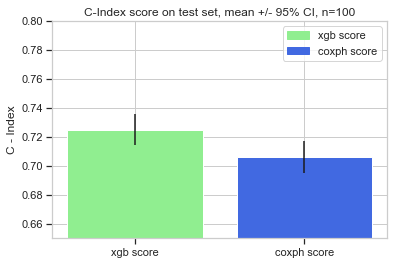

In [42]:
from scipy import stats

scores_df = pd.DataFrame(list(zip(xgb_scores, coxph_scores)), 
               columns =['xgb_scores', 'coxph_scores']) 

mean = scores_df.mean(axis = 0)
std = scores_df.std(axis = 0)

n= scores_df.shape[0]
yerr = std / np.sqrt(n) * stats.t.ppf(1-0.05/2, n - 1)

plt.figure()
plt.bar(range(scores_df.shape[1]), mean, yerr = yerr, color=['lightgreen', 'royalblue'])
plt.ylim(0.65,0.8)
plt.ylabel('C - Index')
plt.xticks([0, 1], ['xgb score', 'coxph score'])  
plt.title('C-Index score on test set, mean +/- 95% CI, n={}'.format(n))

colors = {'xgb score':'lightgreen', 'coxph score':'royalblue'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

plt.show() 

In [43]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [44]:
stats_list = []
for i in [xgb_scores, coxph_scores]:
    stats_list.append(mean_confidence_interval(i))
    
stats_df = pd.DataFrame(stats_list, columns = ['C-Index mean' , 'low CI', 'high CI'], index=['Cox-XGBoost', 'CoxPH'])
stats_df

,C-Index mean,low CI,high CI
Cox-XGBoost,0.724807,0.714196,0.735418
CoxPH,0.706112,0.695002,0.717223


## Explaining XGBoost predictions using SHAP values

In [45]:
import shap
import matplotlib.pylab as pl 

In [46]:
explainer = shap.TreeExplainer(final_xgb)
shap_values = explainer.shap_values(X)

### Explain the effect of each feature on the final risk score for a selected patient

In [58]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[134:135,:], X.iloc[134:135,:])

### SHAP Summary Plot

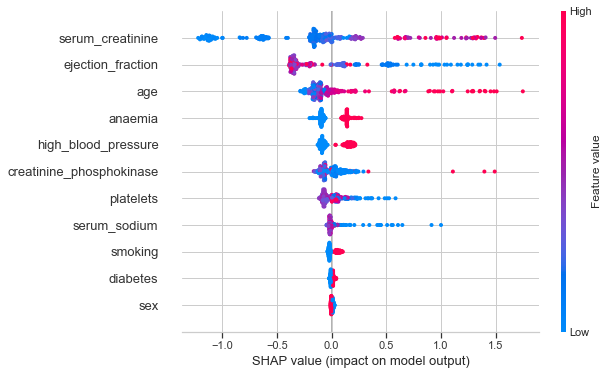

In [47]:
shap.summary_plot(shap_values, X)

### SHAP Dependence Plots

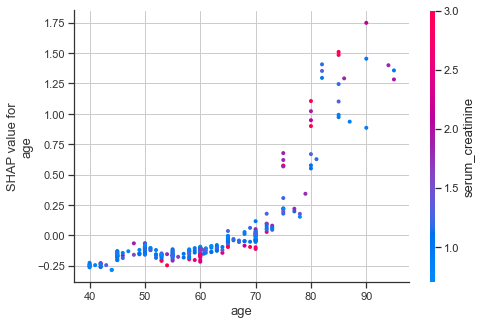

In [48]:
shap.dependence_plot("age", shap_values, X)
# creatinine_phosphokinase is automatically chosen for coloring based on its highest potential for interaction - see SHAP interactions heatmap below

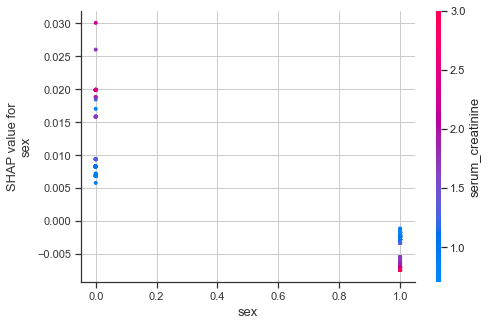

In [49]:
shap.dependence_plot("sex", shap_values, X, display_features=X)

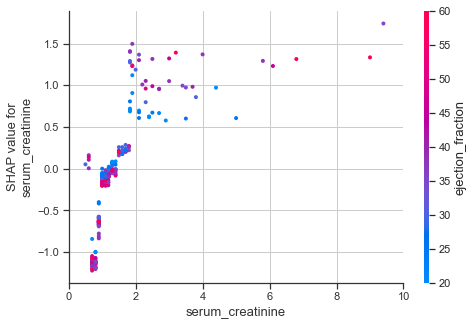

In [50]:
shap.dependence_plot("serum_creatinine", shap_values, X, show=False)  # show=False enables plot cusomization before displaying
pl.xlim(0,10)
pl.show()

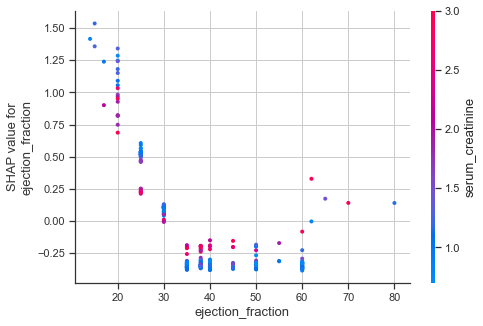

In [51]:
shap.dependence_plot("ejection_fraction", shap_values, X)

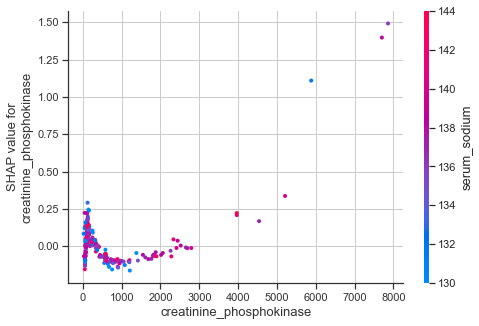

In [52]:
shap.dependence_plot("creatinine_phosphokinase", shap_values, X, display_features=X)

### Compute SHAP Interaction Values

In [53]:
shap_interaction_values = shap.TreeExplainer(final_xgb).shap_interaction_values(X)

### SHAP Interaction Value Summary Plot

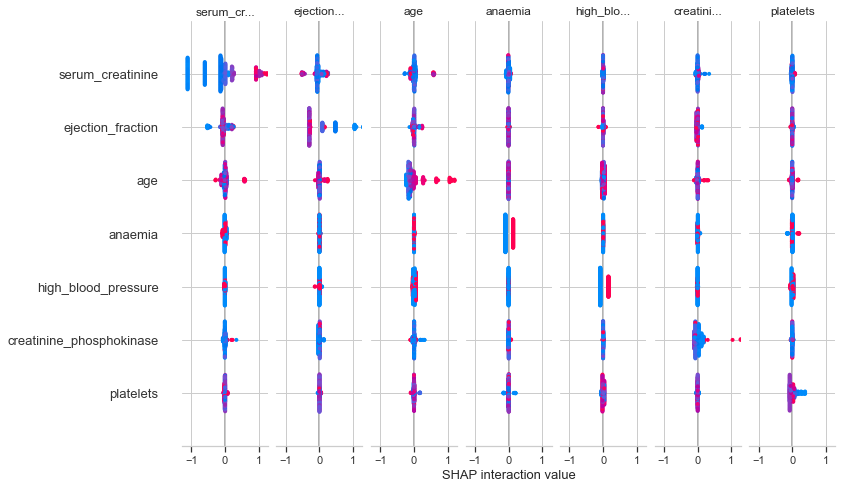

In [54]:
shap.summary_plot(shap_interaction_values, X)

### SHAP Interaction Value Dependence Plots

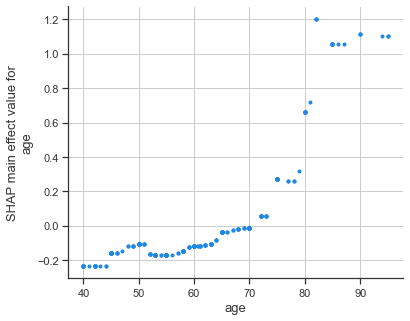

In [55]:
shap.dependence_plot(
    ('age','age'),
    shap_interaction_values, X,
    display_features=X
)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


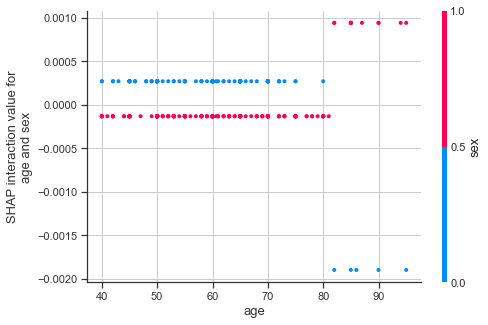

In [56]:
shap.dependence_plot(
    ('age', 'sex'),
    shap_interaction_values, X,
    display_features=X
)

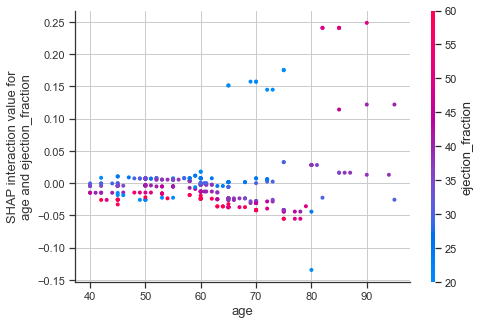

In [57]:
shap.dependence_plot(
    ('age', 'ejection_fraction'),
    shap_interaction_values, X,
    display_features=X
)

### Plot SHAP interaction values heatmap for every pair of featues

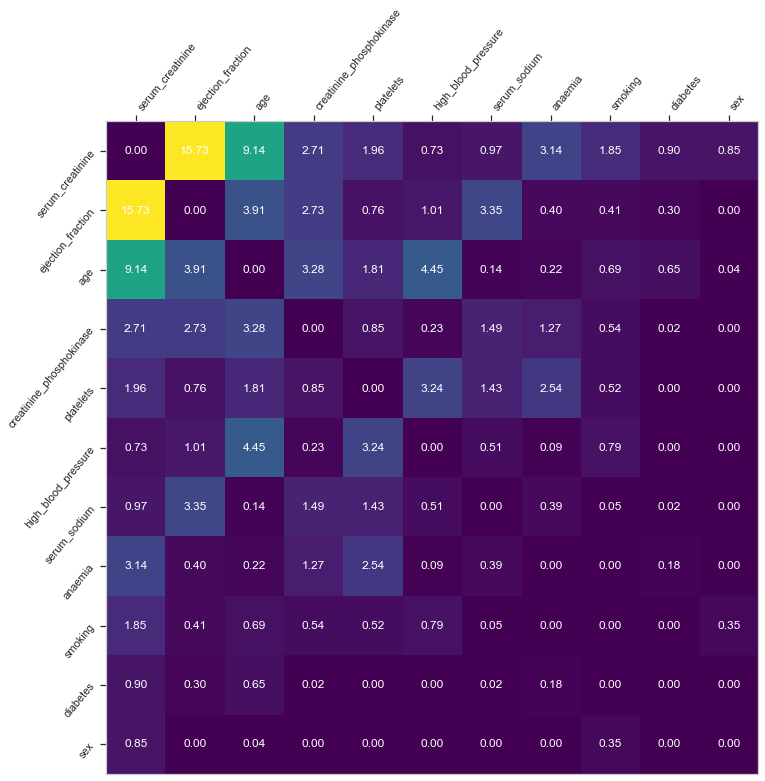

In [59]:
plt.rcParams["axes.grid"] = False
tmp = np.abs(shap_interaction_values).sum(0)
for i in range(tmp.shape[0]):
    tmp[i,i] = 0
inds = np.argsort(-tmp.sum(0))[:50]
tmp2 = tmp[inds,:][:,inds]
pl.figure(figsize=(12,12))
pl.imshow(tmp2, cmap='viridis')
pl.yticks(range(tmp2.shape[0]), X.columns[inds], rotation=50.4, horizontalalignment="right")
pl.xticks(range(tmp2.shape[0]), X.columns[inds], rotation=50.4, horizontalalignment="left")
pl.gca().xaxis.tick_top()

# Loop over data dimensions and create text annotations.
for i in range(len(X.columns[inds])):
    for j in range(len(X.columns[inds])):
        text = pl.text(j, i, '%.2f' % tmp2[i, j],
                       ha="center", va="center", color="w")
pl.show()